# HBM-CRISPR (Hierarchical Bayesian Model for CRISPR)

In [1]:
# Imports & options
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Display options
pd.set_option('display.max_columns', 120)
pd.set_option('display.width', 160)

print('Libraries ready')

Libraries ready


In [42]:
# Paths
project_root = Path('..').resolve().parent  # adjust if needed
data_dir = project_root / 'data'
fig_dir = project_root / 'outputs' / 'figures'
table_dir = project_root / 'outputs' / 'tables'

sgrna_file = data_dir / 'sgrna_summary.csv'

# Ensure outputs exist
fig_dir.mkdir(parents=True, exist_ok=True)
table_dir.mkdir(parents=True, exist_ok=True)

print('Data dir  :', data_dir)
print('Figures   :', fig_dir)
print('Tables    :', table_dir)
print('sgRNA file:', sgrna_file)

Data dir  : /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/data
Figures   : /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/figures
Tables    : /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables
sgRNA file: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/data/sgrna_summary.csv


In [3]:
# Load sgRNA summary (wide format)
assert sgrna_file.exists(), f'Missing file: {sgrna_file}'
sgrna_wide = pd.read_csv(sgrna_file)
print(f'Loaded sgRNA rows: {len(sgrna_wide):,}')

# Peek
display(sgrna_wide.head())

# Required columns sanity check
required_cols = {'sgrna','Gene','control_count','treatment_count'}
missing = required_cols - set(sgrna_wide.columns)
assert not missing, f'Missing required columns: {missing}'

Loaded sgRNA rows: 77,487


,sgrna,Gene,control_count,treatment_count,control_mean,treat_mean,LFC,control_var,adj_var,score,p.low,p.high,p.twosided,FDR,high_in_treatment
0,77449,FOXP3,181.16/186.77,10106/5287.9,183.96,7696.9,5.3792,15.7130,1576.90,189.19,1.0,0.0,0.0,0.0,True
1,17754,SMARCB1,81.278/78.442,4371/4091.6,79.86,4231.3,5.7099,4.0202,642.01,163.85,1.0,0.0,0.0,0.0,True
2,37463,FOXP3,102.82/143.81,7527.5/2948.8,123.32,5238.1,5.3972,840.0700,1025.00,159.76,1.0,0.0,0.0,0.0,True
3,77453,FOXP3,290.84/84.045,8696.1/3933.5,187.44,6314.8,5.0668,21381.0000,1609.10,152.75,1.0,0.0,0.0,0.0,True
4,77477,FOXP3,54.348/22.412,3420.9/1395.3,38.38,2408.1,5.9349,509.9600,291.78,138.73,1.0,0.0,0.0,0.0,True


In [4]:
# Helper to parse 'a/b' replicate fields into two floats

def _parse_two_reps(val):
    # Returns (rep1, rep2) as floats (np.nan if unavailable)
    if pd.isna(val):
        return np.nan, np.nan
    # Try string normalization
    try:
        s = str(val).strip()
    except Exception:
        return np.nan, np.nan
    parts = [p.strip() for p in s.split('/') if p.strip() != '']

    if len(parts) == 0:
        return np.nan, np.nan
    if len(parts) == 1:
        try:
            x = float(parts[0])
        except Exception:
            x = np.nan
        return x, x

    # len(parts) >= 2 → take first two entries
    try:
        a = float(parts[0])
    except Exception:
        a = np.nan
    try:
        b = float(parts[1])
    except Exception:
        b = np.nan
    return a, b

print("Helper _parse_two_reps ready")

Helper _parse_two_reps ready


In [5]:
# Parse replicate counts and attach numeric columns
ctrl_r1, ctrl_r2 = zip(*sgrna_wide['control_count'].map(_parse_two_reps))
trt_r1, trt_r2   = zip(*sgrna_wide['treatment_count'].map(_parse_two_reps))

sgrna_wide = sgrna_wide.assign(
    control_r1=pd.to_numeric(ctrl_r1, errors='coerce'),
    control_r2=pd.to_numeric(ctrl_r2, errors='coerce'),
    treatment_r1=pd.to_numeric(trt_r1, errors='coerce'),
    treatment_r2=pd.to_numeric(trt_r2, errors='coerce')
)

display(sgrna_wide[['sgrna','Gene','control_r1','control_r2','treatment_r1','treatment_r2']].head())

,sgrna,Gene,control_r1,control_r2,treatment_r1,treatment_r2
0,77449,FOXP3,181.160,186.770,10106.0,5287.9
1,17754,SMARCB1,81.278,78.442,4371.0,4091.6
2,37463,FOXP3,102.820,143.810,7527.5,2948.8
3,77453,FOXP3,290.840,84.045,8696.1,3933.5
4,77477,FOXP3,54.348,22.412,3420.9,1395.3


In [6]:
# Build tidy long-form count table (one row per sgRNA x sample)
# Assumptions:
# - treatment = FOXP3-low; control = FOXP3-high
# - Two replicates for each condition: r1, r2

rows = []
for _, row in sgrna_wide.iterrows():
    sg = row['sgrna']
    gene = row['Gene']
    # Control (FOXP3-high)
    rows.append({
        'sgrna': sg,
        'gene': gene,
        'condition': 'control',
        'replicate': 1,
        'sample_id': 'control_r1',
        'count': row.get('control_r1', np.nan)
    })
    rows.append({
        'sgrna': sg,
        'gene': gene,
        'condition': 'control',
        'replicate': 2,
        'sample_id': 'control_r2',
        'count': row.get('control_r2', np.nan)
    })
    # Treatment (FOXP3-low)
    rows.append({
        'sgrna': sg,
        'gene': gene,
        'condition': 'treatment',
        'replicate': 1,
        'sample_id': 'treatment_r1',
        'count': row.get('treatment_r1', np.nan)
    })
    rows.append({
        'sgrna': sg,
        'gene': gene,
        'condition': 'treatment',
        'replicate': 2,
        'sample_id': 'treatment_r2',
        'count': row.get('treatment_r2', np.nan)
    })

counts_long = pd.DataFrame(rows)

# Library-size normalization: per-sample size factors
lib_sizes = counts_long.groupby('sample_id')['count'].sum()
geom_mean = np.exp(np.log(lib_sizes.replace(0, np.nan)).mean())
size_factors = (lib_sizes / geom_mean).replace([np.inf, -np.inf], np.nan)
size_factors = size_factors.fillna(1.0)
size_factors = size_factors.rename('size_factor').reset_index()

# Add size factors (counts_long already has condition/replicate)
counts_long = counts_long.merge(size_factors, on='sample_id', how='left')

print('Tidy counts shape:', counts_long.shape)
print('Samples:', counts_long['sample_id'].unique())
print('NaN counts:', counts_long['count'].isna().sum())

display(counts_long.head())

Tidy counts shape: (309948, 7)
Samples: ['control_r1' 'control_r2' 'treatment_r1' 'treatment_r2']
NaN counts: 0


,sgrna,gene,condition,replicate,sample_id,count,size_factor
0,77449,FOXP3,control,1,control_r1,181.160,0.993118
1,77449,FOXP3,control,2,control_r2,186.770,0.999318
2,77449,FOXP3,treatment,1,treatment_r1,10106.000,1.002837
3,77449,FOXP3,treatment,2,treatment_r2,5287.900,1.004766
4,17754,SMARCB1,control,1,control_r1,81.278,0.993118


In [7]:
# QA/QC: Sample-level summaries
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

plt.style.use('arviz-docgrid')


# Totals, zeros, unique sgRNAs per sample
sample_totals = counts_long.groupby('sample_id')['count'].sum().rename('total_count')
zero_counts = (
    counts_long.assign(is_zero=(counts_long['count'] == 0))
    .groupby('sample_id')['is_zero']
    .sum()
    .rename('zero_count')
)
n_sgrna = counts_long.groupby('sample_id')['sgrna'].nunique().rename('n_sgrna')

# Size factors (already merged)
sf = (
    counts_long[['sample_id','size_factor']]
    .drop_duplicates()
    .set_index('sample_id')['size_factor']
)

summary = pd.concat([sample_totals, zero_counts, n_sgrna, sf], axis=1).reset_index()
summary['nonzero'] = summary['n_sgrna'] - summary['zero_count']

print('QA/QC — sample summary:')
display(summary)


QA/QC — sample summary:


,sample_id,total_count,zero_count,n_sgrna,size_factor,nonzero
0,control_r1,2.716991e+07,8,77487,0.993118,77479
1,control_r2,2.733954e+07,14,77487,0.999318,77473
2,treatment_r1,2.743582e+07,2,77487,1.002837,77485
3,treatment_r2,2.748858e+07,7,77487,1.004766,77480


In [8]:
# Save tidy counts to outputs/tables
out_path = table_dir / 'tidy_counts.csv'
counts_long.to_csv(out_path, index=False)
print(f'Saved tidy counts to: {out_path}')

Saved tidy counts to: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/tidy_counts.csv


## Normalization: library-size factors

We use simple library-size normalization:
- For each sample, compute total sgRNA counts
- Compute the geometric mean of total counts across samples
- Define size_factor for a sample as total_count / geometric_mean
- Use log(size_factor) as an offset in GLMs and downstream models

Note: DESeq2 median-of-ratios, which is also a possible normalization method, produced size factors ≈ 1 across samples in this dataset, so it would have minimal impact.

Saved figure: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/figures/qc_sizefactors_total_counts.png


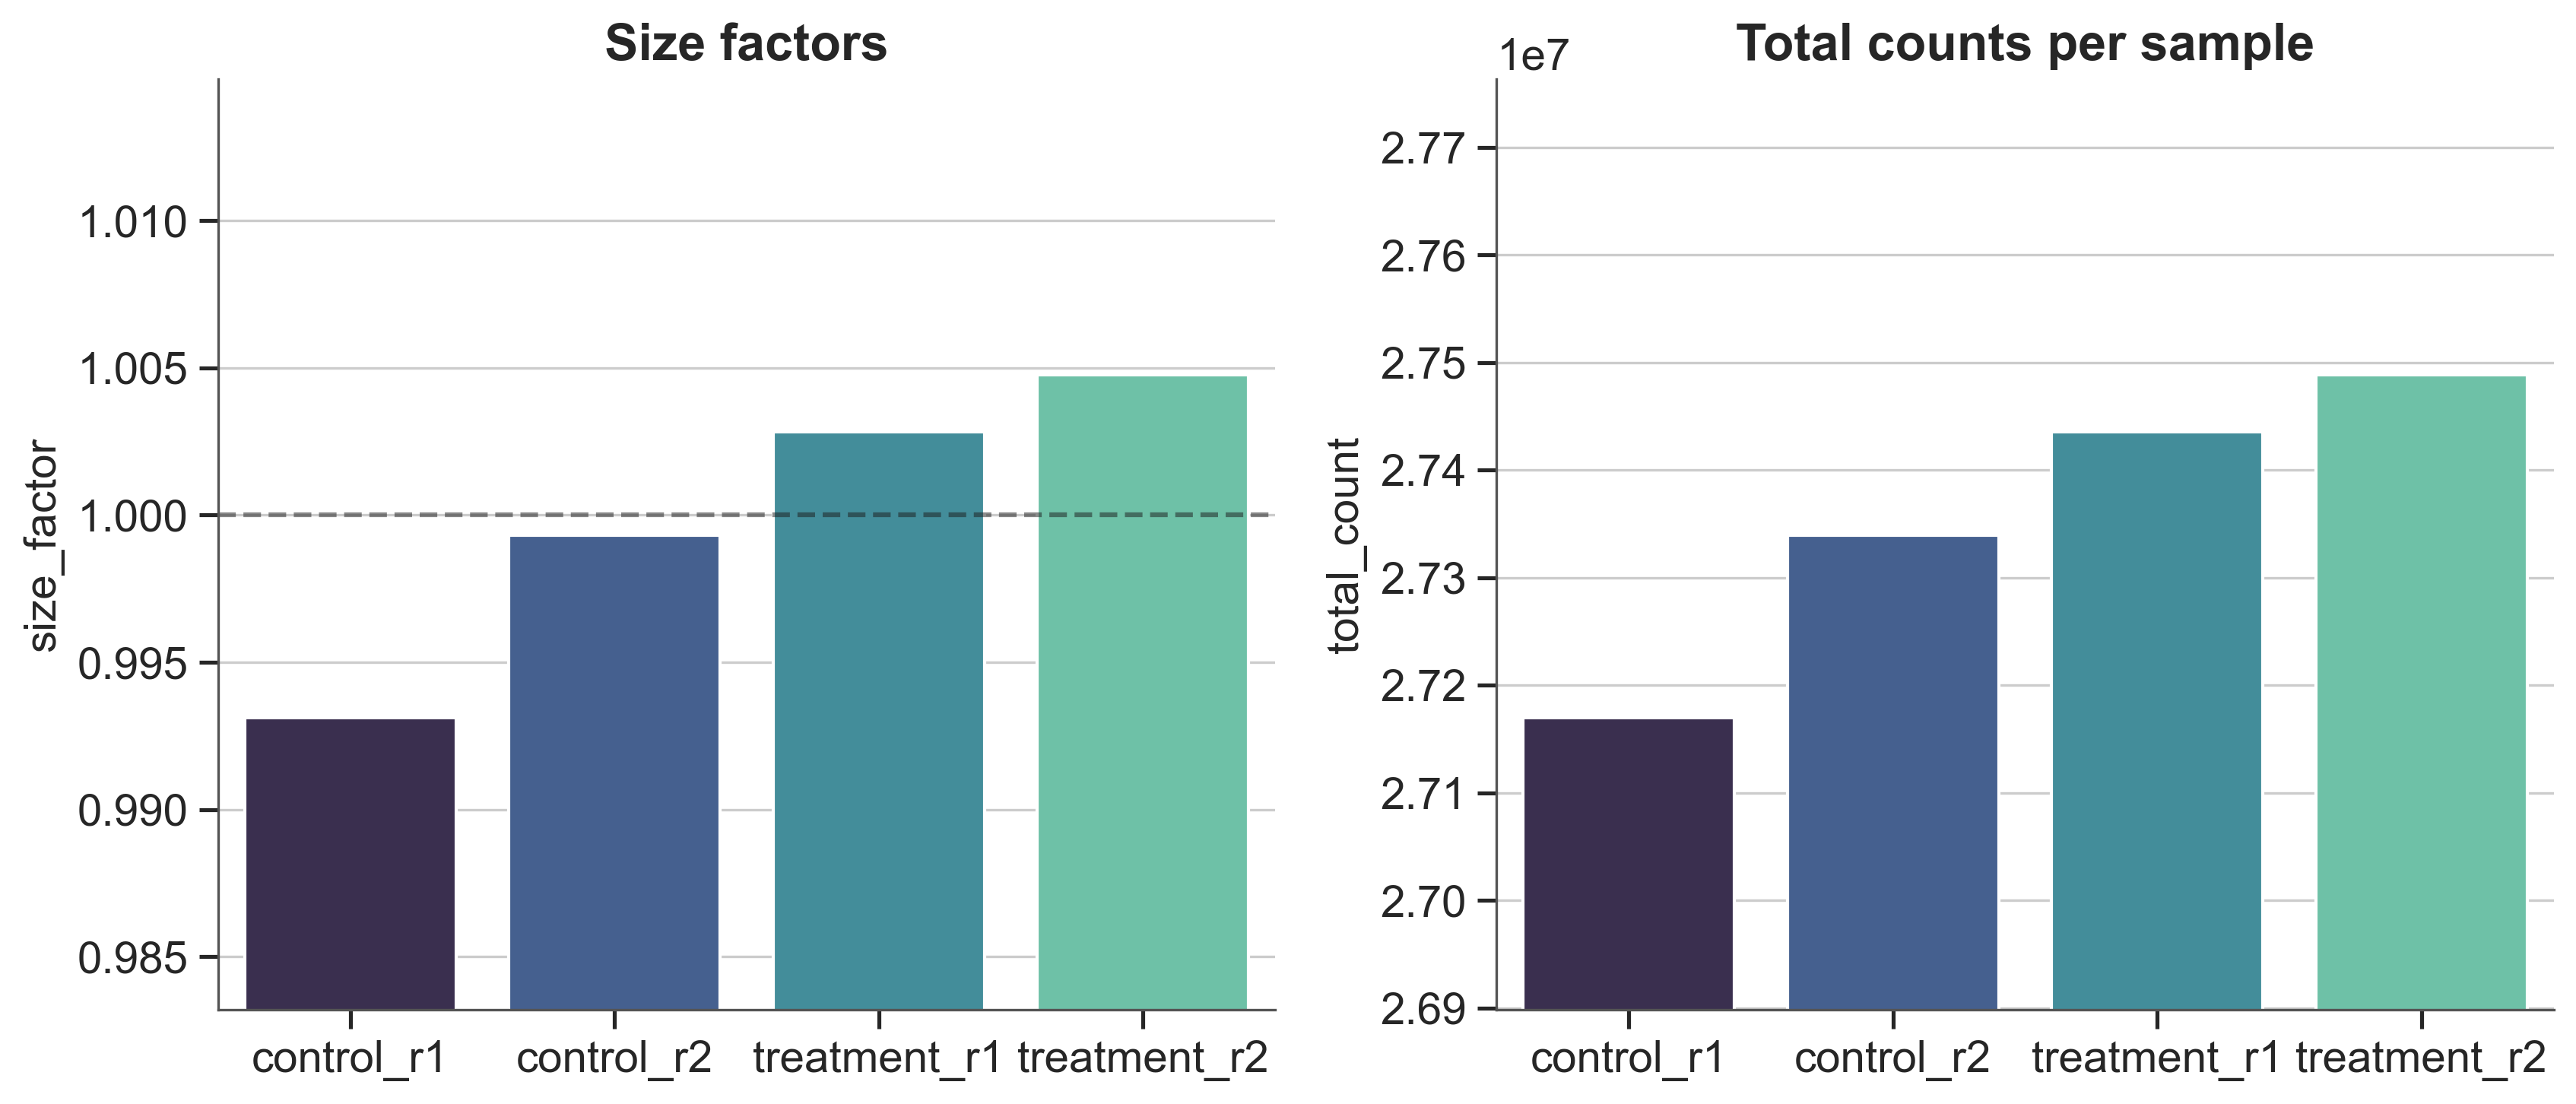

In [50]:
# QA/QC: Size factor bar plot and total counts
fig, axes = plt.subplots(1, 2)

sns.barplot(ax=axes[0], x='sample_id', y='size_factor', data=summary, palette='mako')
axes[0].set_title('Size factors')
axes[0].set_xlabel('')
axes[0].axhline(1.0, color='k', linestyle='--', alpha=0.5)
axes[0].set_ylim(summary['size_factor'].min() * .99, summary['size_factor'].max() * 1.01)

sns.barplot(ax=axes[1], x='sample_id', y='total_count', data=summary, palette='mako')
axes[1].set_title('Total counts per sample')
axes[1].set_xlabel('')
axes[1].set_ylim(summary['total_count'].min() * 0.99, summary['total_count'].max() * 1.01)

# Improve x-label readability: smaller font size and slight rotation
#for ax in axes:
#    plt.setp(ax.get_xticklabels(), rotation=25, ha='right', fontsize=8)
#    ax.tick_params(axis='x', which='major', pad=6)

plt.tight_layout()
# Save figure
fig_dir.mkdir(parents=True, exist_ok=True)
out_path_fig = fig_dir / 'qc_sizefactors_total_counts.png'
fig.savefig(str(out_path_fig), dpi=150, bbox_inches='tight')
print(f'Saved figure: {out_path_fig}')
plt.show()

Saved figure: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/figures/qc_replicate_concordance.png


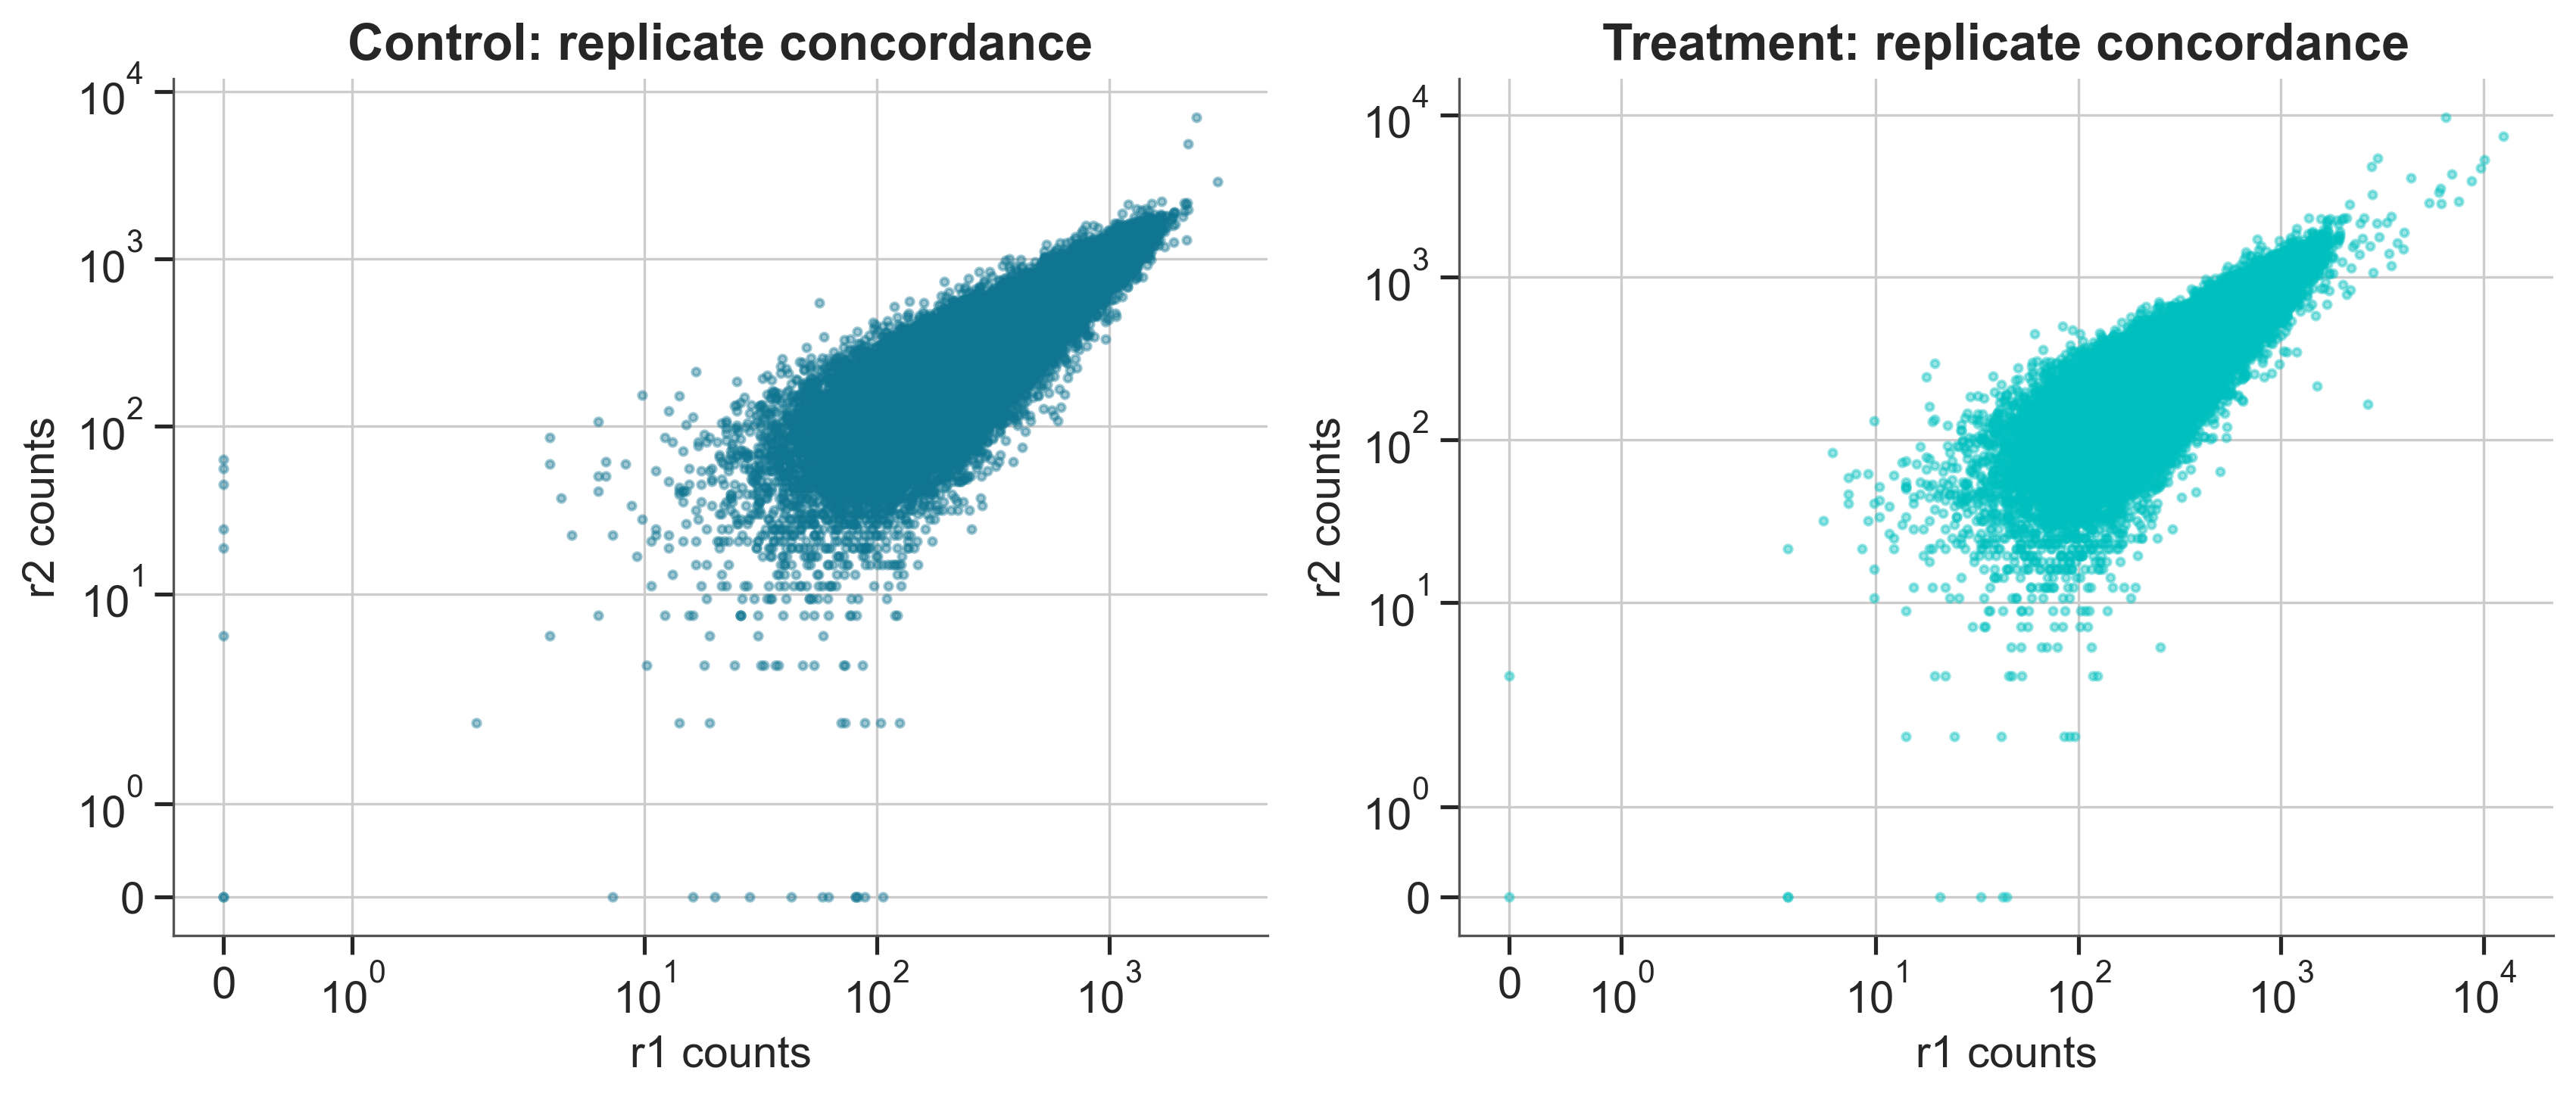

In [52]:
# QA/QC: replicate concordance (scatter) by condition
# Aggregate counts per sgRNA per replicate for each condition and plot r1 vs r2

# Control
ctrl = counts_long[counts_long['condition']=='control']
ctrl_pivot = ctrl.pivot_table(index=['sgrna','gene'], columns='replicate', values='count', aggfunc='sum')
ctrl_pivot.columns = [f'r{int(c)}' for c in ctrl_pivot.columns]

# Treatment
trt = counts_long[counts_long['condition']=='treatment']
trt_pivot = trt.pivot_table(index=['sgrna','gene'], columns='replicate', values='count', aggfunc='sum')
trt_pivot.columns = [f'r{int(c)}' for c in trt_pivot.columns]

fig, axes = plt.subplots(1, 2)

axes[0].scatter(ctrl_pivot['r1'], ctrl_pivot['r2'], s=6, alpha=0.4)
axes[0].set_xscale('symlog')
axes[0].set_yscale('symlog')
axes[0].set_title('Control: replicate concordance')
axes[0].set_xlabel('r1 counts')
axes[0].set_ylabel('r2 counts')

axes[1].scatter(trt_pivot['r1'], trt_pivot['r2'], s=6, alpha=0.4, color='C1')
axes[1].set_xscale('symlog')
axes[1].set_yscale('symlog')
axes[1].set_title('Treatment: replicate concordance')
axes[1].set_xlabel('r1 counts')
axes[1].set_ylabel('r2 counts')

plt.tight_layout()
# Save figure
fig_dir.mkdir(parents=True, exist_ok=True)
out_path_fig = fig_dir / 'qc_replicate_concordance.png'
fig.savefig(str(out_path_fig), dpi=150, bbox_inches='tight')
print(f'Saved figure: {out_path_fig}')
plt.show()

Saved figure: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/figures/qc_ecdf_counts.png


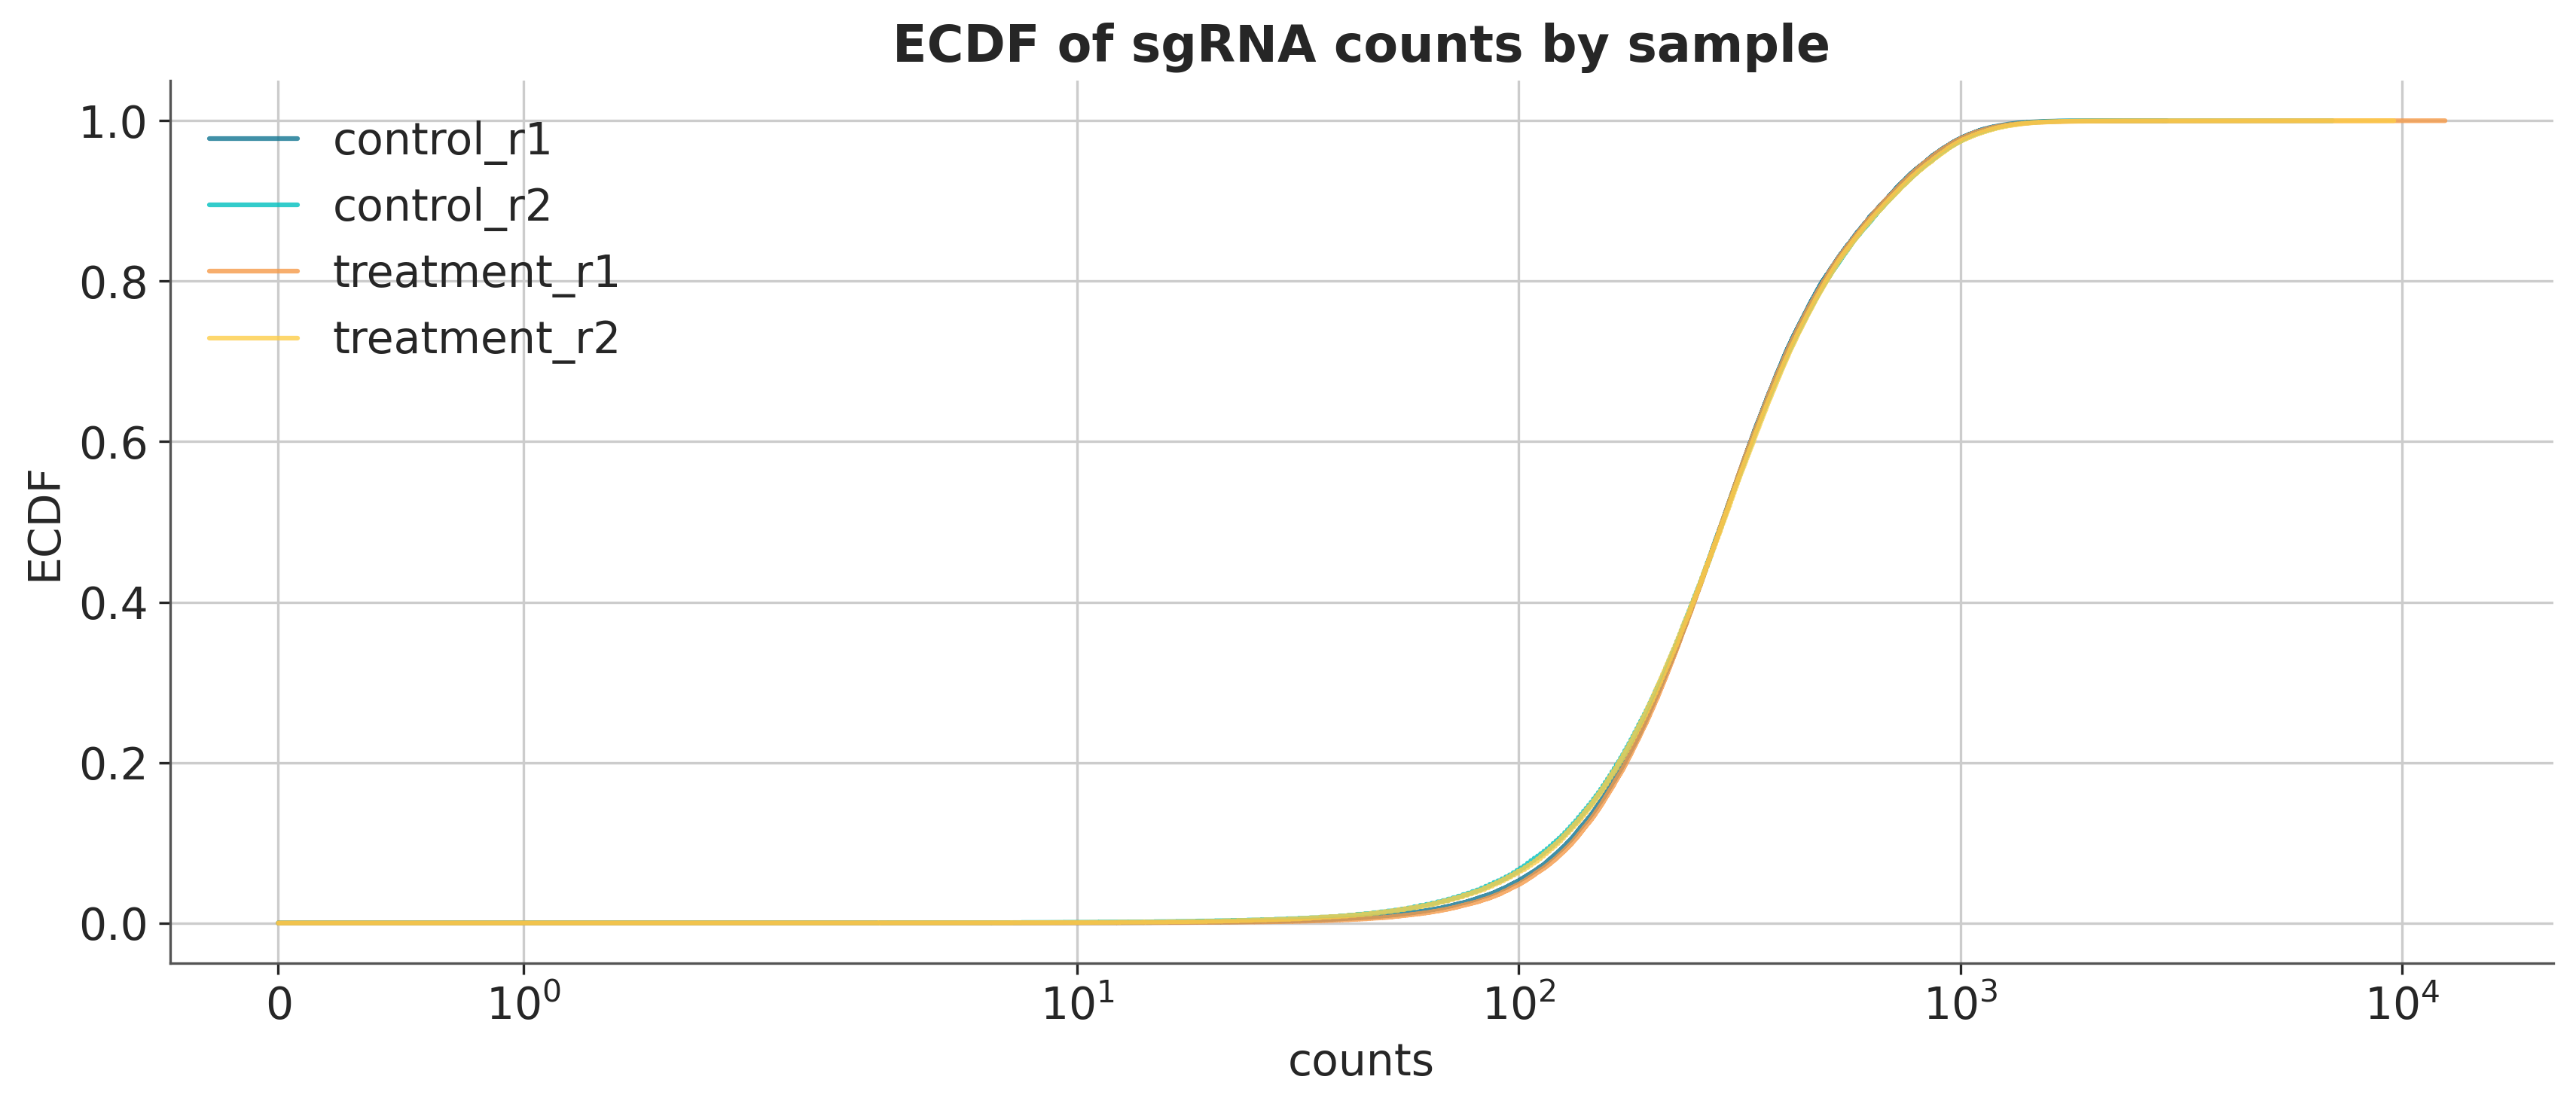

In [12]:
# QA/QC: sgRNA count distributions by sample (ECDF)
colors = {
    'control_r1': 'C0',
    'control_r2': 'C1',
    'treatment_r1': 'C2',
    'treatment_r2': 'C3',
}
for sid, grp in counts_long.groupby('sample_id'):
    x = np.sort(grp['count'].values)
    n = len(x)
    y = np.arange(1, n + 1) / n
    plt.plot(x, y, label=sid, color=colors.get(sid, None), alpha=0.8)

plt.xscale('symlog')
plt.xlabel('counts')
plt.ylabel('ECDF')
plt.title('ECDF of sgRNA counts by sample')
plt.legend()
plt.tight_layout()
# Save figure
fig_dir.mkdir(parents=True, exist_ok=True)
out_path_fig = fig_dir / 'qc_ecdf_counts.png'
plt.gcf().savefig(str(out_path_fig), dpi=150, bbox_inches='tight')
print(f'Saved figure: {out_path_fig}')
plt.show()

Saved figure: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/figures/qc_hist_counts_by_sample.png


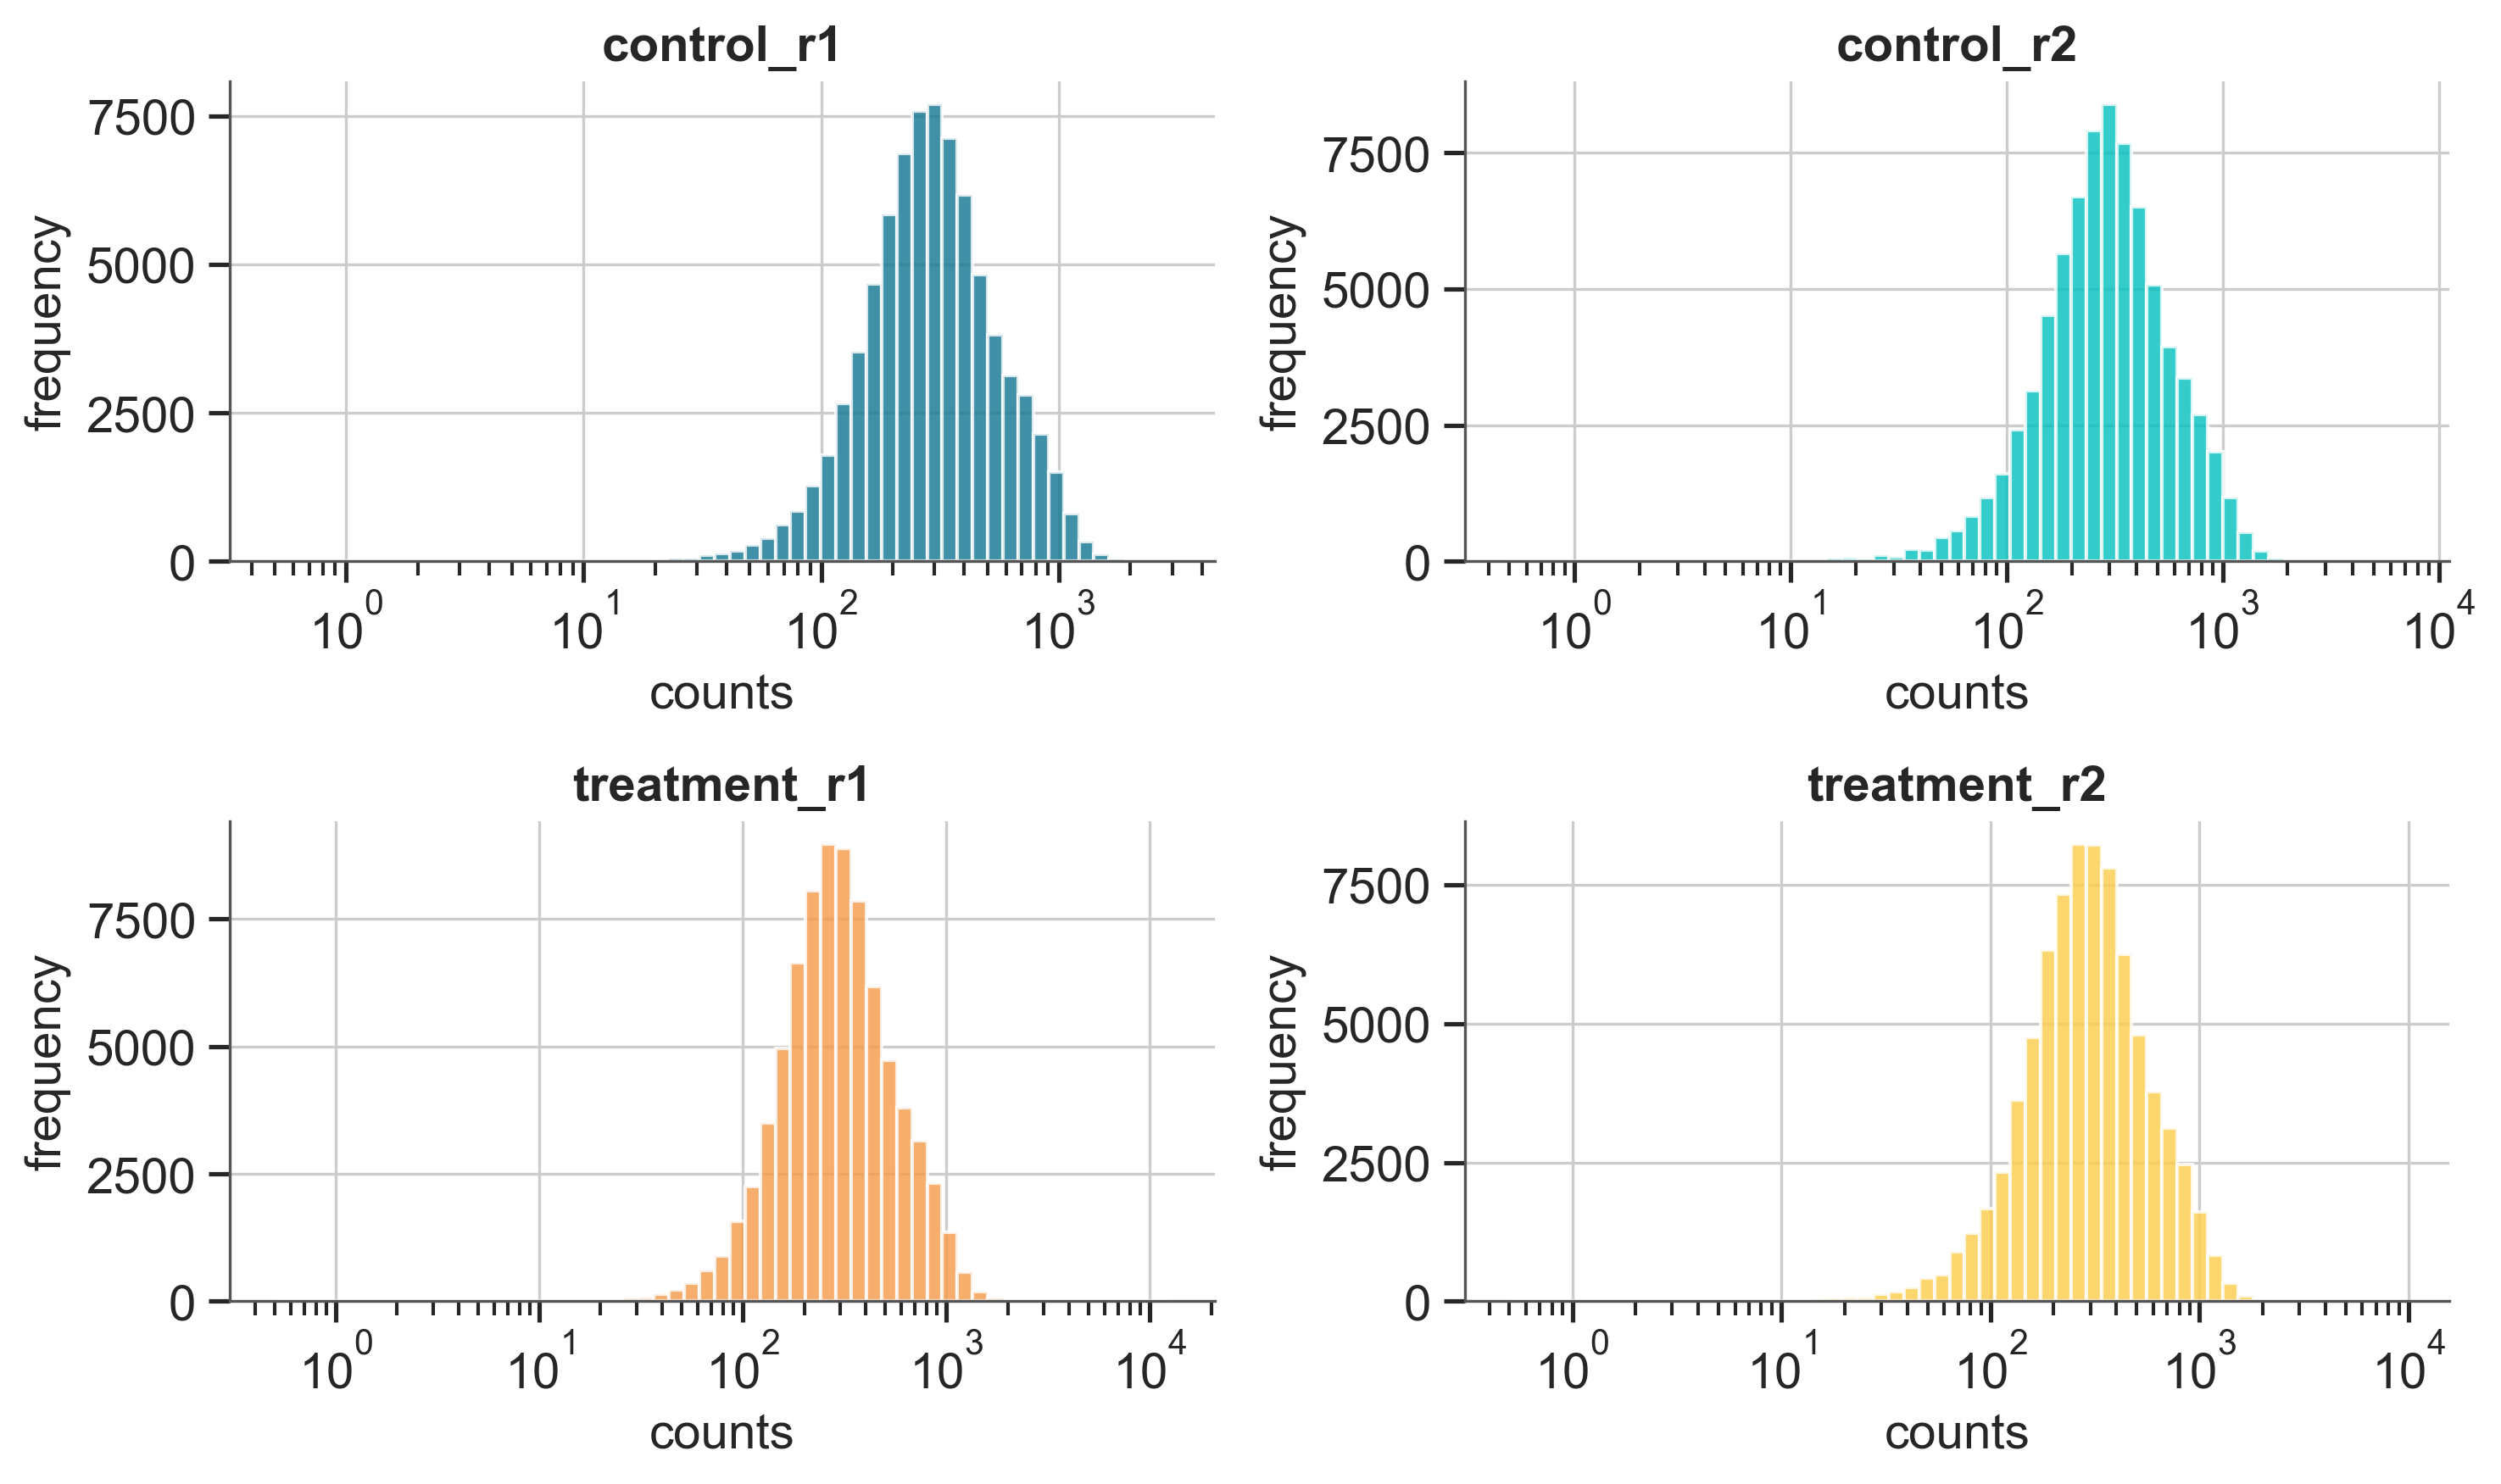

In [54]:
# QA/QC: Per-sample histograms of sgRNA counts (log-binned)
import math

samples = summary['sample_id'].tolist()
n = len(samples)
cols = 2
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(10, 3 * rows))
axes = axes.flatten() if n > 1 else [axes]

for i, sid in enumerate(samples):
    data = counts_long.loc[counts_long['sample_id'] == sid, 'count'].values
    # replace zeros with small positive to allow log bins
    data_plot = np.where(data <= 0, 0.5, data)
    max_val = max(1.0, data_plot.max())
    bins = np.logspace(math.log10(0.5), math.log10(max_val + 1.0), 60)
    axes[i].hist(data_plot, bins=bins, color=f'C{i}', alpha=0.8)
    axes[i].set_xscale('log')
    axes[i].set_title(sid, fontsize=14)
    axes[i].set_xlabel('counts')
    axes[i].set_ylabel('frequency')

# hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
# Save figure (single combined file)
fig_dir.mkdir(parents=True, exist_ok=True)
out_path_fig = fig_dir / 'qc_hist_counts_by_sample.png'
fig.savefig(str(out_path_fig), dpi=150, bbox_inches='tight')
print(f'Saved figure: {out_path_fig}')
plt.show()

## Benchmark: MAGeCK hit genes (FDR ≤ 0.05 and |log2FC| ≥ 0.3)

Identify hit genes from MAGeCK gene summary by combining pos/neg directions via the minimum FDR and selecting the matching log2FC. Outputs:
- `outputs/tables/bench_mageck_combined.csv`: combined FDR/log2FC per gene
- `outputs/tables/bench_mageck_hits.csv`: genes passing FDR ≤ 0.05 and |log2FC| ≥ 0.3

In [30]:
# MAGeCK benchmark: compute combined direction and hits
import pandas as pd
import numpy as np
from pathlib import Path

project_root = globals().get('project_root', Path('..').resolve().parent)
data_dir = globals().get('data_dir', project_root / 'data')
table_dir = globals().get('table_dir', project_root / 'outputs' / 'tables')

gs_path = data_dir / 'gene_summary.csv'
assert gs_path.exists(), f"Missing MAGeCK gene_summary.csv at {gs_path}"

df = pd.read_csv(gs_path)
# Expected columns in MAGeCK gene summary
req = {
    'id','neg|fdr','pos|fdr','neg|lfc','pos|lfc'
}
missing = req - set(df.columns)
if missing:
    raise ValueError(f"gene_summary.csv missing required columns: {missing}")

# Choose the direction with the smaller FDR; take its FDR and log2FC
neg_fdr = df['neg|fdr'].astype(float)
pos_fdr = df['pos|fdr'].astype(float)
neg_lfc = df['neg|lfc'].astype(float)
pos_lfc = df['pos|lfc'].astype(float)

# Combined values
best_is_neg = neg_fdr <= pos_fdr
combined_fdr = np.where(best_is_neg, neg_fdr, pos_fdr)
combined_lfc = np.where(best_is_neg, neg_lfc, pos_lfc)
combined_dir = np.where(best_is_neg, 'neg', 'pos')

out = pd.DataFrame({
    'gene': df['id'].astype(str),
    'dir': combined_dir,
    'fdr': combined_fdr,
    'log2fc': combined_lfc,
})

# Hit rule: FDR ≤ 0.05 and |log2FC| ≥ 0.3
FDR_MAX = 0.05
LFC_ABS_MIN = 0.6
out['neglog10_fdr'] = -np.log10(np.clip(out['fdr'].astype(float).values, 1e-300, 1.0))
out['abs_log2fc'] = np.abs(out['log2fc'].astype(float).values)
out['hit'] = (out['fdr'] <= FDR_MAX) & (out['abs_log2fc'] >= LFC_ABS_MIN)

# Save outputs
bench_combined = table_dir / 'bench_mageck_combined.csv'
bench_hits = table_dir / 'bench_mageck_hits.csv'
out.to_csv(bench_combined, index=False)
out.loc[out['hit']].to_csv(bench_hits, index=False)
print(f"Saved MAGeCK combined metrics: {bench_combined}")
print(f"Saved MAGeCK hits (FDR≤{FDR_MAX}, |log2FC|≥{LFC_ABS_MIN}): {bench_hits} (n={int(out['hit'].sum())})")
print(f"Number of MAGeCK hit genes: {int(out['hit'].sum())}")

# Display top 20 by FDR, tiebreak by |log2fc|
display(out.sort_values(['fdr','abs_log2fc'], ascending=[True, False]).head(20))

Saved MAGeCK combined metrics: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/bench_mageck_combined.csv
Saved MAGeCK hits (FDR≤0.05, |log2FC|≥0.6): /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/bench_mageck_hits.csv (n=239)
Number of MAGeCK hit genes: 239


,gene,dir,fdr,log2fc,neglog10_fdr,abs_log2fc,hit
19110,DAD1,pos,0.000121,3.9063,3.917215,3.9063,True
19108,TGFBR1,pos,0.000121,3.6687,3.917215,3.6687,True
19111,SMARCB1,pos,0.000121,3.3875,3.917215,3.3875,True
19103,TGFBR2,pos,0.000121,3.2522,3.917215,3.2522,True
19109,SMAD3,pos,0.000121,3.0596,3.917215,3.0596,True
19112,FOXP3,pos,0.000121,3.0411,3.917215,3.0411,True
19106,USO1,pos,0.000121,2.5978,3.917215,2.5978,True
19104,SMAD4,pos,0.000121,2.5848,3.917215,2.5848,True
19107,STAT5B,pos,0.000121,2.4527,3.917215,2.4527,True
19105,RPN1,pos,0.000121,2.3858,3.917215,2.3858,True


Saved MAGeCK volcano figure: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/figures/volcano_plot_mageck.png


<Figure size 3450x1500 with 0 Axes>

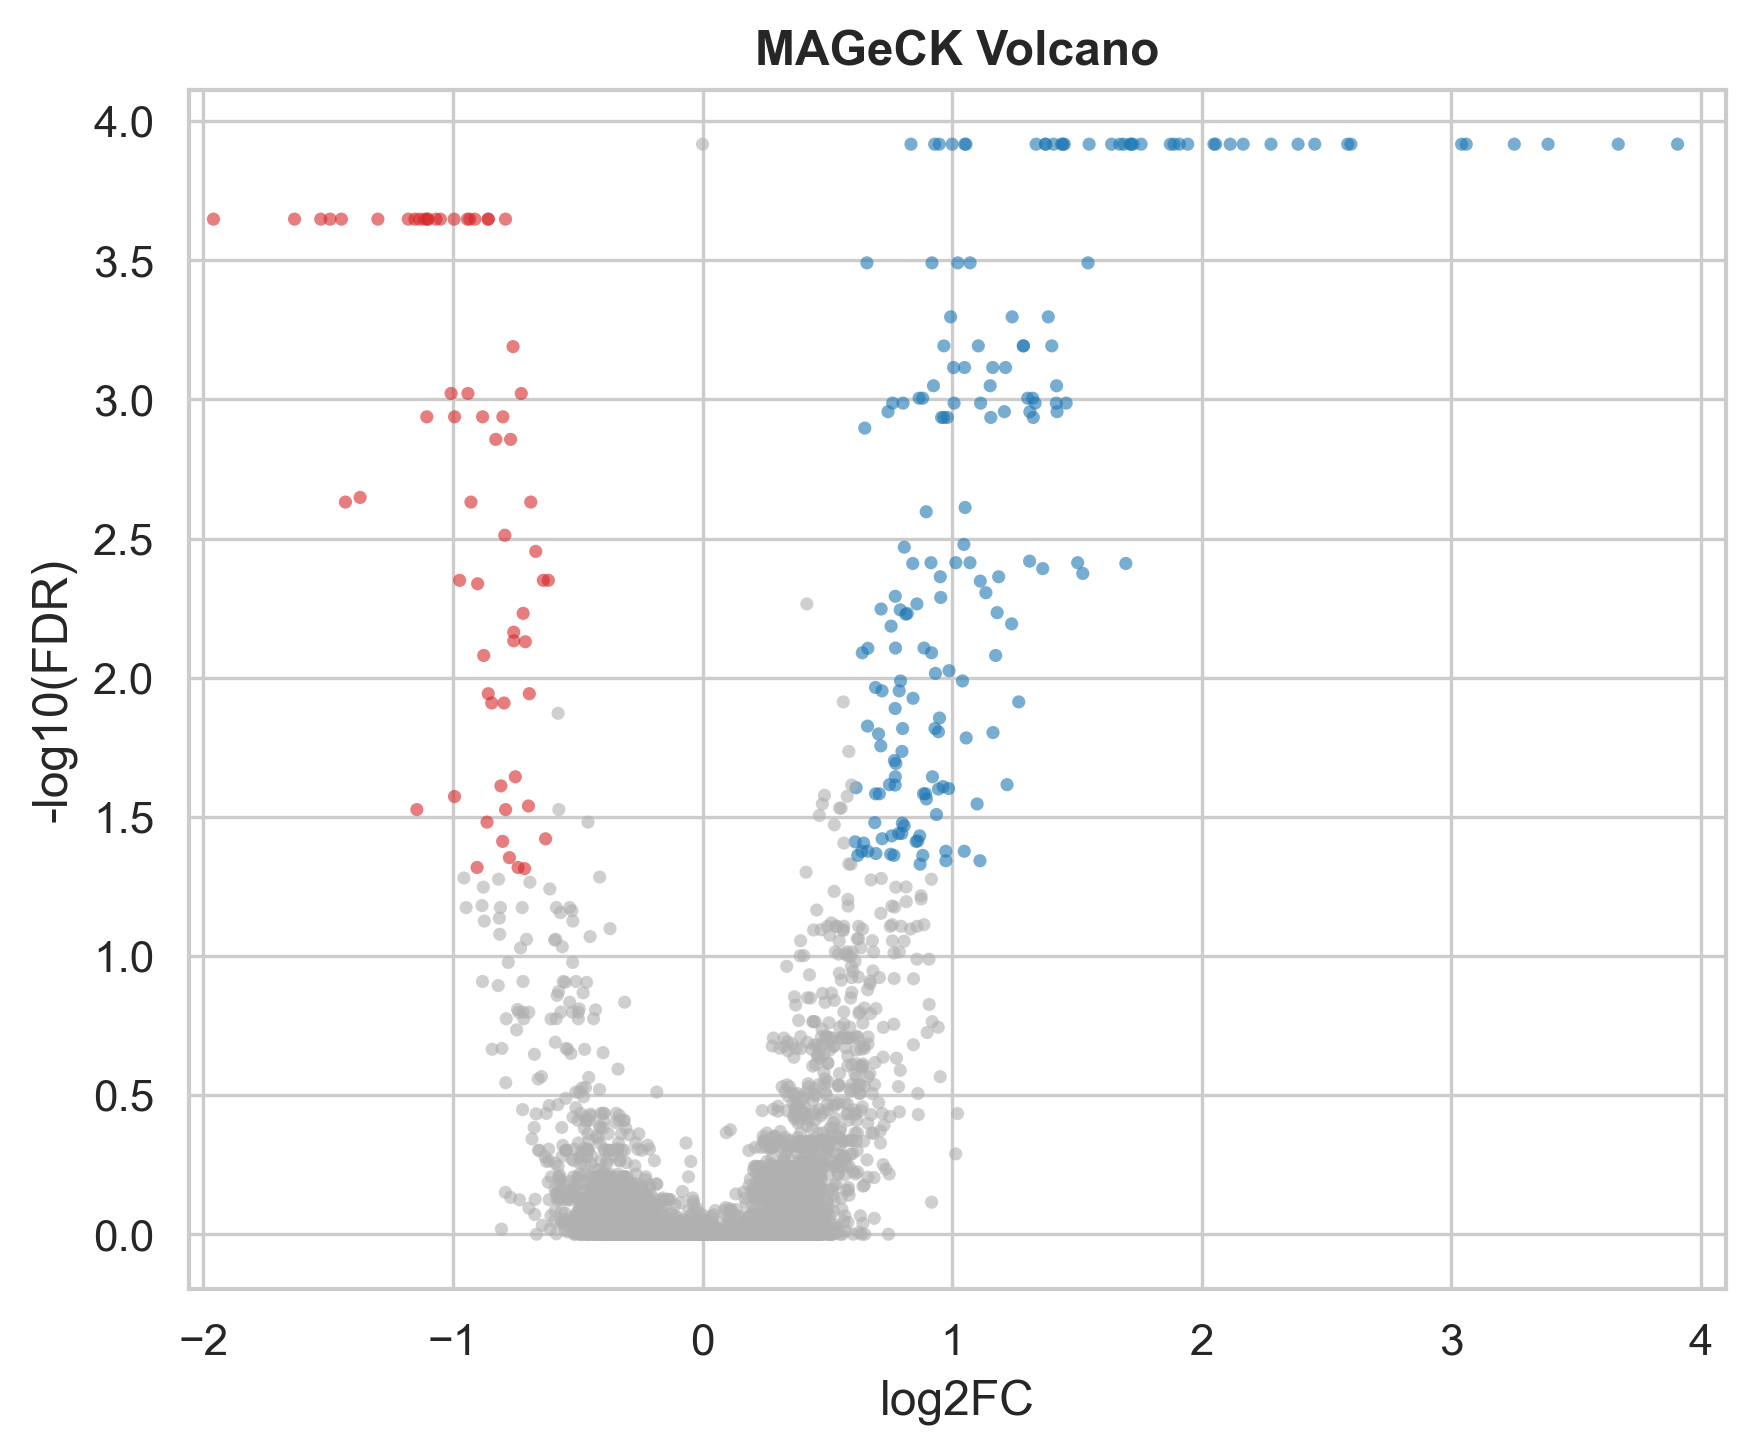

In [34]:
# Volcano plot for MAGeCK results (x=log2FC, y=-log10(FDR))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.2)

project_root = globals().get('project_root', Path('..').resolve().parent)
fig_dir = globals().get('fig_dir', project_root / 'outputs' / 'figures')
table_dir = globals().get('table_dir', project_root / 'outputs' / 'tables')
data_dir = globals().get('data_dir', project_root / 'data')
fig_dir.mkdir(parents=True, exist_ok=True)

# Prefer precomputed combined file; fallback to computing from MAGeCK gene_summary.csv
combined_path = table_dir / 'bench_mageck_combined.csv'
if combined_path.exists():
    df = pd.read_csv(combined_path)
else:
    gs_path = data_dir / 'gene_summary.csv'
    assert gs_path.exists(), f"Missing MAGeCK gene_summary.csv at {gs_path}"
    df_raw = pd.read_csv(gs_path)
    req = {'id','neg|fdr','pos|fdr','neg|lfc','pos|lfc'}
    missing = req - set(df_raw.columns)
    if missing:
        raise ValueError(f"gene_summary.csv missing required columns: {missing}")
    neg_fdr = df_raw['neg|fdr'].astype(float)
    pos_fdr = df_raw['pos|fdr'].astype(float)
    neg_lfc = df_raw['neg|lfc'].astype(float)
    pos_lfc = df_raw['pos|lfc'].astype(float)
    best_is_neg = neg_fdr <= pos_fdr
    combined_fdr = np.where(best_is_neg, neg_fdr, pos_fdr)
    combined_lfc = np.where(best_is_neg, neg_lfc, pos_lfc)
    df = pd.DataFrame({
        'gene': df_raw['id'].astype(str),
        'fdr': combined_fdr,
        'log2fc': combined_lfc,
    })

# Hit rule
FDR_MAX = 0.05
LFC_ABS_MIN = 0.6
EPS = 1e-300

df = df.dropna(subset=['log2fc','fdr']).copy()
df['neglog10_fdr'] = -np.log10(np.clip(df['fdr'].astype(float).values, EPS, 1.0))
df['abs_log2fc'] = np.abs(df['log2fc'].astype(float).values)
df['hit'] = (df['fdr'] <= FDR_MAX) & (df['abs_log2fc'] >= LFC_ABS_MIN)

# Colors: gray for non-hits; hits red if log2fc>0 else blue
colors = np.where(
    df['hit'].fillna(False).values,
    np.where(df['log2fc'].astype(float).values > 0, '#1f77b4','#d62728'),
    '#b0b0b0'
)

plt.figure()
plt.figure(figsize=(6,5))
plt.scatter(df['log2fc'].astype(float), df['neglog10_fdr'].astype(float), c=colors, s=10, alpha=0.6, linewidths=0)
plt.xlabel('log2FC')
plt.ylabel('-log10(FDR)')
plt.title('MAGeCK Volcano')

# Symmetric x-limits around 0
xmax = float(np.nanmax(df['log2fc'])) if len(df) else 1.0
xmin = float(np.nanmin(df['log2fc'])) if len(df) else 1.0
if np.isfinite(xmax) and xmax > 0:
    plt.xlim(1.05 * xmin, 1.05 * xmax)

plt.tight_layout()
out_path = fig_dir / 'volcano_plot_mageck.png'
plt.savefig(str(out_path), dpi=150, bbox_inches='tight')
print(f"Saved MAGeCK volcano figure: {out_path}")
plt.show()

## HBM-CRISPR (Hierarchical Bayesian Model for CRISPR)

- Objective: Jointly estimate multiple genes in a single model with global shrinkage on β_g to stabilize effect estimates.
- Likelihood (NB2):
$$
\begin{aligned}
y_{g,i,s} &\sim \mathrm{NB2}\big(\mu_{g,i,s}, \phi\big),\\
\log \mu_{g,i,s} &= \log(\text{size\_factor}_s) + \gamma_g + \beta_g\,\tilde x_s + u_{g,i} + r_s,\quad \sum_s r_s=0\\
\mathrm{Var}\!\left[y_{g,i,s}\mid \mu_{g,i,s},\phi\right] &= \mu_{g,i,s} + \frac{\mu_{g,i,s}^2}{\phi}.
\end{aligned}
$$

- Parameter/variable definitions:
  - γ_g (gene intercept): baseline log-mean count for gene g when x̃_s = 0 and the centered sample effect averages to 0; captures average abundance after library-size normalization.
  - β_g (treatment effect): per-unit change in log-mean with x̃_s. With centered coding and balanced groups (x̃_treat = +0.5, x̃_ctrl = −0.5), β_g equals the log fold-change (treatment vs control), so exp(β_g) is the rate ratio. With imbalance, the treat–control contrast is β_g·(x̄̃_treat − x̄̃_ctrl).
  - u_{g,i} (sgRNA effect): guide-level random effect for sgRNA i targeting gene g; captures guide efficiency/sequence bias and shrinks toward 0 via τ_u.
  - r_s (sample effect): sample-specific offset capturing residual multiplicative shifts (e.g., batch/replicate effects) beyond size-factor normalization; constrained so ∑_s r_s = 0 for identifiability.  

- Priors:
$$
\begin{align*}
\gamma_g &\sim \mathcal{N}(0, 1.5) \\
\beta_g &\sim \mathcal{N}(0, \tau_\beta), \quad \tau_\beta \sim \mathrm{HalfNormal}(1) \\
u_{g,i} &\sim \mathcal{N}(0, \tau_u), \quad \tau_u \sim \mathrm{HalfNormal}(1) \\
\phi &\sim \mathrm{HalfNormal}(2) \quad (\text{NB2: } \mathrm{Var}[y] = \mu + \mu^2/\phi) \\
\sum_s r_s &= 0 \quad (\text{for centered sample effects } r_s)
\end{align*}
$$

# Empirical Bayes (EB) calibration of global hyperparameters: phi prior, tau_beta, tau_u
- Inputs: counts_long DataFrame with columns [gene, sgrna, sample_id, count, size_factor, (optional) x]
- Outputs:
  * Priors JSON: outputs/tables/global_params_priors.json
  * Summary CSV: outputs/tables/eb_global_calibration_summary.csv
  * LOESS smoother (joblib): outputs/tables/mu_logphi_loess.joblib
  * Diagnostic plots: outputs/figures/diagnostic/eb_*.png

In [9]:
from __future__ import annotations

import math
import json
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, Any
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.nonparametric.smoothers_lowess import lowess

# Try joblib for persisting the smoother; fall back to pickle if unavailable
try:
    import joblib  # type: ignore
    _HAS_JOBLIB = True
except Exception:
    import pickle  # type: ignore
    _HAS_JOBLIB = False


@dataclass
class EBConfig:
    bmean_min: float = 10.0
    min_guides_per_gene: int = 2
    loess_frac: float = 0.4
    ridge_alpha: float = 1.0
    tau_u_mult: float = 1.2
    pseudocount: float = 0.5
    min_sigma_logphi: float = 0.05
    max_sigma_logphi: float = 2.0
    fallback_sigma_logphi: float = 0.5
    prior_json_path: Path = Path("/Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/global_params_priors.json")
    calib_summary_csv: Path = Path("/Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/eb_global_calibration_summary.csv")
    smoother_joblib_path: Path = Path("/Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/mu_logphi_loess.joblib")
    diag_fig_dir: Path = Path("/Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/figures/diagnostic")


class LowessFunction:
    """Callable wrapper around a 1D interpolation of a LOWESS fit."""

    def __init__(self, xgrid: np.ndarray, ygrid: np.ndarray):
        assert np.all(np.diff(xgrid) >= 0), "xgrid must be sorted ascending"
        self.xgrid = np.asarray(xgrid, dtype=float)
        self.ygrid = np.asarray(ygrid, dtype=float)

    def __call__(self, x: np.ndarray | float) -> np.ndarray | float:
        xarr = np.asarray(x, dtype=float)
        y = np.interp(xarr, self.xgrid, self.ygrid, left=self.ygrid[0], right=self.ygrid[-1])
        return y if isinstance(x, np.ndarray) else float(y)


def _mad(x: np.ndarray, center: Optional[float] = None) -> float:
    x = np.asarray(x, dtype=float)
    if center is None:
        center = np.nanmedian(x)
    return np.nanmedian(np.abs(x - center))


def _ensure_columns(df: pd.DataFrame, required: Tuple[str, ...]):
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"counts_long is missing required columns: {missing}")


def _attach_treatment_if_missing(df: pd.DataFrame) -> pd.DataFrame:
    """
    Ensure an 'x' column exists, centered. Priority:
    1) If 'x' in df -> use as is
    2) If 'x_centered' in df -> rename to 'x'
    3) If 'condition' in df -> derive treat=(condition=='treatment'), center to x
    4) If global sample_ref exists -> merge from ['x'] or ['x_centered'] or derive from ['treat'] or ['condition']
    """
    if 'x' in df.columns:
        return df
    if 'x_centered' in df.columns:
        out = df.copy()
        out['x'] = out['x_centered']
        return out
    if 'condition' in df.columns:
        out = df.copy()
        tr = (out['condition'].astype(str) == 'treatment').astype(float)
        out['x'] = tr - float(tr.mean())
        return out
    # Try to use `sample_ref` from the global namespace
    if 'sample_ref' in globals():
        sr = globals()['sample_ref']
        if isinstance(sr, pd.DataFrame) and ('sample_id' in sr.columns):
            sr_use = None
            if 'x' in sr.columns:
                sr_use = sr[['sample_id', 'x']].copy()
            elif 'x_centered' in sr.columns:
                sr_use = sr[['sample_id', 'x_centered']].rename(columns={'x_centered': 'x'})
            elif 'treat' in sr.columns:
                tmp = sr[['sample_id', 'treat']].copy()
                tmp['x'] = tmp['treat'].astype(float) - float(tmp['treat'].astype(float).mean())
                sr_use = tmp[['sample_id', 'x']]
            elif 'condition' in sr.columns:
                tmp = sr[['sample_id', 'condition']].copy()
                tr = (tmp['condition'].astype(str) == 'treatment').astype(float)
                tmp['x'] = tr - float(tr.mean())
                sr_use = tmp[['sample_id', 'x']]
            if sr_use is not None:
                merged = df.merge(sr_use, on='sample_id', how='left')
                if merged['x'].isna().any():
                    raise ValueError("After merging sample_ref, some samples have missing 'x'. Please verify sample_ref.")
                return merged
    raise ValueError("Treatment dummy not found. Provide 'x' or 'x_centered' or 'condition' in counts_long, or a global 'sample_ref' with one of ['x','x_centered','treat','condition'].")


def _get_existing_or_default(name: str, default):
    return globals().get(name, default)


def calibrate_empirical_bayes(
    counts_long: pd.DataFrame,
    config: Optional[EBConfig] = None,
) -> Dict[str, Any]:
    # Resolve config from globals when available
    cfg = config or EBConfig(
        bmean_min=_get_existing_or_default('BMEAN_MIN', 10.0),
        min_guides_per_gene=_get_existing_or_default('MIN_GUIDES_PER_GENE', 2),
        loess_frac=_get_existing_or_default('EB_LOESS_FRAC', 0.4),
        ridge_alpha=_get_existing_or_default('RIDGE_ALPHA', 1.0),
        tau_u_mult=_get_existing_or_default('TAU_U_MULT', 1.2),
        pseudocount=0.5,
        min_sigma_logphi=_get_existing_or_default('MIN_SIGMA_LOGPHI', 0.05),
        max_sigma_logphi=_get_existing_or_default('MAX_SIGMA_LOGPHI', 2.0),
        fallback_sigma_logphi=_get_existing_or_default('FALLBACK_SIGMA_LOGPHI', 0.5),
        prior_json_path=_get_existing_or_default('PRIOR_JSON_PATH', Path('/Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/global_params_priors.json')),
        calib_summary_csv=_get_existing_or_default('CALIB_SUMMARY_CSV', Path('/Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/eb_global_calibration_summary.csv')),
        smoother_joblib_path=Path('/Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/mu_logphi_loess.joblib'),
        diag_fig_dir=_get_existing_or_default('diag_fig_dir', Path('/Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/figures/diagnostic')),
    )

    # Ensure output dirs
    cfg.prior_json_path.parent.mkdir(parents=True, exist_ok=True)
    cfg.calib_summary_csv.parent.mkdir(parents=True, exist_ok=True)
    cfg.diag_fig_dir.mkdir(parents=True, exist_ok=True)
    cfg.smoother_joblib_path.parent.mkdir(parents=True, exist_ok=True)

    # Required columns
    base_required = ('gene', 'sgrna', 'sample_id', 'count', 'size_factor')
    _ensure_columns(counts_long, base_required)

    # Attach treatment design
    df = _attach_treatment_if_missing(counts_long).copy()

    # Center the treatment dummy (safety)
    mx = float(df['x'].mean())
    df['x_tilde'] = df['x'] - mx

    # Compute baseMean per gene
    df['norm_count'] = df['count'] / df['size_factor']
    gene_stats = (
        df.groupby('gene').agg(
            baseMean=('norm_count', 'mean'),
            n_sgrna=('sgrna', 'nunique')
        ).reset_index()
    )

    # Filter genes
    keep = (gene_stats['baseMean'] >= cfg.bmean_min) & (gene_stats['n_sgrna'] >= cfg.min_guides_per_gene)
    keep_genes = set(gene_stats.loc[keep, 'gene'])
    df = df[df['gene'].isin(keep_genes)].copy()

    # Recompute stats on filtered genes for later joins
    gene_stats = gene_stats[gene_stats['gene'].isin(keep_genes)].copy()

    # Containers
    rows_phi = []  # per-gene: phi_hat, logphi_hat, baseMean
    beta_hats = []  # for s_beta
    su_per_gene = []  # for s_u

    # Fit per-gene Poisson for mu (used for alpha MOM) and Poisson ridge for beta
    for g, dfg in df.groupby('gene'):
        try:
            y = dfg['count'].to_numpy(dtype=float)
            # Design: intercept + x_tilde
            X = sm.add_constant(dfg['x_tilde'].to_numpy(dtype=float), has_constant='add')
            offset = np.log(dfg['size_factor'].to_numpy(dtype=float))

            # Unpenalized Poisson to estimate mu for alpha (method-of-moments for NB2 alpha)
            po_model = sm.GLM(y, X, family=sm.families.Poisson(), offset=offset)
            po_res = po_model.fit()
            mu = np.clip(po_res.fittedvalues, 1e-8, np.inf)

            # MOM alpha under NB2: Var = mu + alpha * mu^2
            num = np.sum((y - mu) ** 2 - mu)
            denom = np.sum(mu ** 2) + 1e-12
            alpha_hat = max(num / denom, 1e-8)
            phi_hat = 1.0 / alpha_hat
            logphi_hat = float(np.clip(np.log(phi_hat), -6.0, 6.0))

            bmean = float(gene_stats.loc[gene_stats['gene'] == g, 'baseMean'].values[0])
            rows_phi.append({'gene': g, 'baseMean': bmean, 'log_baseMean': math.log(bmean), 'alpha_hat': alpha_hat, 'phi_hat': phi_hat, 'logphi_hat': logphi_hat})

            # Regularized Poisson to get robust beta_hat for s_beta and residuals
            po_reg = sm.GLM(y, X, family=sm.families.Poisson(), offset=offset)
            gr = po_reg.fit_regularized(alpha=cfg.ridge_alpha, L1_wt=0.0)
            # params: [const, beta_x]
            beta_x = float(gr.params[1]) if len(gr.params) > 1 else 0.0
            beta_hats.append(beta_x)

            # Residuals on log scale using regularized coefficients
            intercept_hat = float(gr.params[0]) if len(gr.params) > 0 else float(po_res.params[0])
            linpred = intercept_hat + beta_x * dfg['x_tilde'].to_numpy(dtype=float)
            log_norm_count = np.log((dfg['count'].to_numpy(dtype=float) + cfg.pseudocount) / dfg['size_factor'].to_numpy(dtype=float))
            resid = log_norm_count - linpred

            # Aggregate to sgRNA-level mean residuals, then MAD within gene
            sg_means = pd.Series(resid, index=dfg['sgrna']).groupby(level=0).mean().to_numpy()
            sd_u_g = 1.4826 * _mad(sg_means)
            if np.isfinite(sd_u_g) and sd_u_g > 0:
                su_per_gene.append(sd_u_g)
        except Exception:
            # Skip gene on failure; continue robustly
            continue

    # Build phi_df
    phi_df = pd.DataFrame(rows_phi)
    if phi_df.empty:
        raise RuntimeError("Failed to estimate per-gene phi; no valid genes after filtering or all fits failed.")

    # LOWESS smoother: logphi_hat ~ log(baseMean)
    lo = lowess(endog=phi_df['logphi_hat'].to_numpy(), exog=phi_df['log_baseMean'].to_numpy(), frac=cfg.loess_frac, return_sorted=True)
    xgrid = lo[:, 0]
    ygrid = lo[:, 1]
    mu_logphi_fn = LowessFunction(xgrid, ygrid)
    mu_logphi_hat = mu_logphi_fn(phi_df['log_baseMean'].to_numpy())

    # Residual SD (robust)
    resid = phi_df['logphi_hat'].to_numpy() - mu_logphi_hat
    sigma_logphi = 1.4826 * _mad(resid)
    if not np.isfinite(sigma_logphi) or sigma_logphi <= 0:
        sigma_logphi = float(cfg.fallback_sigma_logphi)
    sigma_logphi = float(np.clip(sigma_logphi, cfg.min_sigma_logphi, cfg.max_sigma_logphi))

    # s_beta from median(|beta|)/0.6745
    if len(beta_hats) == 0:
        raise RuntimeError("No beta coefficients estimated for s_beta.")
    s_beta = float(np.median(np.abs(beta_hats)) / 0.6745)

    # s_u from MAD of sgRNA-level residual means across genes, scaled
    if len(su_per_gene) == 0:
        raise RuntimeError("No sgRNA-level variability estimates collected for s_u.")
    s_u = float(np.median(su_per_gene) * cfg.tau_u_mult)

    # Persist smoother
    if _HAS_JOBLIB:
        joblib.dump(mu_logphi_fn, cfg.smoother_joblib_path)
    else:
        with open(cfg.smoother_joblib_path.with_suffix('.pkl'), 'wb') as f:
            pickle.dump(mu_logphi_fn, f)

    # Write JSON priors
    priors = {
        'phi_mu_loess_file': str(cfg.smoother_joblib_path if _HAS_JOBLIB else cfg.smoother_joblib_path.with_suffix('.pkl')),
        'sigma_logphi': sigma_logphi,
        'tau_beta_scale': s_beta,
        'tau_u_scale': s_u,
        'metadata': {
            'bmean_min': cfg.bmean_min,
            'min_guides_per_gene': cfg.min_guides_per_gene,
            'loess_frac': cfg.loess_frac,
            'ridge_alpha': cfg.ridge_alpha,
            'tau_u_mult': cfg.tau_u_mult,
            'pseudocount': cfg.pseudocount,
            'min_sigma_logphi': cfg.min_sigma_logphi,
            'max_sigma_logphi': cfg.max_sigma_logphi,
            'n_genes_used': int(phi_df.shape[0])
        }
    }
    with open(cfg.prior_json_path, 'w') as f:
        json.dump(priors, f, indent=2)

    # Summary CSV (key-value long format)
    summary_rows = [
        {'metric': 'n_genes_used', 'value': int(phi_df.shape[0])},
        {'metric': 'bmean_min', 'value': cfg.bmean_min},
        {'metric': 'min_guides_per_gene', 'value': cfg.min_guides_per_gene},
        {'metric': 'loess_frac', 'value': cfg.loess_frac},
        {'metric': 'ridge_alpha', 'value': cfg.ridge_alpha},
        {'metric': 'tau_u_mult', 'value': cfg.tau_u_mult},
        {'metric': 'sigma_logphi', 'value': sigma_logphi},
        {'metric': 'tau_beta_scale', 'value': s_beta},
        {'metric': 'tau_u_scale', 'value': s_u},
        {'metric': 'median_baseMean', 'value': float(np.median(phi_df['baseMean']))},
    ]
    summary_df = pd.DataFrame(summary_rows)
    summary_df.to_csv(cfg.calib_summary_csv, index=False)

    # Diagnostics: plots
    # 1) logphi vs log(baseMean) with LOWESS
    fig, ax = plt.subplots(figsize=(7.5, 5.5))
    sns.scatterplot(x='log_baseMean', y='logphi_hat', data=phi_df, s=12, alpha=0.35, ax=ax, edgecolor=None)
    ax.plot(xgrid, ygrid, color='crimson', lw=2, label='LOWESS μ_φ(log bmean)')
    ax.fill_between(xgrid, ygrid - sigma_logphi, ygrid + sigma_logphi, color='crimson', alpha=0.12, label='±1σ residual')
    ax.set_xlabel('log(baseMean)')
    ax.set_ylabel('log(phi_hat)')
    ax.set_title('EB: Gene-wise log(phi) vs log(baseMean) with LOWESS')
    ax.legend(frameon=False)
    fig.tight_layout()
    fig_path = cfg.diag_fig_dir / 'eb_loess_phi.png'
    fig.savefig(fig_path, dpi=150)
    plt.close(fig)

    # 2) Histogram of beta_hat (treatment effect)
    fig, ax = plt.subplots(figsize=(7.5, 5.0))
    sns.histplot(beta_hats, bins=50, kde=True, ax=ax, color='steelblue')
    ax.axvline(0.0, color='black', lw=1, ls='--')
    ax.set_xlabel('beta_hat (Poisson ridge)')
    ax.set_ylabel('Count')
    ax.set_title('EB: Distribution of gene-level beta_hat for s_beta')
    fig.tight_layout()
    fig.savefig(cfg.diag_fig_dir / 'eb_beta_hat_hist.png', dpi=150)
    plt.close(fig)

    # 3) Histogram of sgRNA-level residual variability per gene
    fig, ax = plt.subplots(figsize=(7.5, 5.0))
    sns.histplot(su_per_gene, bins=50, kde=True, ax=ax, color='darkgreen')
    ax.set_xlabel('MAD of sgRNA residual means (per gene)')
    ax.set_ylabel('Count of genes')
    ax.set_title('EB: sgRNA-level residual variability for s_u')
    fig.tight_layout()
    fig.savefig(cfg.diag_fig_dir / 'eb_sd_u_hist.png', dpi=150)
    plt.close(fig)

    # Update globals for downstream model usage
    globals()['sigma_logphi'] = sigma_logphi
    globals()['s_beta'] = s_beta
    globals()['s_u'] = s_u
    globals()['phi_df'] = phi_df
    globals()['mu_logphi_fn'] = mu_logphi_fn
    globals()['priors'] = priors

    print(f"[EB] Completed. Priors JSON -> {cfg.prior_json_path}")
    print(f"[EB] Summary CSV -> {cfg.calib_summary_csv}")
    print(f"[EB] Smoother -> {cfg.smoother_joblib_path if _HAS_JOBLIB else cfg.smoother_joblib_path.with_suffix('.pkl')}")

    return priors


# Execute calibration using current counts_long and defaults from notebook if present
priors = calibrate_empirical_bayes(counts_long)


[EB] Completed. Priors JSON -> /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/global_params_priors.json
[EB] Summary CSV -> /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/eb_global_calibration_summary.csv
[EB] Smoother -> /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/mu_logphi_loess.joblib


## Fast screening for NUTS

- Normalize counts using library-size size factors and use log(size_factor) as offset.
- Compute per-gene lightweight scores using only sgRNA counts:
  - baseMean of normalized counts
  - sgRNA LFC median, sign-consistency, MAD
  - simple NB/Poisson-GLM (non-hierarchical): Wald z/p for treatment effect
- Compose a rank: rank(p_Wald) + rank(-|median_LFC|) + rank(-sign_consistency)
- Use sample-split for guardrail: rep1 for screening, rep2 to confirm direction consistency
- Save:
  - outputs/tables/candidate_genes.csv
  - outputs/tables/tidy_counts_candidates.csv

In [10]:
# candidates from sgRNA counts (MAGeCK-free)
import pandas as pd
import numpy as np
from pathlib import Path
from scipy import stats

# Inputs from earlier cells or define fallbacks
project_root = globals().get("project_root")
if project_root is None:
    project_root = Path.cwd().parents[2]

data_dir = globals().get("data_dir", project_root / "data")
table_dir = globals().get("table_dir", project_root / "outputs" / "tables")
fig_dir = globals().get("fig_dir", project_root / "outputs" / "figures")

table_dir.mkdir(parents=True, exist_ok=True)

# Expect counts_long to exist with updated DESeq2 size_factor
if 'counts_long' not in globals():
    raise RuntimeError("counts_long not found. Run tidy/QA cells first.")

# Parameters
C = 0.5  # pseudo-count for LFC
BASEMEAN_MIN = 10  # filter; relax to 5 if very sparse
TOP_K = 5000
BUFFER = 1000

# Build normalized counts per sample using DESeq2 size factors
counts_long = counts_long.copy()
counts_long['norm'] = counts_long['count'] / counts_long['size_factor']

# Split by replicate for sample-split guardrail (replicate is numeric: 1, 2)
rep1 = counts_long[counts_long['replicate'] == 1]
rep2 = counts_long[counts_long['replicate'] == 2]

# Helper to compute sgRNA-level LFC for a replicate-slice
def sgrna_lfc(df_slice: pd.DataFrame) -> pd.DataFrame:
    piv = df_slice.pivot_table(index=['sgrna','gene'], columns='condition', values='norm', aggfunc='sum').fillna(0.0)
    for col in ['control','treatment']:
        if col not in piv.columns:
            piv[col] = 0.0
    lfc = np.log2((piv['treatment'] + C) / (piv['control'] + C))
    return lfc.to_frame('lfc').reset_index()

lfc1 = sgrna_lfc(rep1)
lfc2 = sgrna_lfc(rep2)

# Per-gene aggregation
# - median LFC
# - MAD (Median Absolute Deviation): median(|x - median(x)|)
# - sign-consistency: share of sgRNAs whose sign matches gene-level median sign
# - n_sgrna: number of sgRNAs observed

def aggregate_gene_metrics(lfc_df: pd.DataFrame, label: str) -> pd.DataFrame:
    grp = lfc_df.groupby('gene')
    med = grp['lfc'].median().rename(f'median_lfc_{label}')
    # Robust MAD (median absolute deviation)
    mad_series = grp['lfc'].apply(lambda s: np.median(np.abs(s - np.median(s)))).rename(f'mad_lfc_{label}')
    # Gene-level median sign
    sign_med = np.sign(med).replace(0, 0)
    tmp = lfc_df.merge(sign_med.rename('sign_med'), left_on='gene', right_index=True, how='left')
    tmp['agree'] = np.sign(tmp['lfc']).replace(0, 0) == tmp['sign_med']
    sc = tmp.groupby('gene')['agree'].mean().rename(f'sign_consistency_{label}')
    n_sg = grp['lfc'].size().rename(f'n_sgrna_{label}')
    return pd.concat([med, mad_series, sc, n_sg], axis=1).reset_index()

agg1 = aggregate_gene_metrics(lfc1, 'r1')
agg2 = aggregate_gene_metrics(lfc2, 'r2')

# baseMean using normalized counts across both replicates and conditions
base = (
    counts_long
    .groupby(['gene','sgrna','sample_id'])['norm'].sum()
    .groupby('gene').mean()
    .rename('baseMean')
    .reset_index()
)

# Simple GLM per gene with Poisson link and offset log(size_factor)
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families
from statsmodels.tools import add_constant

wald_rows = []
for g, df in counts_long.groupby('gene'):
    try:
        X = pd.DataFrame({'treat': (df['condition'] == 'treatment').astype(int).values})
        X = add_constant(X, has_constant='add')
        y = df['count'].astype(float).values
        offset = np.log(df['size_factor'].values)
        model = GLM(y, X, family=families.Poisson(), offset=offset)
        res = model.fit(maxiter=50, disp=0)
        beta = res.params.get('treat', np.nan)
        se = res.bse.get('treat', np.nan)
        z = beta / se if (se is not None and se > 0) else np.nan
        p = 2 * (1 - stats.norm.cdf(abs(z))) if np.isfinite(z) else 1.0
        wald_rows.append({'gene': g, 'wald_beta': beta, 'wald_se': se, 'wald_z': z, 'wald_p': p})
    except Exception:
        wald_rows.append({'gene': g, 'wald_beta': np.nan, 'wald_se': np.nan, 'wald_z': np.nan, 'wald_p': 1.0})

wald = pd.DataFrame(wald_rows)

# Merge all metrics
metrics = base.merge(agg1, on='gene', how='left').merge(agg2, on='gene', how='left').merge(wald, on='gene', how='left')

# Primary metrics for ranking
metrics['n_sgrna'] = metrics[['n_sgrna_r1','n_sgrna_r2']].fillna(0).max(axis=1)
metrics['median_lfc'] = metrics[['median_lfc_r1','median_lfc_r2']].median(axis=1)
metrics['sign_consistency'] = metrics[['sign_consistency_r1','sign_consistency_r2']].median(axis=1)
metrics['mad_lfc'] = metrics[['mad_lfc_r1','mad_lfc_r2']].median(axis=1)

# Filters
keep = (metrics['baseMean'] >= BASEMEAN_MIN) & (metrics['n_sgrna'] >= 3)
metrics_f = metrics.loc[keep].copy()

# Composite rank (lower is better)
metrics_f['rank_p'] = metrics_f['wald_p'].rank(method='average')
metrics_f['rank_lfc'] = (-metrics_f['median_lfc'].abs()).rank(method='average')
metrics_f['rank_sc'] = (-metrics_f['sign_consistency']).rank(method='average')
metrics_f['composite_rank'] = metrics_f[['rank_p','rank_lfc','rank_sc']].sum(axis=1)

# Sample-split confirmation: direction consistency on rep2
metrics_f['confirm_sign_consistency'] = metrics_f['sign_consistency_r2']

# Select 
# 
# 
# 
#  K + buffer
K = TOP_K + BUFFER
candidates = metrics_f.sort_values('composite_rank').head(K).copy()

# Save candidate table
out_cand = table_dir / 'candidate_genes.csv'
candidates_cols = [
    'gene','baseMean','n_sgrna','median_lfc','sign_consistency','mad_lfc',
    'wald_beta','wald_se','wald_z','wald_p','composite_rank','confirm_sign_consistency'
]
candidates[candidates_cols].to_csv(out_cand, index=False)
print(f"Saved candidate genes: {out_cand} (n={len(candidates)})")

Saved candidate genes: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/candidate_genes.csv (n=6000)


In [11]:
# Restrict tidy counts to candidates and save
import pandas as pd

if 'counts_long' not in globals():
    raise RuntimeError("counts_long not found. Run tidy/QA cells first.")

cand_df = pd.read_csv(table_dir / "candidate_genes.csv")
keep_genes = set(cand_df['gene'].unique())
counts_candidates = counts_long[counts_long['gene'].isin(keep_genes)].copy()

out_tidy_cand = table_dir / "tidy_counts_candidates.csv"
counts_candidates.to_csv(out_tidy_cand, index=False)
print(f"Saved candidate tidy counts: {out_tidy_cand} (rows={len(counts_candidates):,})")

Saved candidate tidy counts: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/tidy_counts_candidates.csv (rows=96,216)


## Joint-batch NUTS sampling

This section samples a batch of genes jointly under the HBM and writes a consolidated cache per batch:
- Single NPZ per batch: `outputs/tables/posterior_cache_nb_multi_nuts/beta_draws_batch_{BATCH_NO:04d}.npz`
  - Arrays: `beta` (draws × G_batch), `genes` (G_batch)
- Summary CSV is updated/merged: `outputs/tables/bayes_gene_summary_nb_multi_nuts.csv`
- Resume-safe: skips genes already present in the summary unless `OVERWRITE_EXISTING=True`.

Parameters to adjust in the next cell:
- `BATCH_SIZE_NUTS` (default 600)
- `TOTAL_TARGET` (default 6000)
- `SKIP_ALREADY_SAMPLED` (default True)
- `OVERWRITE_EXISTING` (default False)
- Sampler hyperparameters: `CHAINS`, `DRAWS`, `TUNE`, `TARGET_ACCEPT`

In [12]:
# Stratified batch assignment by composite_rank deciles (10 batches, 600 genes each)
import numpy as np
import pandas as pd
from pathlib import Path

# IO
project_root = globals().get('project_root', Path('..').resolve().parent)
table_dir = globals().get('table_dir', project_root / 'outputs' / 'tables')
table_dir.mkdir(parents=True, exist_ok=True)

cand_path = table_dir / 'candidate_genes.csv'
assign_path = table_dir / 'batch_assignments_stratified_by_composite_rank.csv'

# Parameters
TOTAL_GENES = 6000
BATCHES = 10
BATCH_SIZE_NUTS = 600  # 60 per decile x 10 deciles
PER_DECILE_PER_BATCH = 60
RANDOM_SEED = 20251019

# Preconditions
assert cand_path.exists(), f"Missing candidates file: {cand_path}"
cand = pd.read_csv(cand_path)
req = {'gene', 'composite_rank'}
missing = req - set(cand.columns)
if missing:
    raise ValueError(f"candidate_genes.csv missing required columns: {missing}")

# Sort by composite_rank (ascending is better) and take top TOTAL_GENES
top = cand.sort_values('composite_rank', ascending=True).head(TOTAL_GENES).copy()

# Create deciles by composite_rank using qcut with 10 bins; label them 0..9 (0=best decile)
# qcut may fail if there are many ties; fall back to rank-based binning
try:
    top['decile'] = pd.qcut(top['composite_rank'].rank(method='first'), q=BATCHES, labels=False)
except Exception:
    # Fallback: manual equal-sized bins after ranking
    r = top['composite_rank'].rank(method='first')
    n = len(top)
    top['decile'] = ((r - 1) / n * BATCHES).astype(int).clip(0, BATCHES - 1)

# For reproducibility
def seeded_sample(df, n, seed):
    if len(df) <= n:
        return df.sample(frac=1.0, random_state=seed)
    return df.sample(n=n, replace=False, random_state=seed)

assignments = []
# For each batch 1..BATCHES, sample 60 genes from each decile without replacement within decile
# To avoid cross-batch duplication, we rotate a shuffled list per decile
rng = np.random.default_rng(RANDOM_SEED)
for d in range(BATCHES):
    df_d = top[top['decile'] == d].copy()
    # Shuffle deterministically per decile
    df_d = df_d.sample(frac=1.0, random_state=RANDOM_SEED + d).reset_index(drop=True)
    # Partition into chunks of size PER_DECILE_PER_BATCH
    chunks = [df_d.iloc[i:i+PER_DECILE_PER_BATCH] for i in range(0, len(df_d), PER_DECILE_PER_BATCH)]
    # We only need first BATCHES chunks (one per batch); if not enough, pad by cycling
    while len(chunks) < BATCHES:
        # cycle through the decile list to pad (rare if fewer than 600 per decile)
        extra = df_d.sample(n=min(PER_DECILE_PER_BATCH, max(0, len(df_d))), replace=False, random_state=RANDOM_SEED + len(chunks) + d)
        chunks.append(extra)
    # Trim chunk sizes to PER_DECILE_PER_BATCH
    chunks = [c.iloc[:PER_DECILE_PER_BATCH] for c in chunks[:BATCHES]]
    # Record with batch_no=1..BATCHES
    for b in range(BATCHES):
        tmp = chunks[b].copy()
        tmp['batch_no'] = b + 1
        tmp['stratum'] = int(d)
        assignments.append(tmp[['gene', 'composite_rank', 'decile', 'stratum', 'batch_no']])

assign_df = pd.concat(assignments, ignore_index=True)

# Sanity: ensure each batch has exactly BATCH_SIZE_NUTS genes (or warn)
batch_counts = assign_df.groupby('batch_no')['gene'].nunique()
if not (batch_counts == BATCH_SIZE_NUTS).all():
    print('[warn] Some batches do not have exactly', BATCH_SIZE_NUTS, 'genes. Actual counts:')
    print(batch_counts)
else:
    print('Created stratified batches with', BATCHES, 'batches and', BATCH_SIZE_NUTS, 'genes each.')

assign_df.to_csv(assign_path, index=False)
print(f'Saved stratified batch assignments: {assign_path}')

# Preview
display(assign_df.head())


Created stratified batches with 10 batches and 600 genes each.
Saved stratified batch assignments: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/batch_assignments_stratified_by_composite_rank.csv


,gene,composite_rank,decile,stratum,batch_no
0,SETD2,3072.5,0,0,1
1,RPRD2,1305.5,0,0,1
2,TMEM30A,1129.5,0,0,1
3,MAD2L2,2834.5,0,0,1
4,ARIH1,1188.5,0,0,1


In [10]:
# Joint-batch NUTS sampler for HBM: sample gene-specific params with EB-informed priors on globals
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
import re
import json

# IO
project_root = globals().get('project_root', Path('..').resolve().parent)
table_dir = globals().get('table_dir', project_root / 'outputs' / 'tables')
fig_dir = globals().get('fig_dir', project_root / 'outputs' / 'figures')
fig_dir.mkdir(parents=True, exist_ok=True)
table_dir.mkdir(parents=True, exist_ok=True)
cache_dir = table_dir / 'posterior_cache_hbm_nuts'
cache_dir.mkdir(parents=True, exist_ok=True)
PRIORS_JSON = table_dir / 'global_params_priors.json'

# Load EB priors JSON (new format produced by EB cell)
if not PRIORS_JSON.exists():
    raise FileNotFoundError(f"Missing EB priors: {PRIORS_JSON}. Run the EB calibration cell first.")
with open(PRIORS_JSON, 'r') as f:
    pri = json.load(f)

# Load LOWESS smoother for mu_logphi(log baseMean)
try:
    import joblib  # type: ignore
    loess_ref = Path(pri['phi_mu_loess_file'])
    candidates = []
    if loess_ref.is_absolute():
        candidates = [loess_ref]
    else:
        candidates = [
            (project_root / loess_ref).resolve(),
            (Path.cwd() / loess_ref).resolve(),
            (PRIORS_JSON.parent / loess_ref.name).resolve(),
        ]
    mu_logphi_fn = None
    chosen = None
    for p in candidates:
        if p.exists():
            mu_logphi_fn = joblib.load(p)
            chosen = p
            break
    if mu_logphi_fn is None:
        raise FileNotFoundError(f"LOESS smoother not found at any of: {candidates}")
    else:
        print(f"Loaded LOESS smoother from: {chosen}")
except Exception as e:
    raise RuntimeError(f"Failed to load phi_mu_loess_file from {pri.get('phi_mu_loess_file')}: {e}")

# Scalars from EB
sigma_logphi = float(pri['sigma_logphi'])
s_beta_scale = float(pri.get('tau_beta_scale', pri.get('tau_beta_halfnormal_scale')))
s_u_scale = float(pri.get('tau_u_scale', pri.get('tau_u_halfnormal_scale')))

# Defaults (can be overridden in globals)
BATCH_SIZE_NUTS = globals().get('BATCH_SIZE_NUTS', 600)   # genes per joint batch
TOTAL_TARGET = globals().get('TOTAL_TARGET', 6000)        # total target across runs
SKIP_ALREADY_SAMPLED = globals().get('SKIP_ALREADY_SAMPLED', True)
OVERWRITE_EXISTING = globals().get('OVERWRITE_EXISTING', False)
CHAINS = globals().get('CHAINS', 3)
DRAWS = globals().get('DRAWS', 1000)
TUNE = globals().get('TUNE', 1500)
TARGET_ACCEPT = globals().get('TARGET_ACCEPT', 0.95)
RANDOM_SEED = globals().get('RANDOM_SEED', 20251013)
SIGMA_GAMMA = globals().get('SIGMA_GAMMA', 1.5)

# Files
CAND_PATH = table_dir / 'candidate_genes.csv'
ASSIGN_PATH = table_dir / 'batch_assignments_stratified_by_composite_rank.csv'
NUTS_SUMMARY_PATH = table_dir / 'bayes_gene_summary_hbm_nuts.csv'
IDATA_ACCUM_PATH = cache_dir / 'idata_gene_accum.nc'

# Preconditions
assert 'counts_long' in globals(), "counts_long not found. Run preprocessing cells first."
if not CAND_PATH.exists():
    raise FileNotFoundError(f"Missing candidate gene list: {CAND_PATH}")


def run_hbm_nuts_batch(batch_no: int | None = None,
                        overwrite_existing: bool | None = None,
                        skip_already_sampled: bool | None = None,
                        verbose: bool = True):
    """Run one HBM NUTS batch. If batch_no is provided and an assignment file exists,
    use stratified assignment; otherwise fall back to sequential selection.

    Returns (idata, out_df) for this batch.
    """
    # Resolve flags
    ow = OVERWRITE_EXISTING if overwrite_existing is None else overwrite_existing
    sk = SKIP_ALREADY_SAMPLED if skip_already_sampled is None else skip_already_sampled

    candidates_df = pd.read_csv(CAND_PATH)
    if 'gene' not in candidates_df.columns:
        raise ValueError("candidate_genes.csv must include 'gene' column")

    # Determine batch genes
    if batch_no is not None and ASSIGN_PATH.exists():
        assign = pd.read_csv(ASSIGN_PATH)
        if 'batch_no' not in assign.columns or 'gene' not in assign.columns:
            raise ValueError("Assignment file must include 'batch_no' and 'gene' columns")
        sub = assign.loc[assign['batch_no'] == int(batch_no), 'gene'].astype(str).dropna().unique().tolist()
        if len(sub) == 0:
            raise RuntimeError(f"No genes found for BATCH_NO={batch_no} in assignment file.")
        batch_genes = sub
        if verbose:
            print(f"Using stratified assignment for batch {batch_no}: {len(batch_genes)} genes")
    else:
        # Fallback: sequential from remaining candidates
        all_candidates = candidates_df['gene'].astype(str).dropna().unique().tolist()
        prev = pd.read_csv(NUTS_SUMMARY_PATH) if NUTS_SUMMARY_PATH.exists() else pd.DataFrame(columns=['gene'])
        prev_genes = set(prev['gene'].astype(str)) if 'gene' in prev.columns else set()
        ahead = len(prev_genes & set(all_candidates))
        remaining_total = max(TOTAL_TARGET - ahead, 0)
        if remaining_total == 0:
            print(f"Target of {TOTAL_TARGET} already reached (or no remaining). Nothing to do.")
            return None, pd.DataFrame()
        remaining = [g for g in all_candidates if (not sk) or (g not in prev_genes)]
        if not remaining:
            raise RuntimeError("No remaining candidate genes to sample after applying skip filter.")
        take = min(BATCH_SIZE_NUTS, remaining_total, len(remaining))
        batch_genes = remaining[:take]
        if verbose:
            print(f"Joint-sampling batch of {len(batch_genes)} genes (already done: {ahead}, remaining to target: {remaining_total})")

    if not batch_genes:
        raise RuntimeError("No genes selected for this batch.")

    # Subset data for the batch
    df = counts_long[counts_long['gene'].astype(str).isin(batch_genes)].copy()
    if df.empty:
        raise RuntimeError("No counts for selected batch genes.")

    df['sgrna'] = df['sgrna'].astype(str)
    df['sample_id'] = df['sample_id'].astype(str)
    df['sg_pair'] = df['gene'].astype(str) + '||' + df['sgrna'].astype(str)

    # center treatment per sample
    sample_ref = df[['sample_id','condition']].drop_duplicates()
    sample_ref['treat'] = (sample_ref['condition'].astype(str) == 'treatment').astype(int)
    sample_ref['x_centered'] = sample_ref['treat'] - sample_ref['treat'].mean()
    df = df.merge(sample_ref[['sample_id','x_centered']], on='sample_id', how='left')

    # Indices
    sg_codes = pd.Categorical(df['sg_pair'])
    S = len(sg_codes.categories)
    sg_idx = sg_codes.codes.astype('int64')

    smp_codes = pd.Categorical(df['sample_id'])
    R = len(smp_codes.categories)
    smp_idx = smp_codes.codes.astype('int64')

    gene_codes = pd.Categorical(df['gene'].astype(str), categories=batch_genes)
    G = len(gene_codes.categories)
    g_idx = gene_codes.codes.astype('int64')

    x = df['x_centered'].astype(float).values
    offset = np.log(df['size_factor'].astype(float).values + 1e-12)
    y = df['count'].astype('int64').values

    # Compute batch-level mu_logphi from EB smoother using genes' baseMean
    df_bm = df.copy()
    df_bm['norm_count'] = df_bm['count'] / (df_bm['size_factor'].astype(float) + 1e-12)
    baseMean_gene = df_bm.groupby('gene')['norm_count'].mean().reindex(gene_codes.categories).astype(float)
    logbm = np.log(baseMean_gene.clip(lower=1e-8).values)
    mu_logphi_per_gene = np.asarray(mu_logphi_fn(logbm), dtype=float)
    mu_logphi_batch = float(np.mean(mu_logphi_per_gene))

    # coords
    coords = {
        'gene': list(gene_codes.categories.astype(str)),
        'sg': list(sg_codes.categories.astype(str)),
        'sample': list(smp_codes.categories.astype(str)),
    }

    with pm.Model(coords=coords) as model:
        # Globals with EB priors
        tau_beta = pm.HalfNormal('tau_beta', sigma=s_beta_scale)
        tau_u = pm.HalfNormal('tau_u', sigma=s_u_scale)
        # phi is PyMC NegativeBinomial alpha (Var = mu + mu^2/alpha)
        phi = pm.LogNormal('phi', mu=mu_logphi_batch, sigma=sigma_logphi)

        # Gene-specifics
        gamma = pm.Normal('gamma', mu=0.0, sigma=SIGMA_GAMMA, dims=['gene'])
        beta = pm.Normal('beta', mu=0.0, sigma=tau_beta, dims=['gene'])
        u_sg = pm.Normal('u_sg', mu=0.0, sigma=tau_u, dims=['sg'])
        r_raw = pm.Normal('r_raw', mu=0.0, sigma=0.5, dims=['sample'])
        r = pm.Deterministic('r', r_raw - pm.math.mean(r_raw), dims=['sample'])

        eta = offset + gamma[g_idx] + beta[g_idx] * x + u_sg[sg_idx] + r[smp_idx]
        mu = pm.Deterministic('mu', pm.math.exp(eta))
        pm.NegativeBinomial('y', mu=mu, alpha=phi, observed=y)

        idata = pm.sample(
            draws=DRAWS,
            tune=TUNE,
            chains=CHAINS,
            target_accept=TARGET_ACCEPT,
            random_seed=RANDOM_SEED,
            compute_convergence_checks=True,
            progressbar=True,
        )

    post = idata.posterior
    beta_draws = np.asarray(post['beta']).reshape(-1, G)

    # summarize per gene
    psp_list = (beta_draws > 0).mean(axis=0)
    lfsr_list = np.minimum(psp_list, 1.0 - psp_list)
    beta_mean = beta_draws.mean(axis=0)
    beta_sd = beta_draws.std(axis=0, ddof=1)

    rows = []
    cats = list(gene_codes.categories)
    for j, g in enumerate(cats):
        if pd.isna(g):
            continue
        rows.append({
            'gene': str(g),
            'beta_mean_nuts': float(beta_mean[j]),
            'beta_sd_nuts': float(beta_sd[j]),
            'psp_nuts': float(psp_list[j]),
            'lfsr_nuts': float(lfsr_list[j]),
            'n_obs': int((g_idx == j).sum()),
            'n_sgrna': int(df.loc[g_idx == j, 'sgrna'].nunique()),
            'n_sample': int(R),
            'chains': CHAINS,
            'draws': DRAWS,
            'tune': TUNE,
            'eb_tau_beta_scale': s_beta_scale,
            'eb_tau_u_scale': s_u_scale,
            'eb_sigma_logphi': sigma_logphi,
            'eb_mu_logphi_batch': mu_logphi_batch,
            **({'batch_no': int(batch_no)} if batch_no is not None else {})
        })

    out_df = pd.DataFrame(rows)
    # merge into summary
    if not NUTS_SUMMARY_PATH.exists():
        out_df.to_csv(NUTS_SUMMARY_PATH, index=False)
    else:
        prev = pd.read_csv(NUTS_SUMMARY_PATH)
        keep_cols = list(set(prev.columns) | set(out_df.columns))
        prev = prev.reindex(columns=keep_cols)
        out_df = out_df.reindex(columns=keep_cols)
        if ow:
            merged = prev.set_index('gene').combine_first(pd.DataFrame()).reset_index()
            merged = out_df.set_index('gene').combine_first(merged.set_index('gene')).reset_index()
        else:
            merged = prev.set_index('gene').combine_first(out_df.set_index('gene')).reset_index()
        merged.to_csv(NUTS_SUMMARY_PATH, index=False)
    if verbose:
        print(f"Saved/updated NUTS summary: {NUTS_SUMMARY_PATH} (+{len(out_df)} genes)")

    # Save consolidated NPZ per batch (legacy cache for beta)
    if batch_no is None:
        existing = sorted(cache_dir.glob('beta_draws_batch_*.npz'))
        bn = len(existing) + 1
    else:
        bn = int(batch_no)
    cache_path = cache_dir / f"beta_draws_batch_{bn:04d}.npz"
    np.savez_compressed(cache_path, beta=beta_draws.astype(np.float32), genes=np.array(cats, dtype=object))
    if verbose:
        print(f"Saved NUTS beta draws cache: {cache_path}")

    # ArviZ diagnostics: per-batch summary CSV and trace plot
    try:
        # Prepare diagnostic directories
        diag_table_dir = table_dir / 'diagnostic'
        diag_fig_dir = fig_dir / 'diagnostic'
        diag_table_dir.mkdir(parents=True, exist_ok=True)
        diag_fig_dir.mkdir(parents=True, exist_ok=True)

        # Summary across key variables (exclude very high-dim 'u_sg' and 'r')
        var_names_summary = [v for v in ['tau_beta','tau_u','phi'] if v in idata.posterior.data_vars]
        if var_names_summary:
            summ = az.summary(idata, var_names=var_names_summary, round_to=None)
            # Include batch number and reset index to columns
            summ = summ.reset_index().rename(columns={'index': 'param'})
            summ['batch_no'] = int(bn)
            batch_csv = diag_table_dir / f'summary_batch{bn:04d}.csv'
            summ.to_csv(batch_csv, index=False)
            if verbose:
                print(f"Saved ArviZ summary: {batch_csv}")

            # Update/append to cumulative summary_all.csv
            all_csv = diag_table_dir / 'summary_all.csv'
            if all_csv.exists():
                try:
                    prev_all = pd.read_csv(all_csv)
                    # Align columns and concatenate
                    keep_cols = list(set(prev_all.columns) | set(summ.columns))
                    prev_all = prev_all.reindex(columns=keep_cols)
                    summ_aligned = summ.reindex(columns=keep_cols)
                    combined = pd.concat([prev_all, summ_aligned], ignore_index=True)
                    combined.to_csv(all_csv, index=False)
                except Exception as e:
                    if verbose:
                        print(f"[warn] Failed to update summary_all.csv ({e}); rewriting.")
                    summ.to_csv(all_csv, index=False)
            else:
                summ.to_csv(all_csv, index=False)
                if verbose:
                    print(f"Initialized cumulative ArviZ summary: {all_csv}")

        # Trace plot: limit to global vars and a small subset of genes to keep the figure manageable
        plot_vars = [v for v in ['tau_beta','tau_u','phi'] if v in idata.posterior.data_vars]
        coords_plot = None
        # Select first few genes for beta/gamma if present
        try:
            gene_names = list(gene_codes.categories.astype(str))
        except Exception:
            gene_names = None
        if 'beta' in idata.posterior.data_vars:
            plot_vars.append('beta')
        if 'gamma' in idata.posterior.data_vars:
            plot_vars.append('gamma')
        if gene_names and any(v in ['beta','gamma'] for v in plot_vars):
            coords_plot = {'gene': gene_names[:min(6, len(gene_names))]}
        if plot_vars:
            try:
                az.plot_trace(idata, var_names=plot_vars, coords=coords_plot)
                plt.tight_layout()
                trace_png = diag_fig_dir / f'trace_batch{bn:04d}.png'
                plt.gcf().savefig(trace_png, dpi=150, bbox_inches='tight')
                plt.close()
                if verbose:
                    print(f"Saved ArviZ trace plot: {trace_png}")
            except Exception as e:
                if verbose:
                    print(f"[warn] Trace plot failed: {e}")
    except Exception as e:
        if verbose:
            print(f"[warn] ArviZ diagnostics failed: {e}")

    # Accumulate idata across batches for gene-level posterior variables
    gene_vars = [v for v in ['beta', 'gamma'] if (v in idata.posterior.data_vars and 'gene' in idata.posterior[v].dims)]
    if gene_vars:
        new_ds = idata.posterior[gene_vars]

        if IDATA_ACCUM_PATH.exists():
            try:
                prev_idata = az.from_netcdf(IDATA_ACCUM_PATH)
                prev_ds = prev_idata.posterior
                prev_ds = prev_ds.load()
                del prev_idata

                if 'gene' in prev_ds.dims and 'gene' in new_ds.dims:
                    prev_genes = set(prev_ds['gene'].values.astype(str))
                    new_genes = np.array(new_ds['gene'].values.astype(str))
                    keep_mask = ~np.isin(new_genes, list(prev_genes))
                    if keep_mask.any():
                        filtered_new = new_ds.sel(gene=keep_mask)
                        combined_vars = {}
                        for var in set(prev_ds.data_vars) | set(filtered_new.data_vars):
                            if var in prev_ds.data_vars and var in filtered_new.data_vars:
                                combined_vars[var] = xr.concat([prev_ds[var], filtered_new[var]], dim='gene')
                            elif var in prev_ds.data_vars:
                                combined_vars[var] = prev_ds[var]
                            else:
                                combined_vars[var] = filtered_new[var]
                        combined_ds = xr.Dataset(combined_vars)
                    else:
                        combined_ds = prev_ds

                    combined_idata = az.InferenceData(posterior=combined_ds)
                    tmp_path = IDATA_ACCUM_PATH.with_suffix('.tmp.nc')
                    az.to_netcdf(combined_idata, tmp_path)
                    Path(tmp_path).replace(IDATA_ACCUM_PATH)
                    if verbose:
                        print(f"Updated accumulated idata at: {IDATA_ACCUM_PATH} (added {int(keep_mask.sum())} new genes)")
                else:
                    tmp_path = IDATA_ACCUM_PATH.with_suffix('.tmp.nc')
                    az.to_netcdf(az.InferenceData(posterior=new_ds), tmp_path)
                    Path(tmp_path).replace(IDATA_ACCUM_PATH)
                    if verbose:
                        print("Overwrote accumulated idata due to missing 'gene' dim in previous/new dataset.")
            except Exception as e:
                tmp_path = IDATA_ACCUM_PATH.with_suffix('.tmp.nc')
                az.to_netcdf(az.InferenceData(posterior=new_ds), tmp_path)
                Path(tmp_path).replace(IDATA_ACCUM_PATH)
                if verbose:
                    print(f"Reinitialized accumulated idata due to error: {e}")
        else:
            tmp_path = IDATA_ACCUM_PATH.with_suffix('.tmp.nc')
            az.to_netcdf(az.InferenceData(posterior=new_ds), tmp_path)
            Path(tmp_path).replace(IDATA_ACCUM_PATH)
            if verbose:
                print(f"Initialized accumulated idata at: {IDATA_ACCUM_PATH}")
    else:
        if verbose:
            print("No gene-level posterior variables found to accumulate (expected 'beta' and/or 'gamma').")

    return idata, out_df

Loaded LOESS smoother from: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/mu_logphi_loess.joblib


### Helper: run batches sequentially using stratified assignment

This helper runs the Joint-batch NUTS sampler over batches 1 to 10 using the stratified assignment file.
- Make sure the stratified assignment cell and the NUTS cell (which defines `run_hbm_nuts_batch`) have been executed.
- Then run the following code cell to iterate over all 10 batches with progress prints.


In [11]:
# Helper: run batches 1..10 sequentially using stratified assignment
# Requires the stratified assignment CSV to be created by the prior cell.
# This will set BATCH_NO and call run_hbm_nuts_batch for each, printing progress.

assert 'run_hbm_nuts_batch' in globals(), "run_hbm_nuts_batch not found. Execute the NUTS cell that defines it first."

TOTAL_BATCHES = 10
results = []
for b in range(1, TOTAL_BATCHES + 1):
    print(f"\n=== Running stratified NUTS batch {b}/{TOTAL_BATCHES} ===")
    try:
        idata_b, out_df_b = run_hbm_nuts_batch(batch_no=b, verbose=True)
        results.append({'batch_no': b, 'n_genes': len(out_df_b), 'ok': True})
        print(f"Completed batch {b}: genes={len(out_df_b)}")
    except Exception as e:
        results.append({'batch_no': b, 'n_genes': 0, 'ok': False, 'error': str(e)})
        print(f"[ERROR] Batch {b} failed: {e}")

# Summary
ok = sum(1 for r in results if r.get('ok'))
print(f"\nDone. Successful batches: {ok}/{TOTAL_BATCHES}")
try:
    import pandas as _pd
    display(_pd.DataFrame(results))
except Exception:
    print(results)



=== Running stratified NUTS batch 1/10 ===
Using stratified assignment for batch 1: 600 genes


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [tau_beta, tau_u, phi, gamma, beta, u_sg, r_raw]
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [tau_beta, tau_u, phi, gamma, beta, u_sg, r_raw]


Output()

Sampling 3 chains for 1_500 tune and 1_000 draw iterations (4_500 + 3_000 draws total) took 1456 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs

Saved/updated NUTS summary: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/bayes_gene_summary_hbm_nuts.csv (+600 genes)
Saved NUTS beta draws cache: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/posterior_cache_hbm_nuts/beta_draws_batch_0001.npz
Saved ArviZ summary: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/diagnostic/summary_batch0001.csv
Initialized cumulative ArviZ summary: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/diagnostic/summary_all.csv
Saved NUTS beta draws cache: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/posterior_cache_hbm_nuts/beta_draws_batch_0001.npz
Saved ArviZ summary: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/diagnostic/summary_batch0001.csv
Initialized cumulative ArviZ summary: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/diagnostic/summary_all.csv
Saved ArviZ trace plot: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [tau_beta, tau_u, phi, gamma, beta, u_sg, r_raw]
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [tau_beta, tau_u, phi, gamma, beta, u_sg, r_raw]


Output()

Sampling 3 chains for 1_500 tune and 1_000 draw iterations (4_500 + 3_000 draws total) took 1888 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


Saved/updated NUTS summary: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/bayes_gene_summary_hbm_nuts.csv (+600 genes)
Saved NUTS beta draws cache: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/posterior_cache_hbm_nuts/beta_draws_batch_0002.npz
Saved ArviZ summary: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/diagnostic/summary_batch0002.csv
Saved NUTS beta draws cache: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/posterior_cache_hbm_nuts/beta_draws_batch_0002.npz
Saved ArviZ summary: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/diagnostic/summary_batch0002.csv
Saved ArviZ trace plot: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/figures/diagnostic/trace_batch0002.png
Saved ArviZ trace plot: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/figures/diagnostic/trace_batch0002.png
Updated accumulated idata at: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/poste

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [tau_beta, tau_u, phi, gamma, beta, u_sg, r_raw]
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [tau_beta, tau_u, phi, gamma, beta, u_sg, r_raw]


Output()

Sampling 3 chains for 1_500 tune and 1_000 draw iterations (4_500 + 3_000 draws total) took 2787 seconds.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
We recommend running at least 4 chains for robust computation of convergence diagnostics


Saved/updated NUTS summary: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/bayes_gene_summary_hbm_nuts.csv (+600 genes)
Saved NUTS beta draws cache: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/posterior_cache_hbm_nuts/beta_draws_batch_0003.npz
Saved ArviZ summary: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/diagnostic/summary_batch0003.csv
Saved NUTS beta draws cache: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/posterior_cache_hbm_nuts/beta_draws_batch_0003.npz
Saved ArviZ summary: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/diagnostic/summary_batch0003.csv
Saved ArviZ trace plot: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/figures/diagnostic/trace_batch0003.png
Saved ArviZ trace plot: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/figures/diagnostic/trace_batch0003.png
Updated accumulated idata at: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/poste

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [tau_beta, tau_u, phi, gamma, beta, u_sg, r_raw]
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [tau_beta, tau_u, phi, gamma, beta, u_sg, r_raw]


Output()

Sampling 3 chains for 1_500 tune and 1_000 draw iterations (4_500 + 3_000 draws total) took 2109 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


Saved/updated NUTS summary: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/bayes_gene_summary_hbm_nuts.csv (+600 genes)
Saved NUTS beta draws cache: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/posterior_cache_hbm_nuts/beta_draws_batch_0004.npz
Saved ArviZ summary: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/diagnostic/summary_batch0004.csv
Saved NUTS beta draws cache: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/posterior_cache_hbm_nuts/beta_draws_batch_0004.npz
Saved ArviZ summary: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/diagnostic/summary_batch0004.csv
Saved ArviZ trace plot: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/figures/diagnostic/trace_batch0004.png
Saved ArviZ trace plot: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/figures/diagnostic/trace_batch0004.png
Updated accumulated idata at: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/poste

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [tau_beta, tau_u, phi, gamma, beta, u_sg, r_raw]
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [tau_beta, tau_u, phi, gamma, beta, u_sg, r_raw]


Output()

Sampling 3 chains for 1_500 tune and 1_000 draw iterations (4_500 + 3_000 draws total) took 2731 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


Saved/updated NUTS summary: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/bayes_gene_summary_hbm_nuts.csv (+600 genes)
Saved NUTS beta draws cache: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/posterior_cache_hbm_nuts/beta_draws_batch_0005.npz
Saved ArviZ summary: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/diagnostic/summary_batch0005.csv
Saved NUTS beta draws cache: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/posterior_cache_hbm_nuts/beta_draws_batch_0005.npz
Saved ArviZ summary: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/diagnostic/summary_batch0005.csv
Saved ArviZ trace plot: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/figures/diagnostic/trace_batch0005.png
Saved ArviZ trace plot: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/figures/diagnostic/trace_batch0005.png
Updated accumulated idata at: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/poste

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [tau_beta, tau_u, phi, gamma, beta, u_sg, r_raw]
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [tau_beta, tau_u, phi, gamma, beta, u_sg, r_raw]


Output()

Sampling 3 chains for 1_500 tune and 1_000 draw iterations (4_500 + 3_000 draws total) took 3012 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
We recommend running at least 4 chains for robust computation of convergence diagnostics


Saved/updated NUTS summary: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/bayes_gene_summary_hbm_nuts.csv (+600 genes)
Saved NUTS beta draws cache: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/posterior_cache_hbm_nuts/beta_draws_batch_0006.npz
Saved ArviZ summary: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/diagnostic/summary_batch0006.csv
Saved NUTS beta draws cache: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/posterior_cache_hbm_nuts/beta_draws_batch_0006.npz
Saved ArviZ summary: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/diagnostic/summary_batch0006.csv
Saved ArviZ trace plot: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/figures/diagnostic/trace_batch0006.png
Saved ArviZ trace plot: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/figures/diagnostic/trace_batch0006.png
Updated accumulated idata at: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/poste

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [tau_beta, tau_u, phi, gamma, beta, u_sg, r_raw]
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [tau_beta, tau_u, phi, gamma, beta, u_sg, r_raw]


Output()

Sampling 3 chains for 1_500 tune and 1_000 draw iterations (4_500 + 3_000 draws total) took 3095 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
We recommend running at least 4 chains for robust computation of convergence diagnostics


Saved/updated NUTS summary: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/bayes_gene_summary_hbm_nuts.csv (+600 genes)
Saved NUTS beta draws cache: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/posterior_cache_hbm_nuts/beta_draws_batch_0007.npz
Saved ArviZ summary: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/diagnostic/summary_batch0007.csv
Saved NUTS beta draws cache: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/posterior_cache_hbm_nuts/beta_draws_batch_0007.npz
Saved ArviZ summary: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/diagnostic/summary_batch0007.csv
Saved ArviZ trace plot: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/figures/diagnostic/trace_batch0007.png
Saved ArviZ trace plot: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/figures/diagnostic/trace_batch0007.png
Updated accumulated idata at: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/poste

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [tau_beta, tau_u, phi, gamma, beta, u_sg, r_raw]
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [tau_beta, tau_u, phi, gamma, beta, u_sg, r_raw]


Output()

Sampling 3 chains for 1_500 tune and 1_000 draw iterations (4_500 + 3_000 draws total) took 2650 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


Saved/updated NUTS summary: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/bayes_gene_summary_hbm_nuts.csv (+600 genes)
Saved NUTS beta draws cache: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/posterior_cache_hbm_nuts/beta_draws_batch_0008.npz
Saved ArviZ summary: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/diagnostic/summary_batch0008.csv
Saved NUTS beta draws cache: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/posterior_cache_hbm_nuts/beta_draws_batch_0008.npz
Saved ArviZ summary: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/diagnostic/summary_batch0008.csv
Saved ArviZ trace plot: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/figures/diagnostic/trace_batch0008.png
Saved ArviZ trace plot: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/figures/diagnostic/trace_batch0008.png
Updated accumulated idata at: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/poste

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [tau_beta, tau_u, phi, gamma, beta, u_sg, r_raw]
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [tau_beta, tau_u, phi, gamma, beta, u_sg, r_raw]


Output()

Sampling 3 chains for 1_500 tune and 1_000 draw iterations (4_500 + 3_000 draws total) took 3044 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some paramete

Saved/updated NUTS summary: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/bayes_gene_summary_hbm_nuts.csv (+600 genes)
Saved NUTS beta draws cache: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/posterior_cache_hbm_nuts/beta_draws_batch_0009.npz
Saved ArviZ summary: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/diagnostic/summary_batch0009.csv
Saved NUTS beta draws cache: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/posterior_cache_hbm_nuts/beta_draws_batch_0009.npz
Saved ArviZ summary: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/diagnostic/summary_batch0009.csv
Saved ArviZ trace plot: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/figures/diagnostic/trace_batch0009.png
Saved ArviZ trace plot: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/figures/diagnostic/trace_batch0009.png
Updated accumulated idata at: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/poste

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [tau_beta, tau_u, phi, gamma, beta, u_sg, r_raw]
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [tau_beta, tau_u, phi, gamma, beta, u_sg, r_raw]


Output()

Sampling 3 chains for 1_500 tune and 1_000 draw iterations (4_500 + 3_000 draws total) took 2611 seconds.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


Saved/updated NUTS summary: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/bayes_gene_summary_hbm_nuts.csv (+600 genes)
Saved NUTS beta draws cache: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/posterior_cache_hbm_nuts/beta_draws_batch_0010.npz
Saved ArviZ summary: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/diagnostic/summary_batch0010.csv
Saved NUTS beta draws cache: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/posterior_cache_hbm_nuts/beta_draws_batch_0010.npz
Saved ArviZ summary: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/diagnostic/summary_batch0010.csv
Saved ArviZ trace plot: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/figures/diagnostic/trace_batch0010.png
Saved ArviZ trace plot: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/figures/diagnostic/trace_batch0010.png
Updated accumulated idata at: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/poste

,batch_no,n_genes,ok
0,1,600,True
1,2,600,True
2,3,600,True
3,4,600,True
4,5,600,True
5,6,600,True
6,7,600,True
7,8,600,True
8,9,600,True
9,10,600,True


## Diagnostics: R-hat and ESS per gene

This section summarizes MCMC convergence diagnostics for the HBM NUTS runs.
- R-hat close to 1.00 indicates good mixing (guidelines: ≤1.01 often acceptable; ≤1.05 marginal).
- ESS (bulk/tail) reflects the effective number of independent draws (e.g., aim for ≥200 per parameter).

Outputs
- Figures: `outputs/figures/diagnostics_hbm_nuts_{param}_rhat_ess.png`
- Table: `outputs/tables/diagnostics_hbm_nuts_rhat_ess.csv`

Note: Run a NUTS sampling cell first so `idata` is present in memory.

Loaded accumulated idata: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/posterior_cache_hbm_nuts/idata_gene_accum.nc


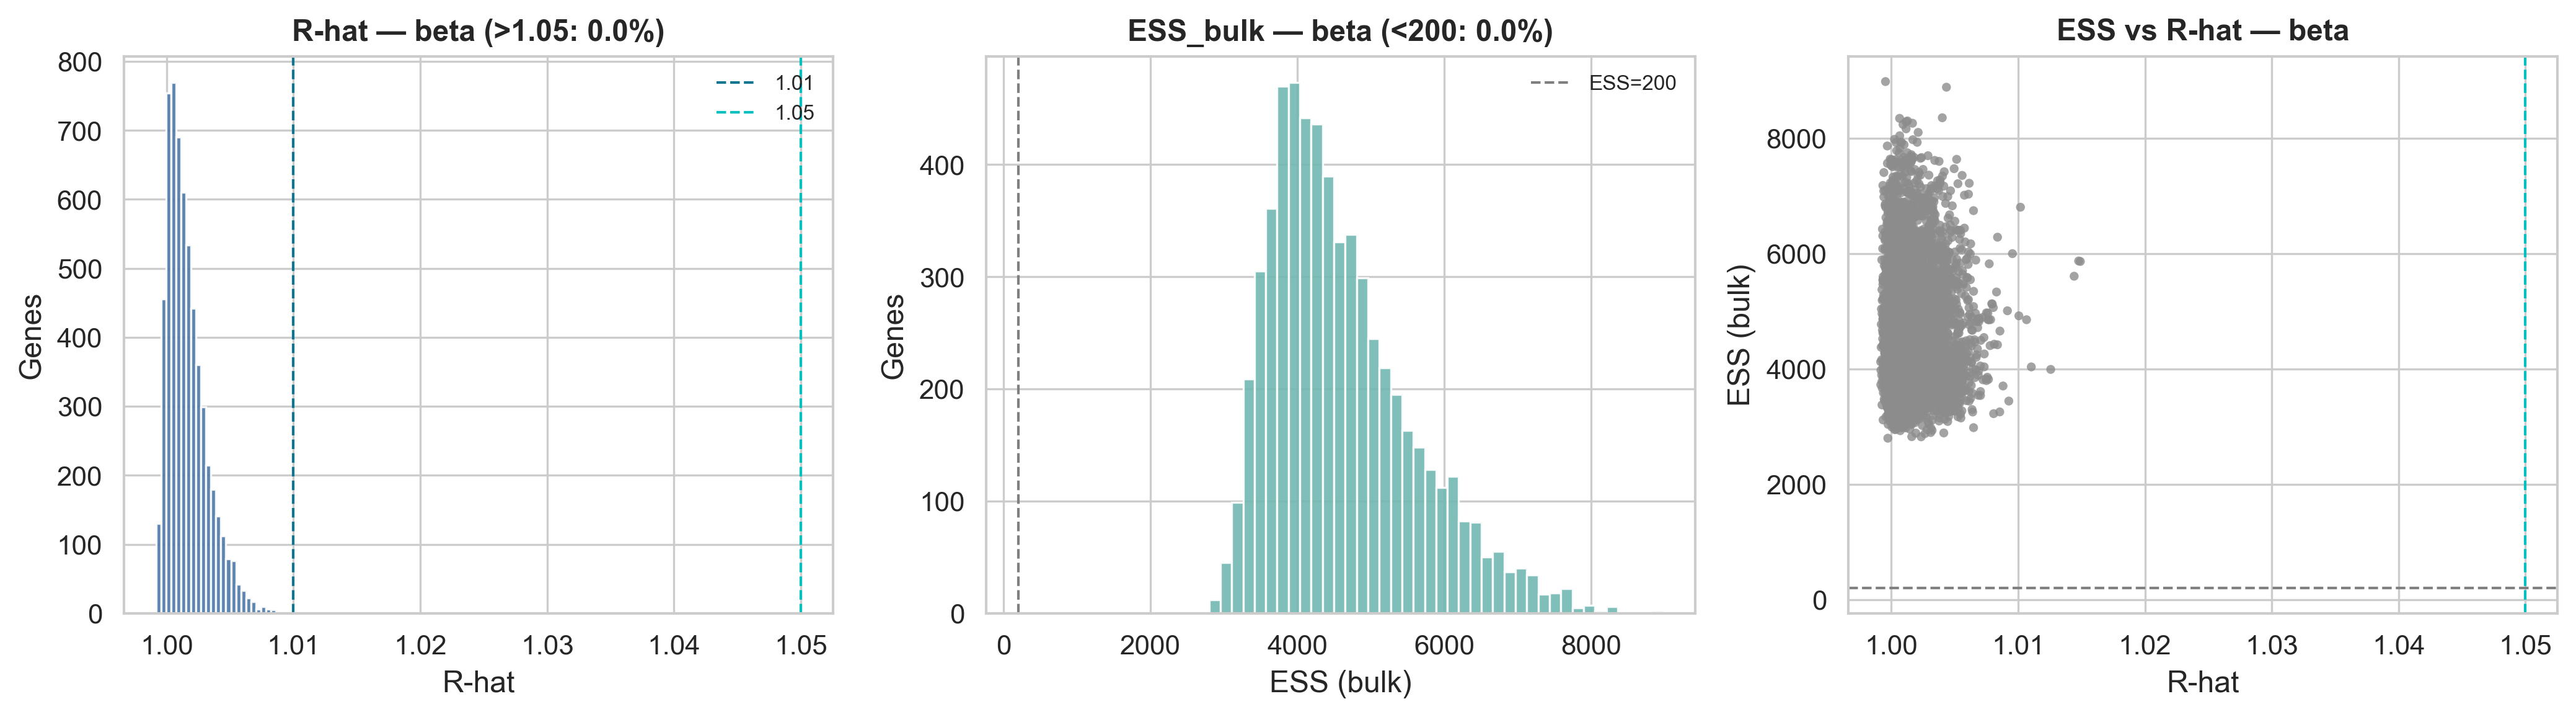

Saved diagnostics figure: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/figures/diagnostic/diagnostics_hbm_nuts_beta_rhat_ess_hist_scatter.png


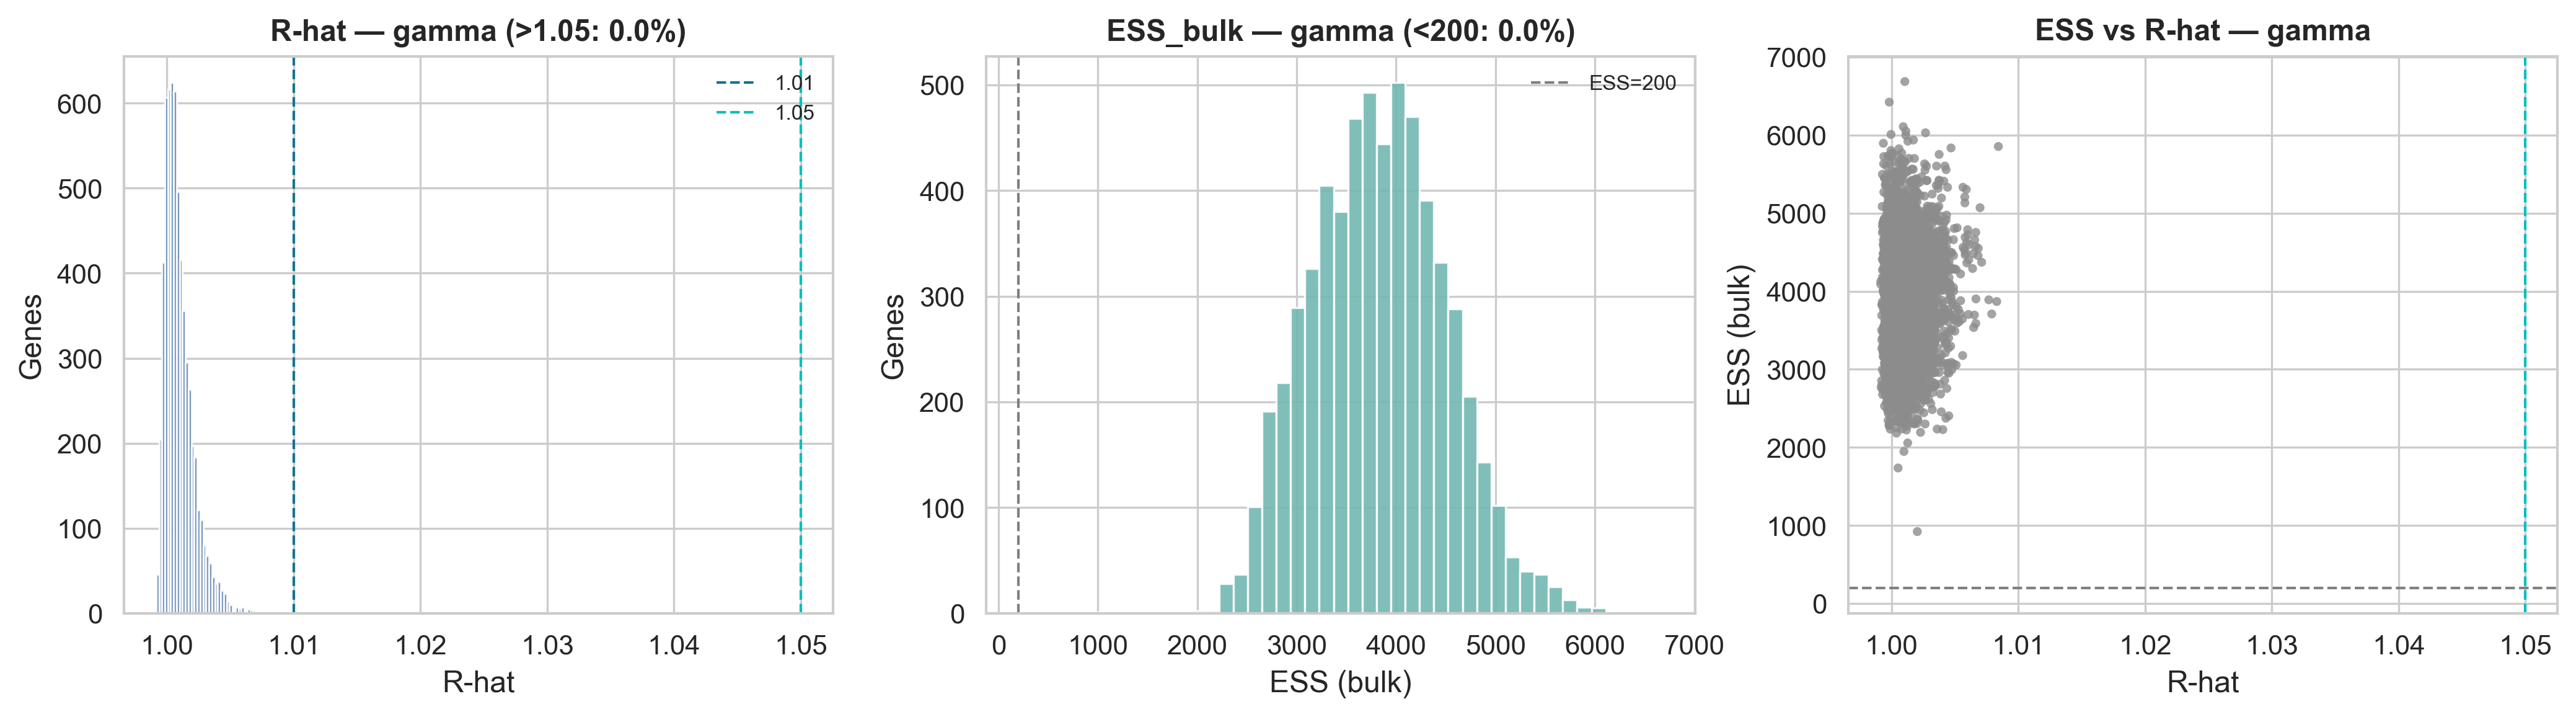

Saved diagnostics figure: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/figures/diagnostic/diagnostics_hbm_nuts_gamma_rhat_ess_hist_scatter.png


,param,gene,rhat,ess_bulk,ess_tail,rhat_issue,ess_issue
0,beta,SETD2,1.003066,4379.032018,1683.734338,False,False
1,beta,RPRD2,1.001576,4645.280116,1767.511703,False,False
2,beta,TMEM30A,0.999856,5029.168916,2186.273699,False,False
3,beta,MAD2L2,0.999834,5317.830282,2072.926870,False,False
4,beta,ARIH1,1.003468,4939.333663,2009.204417,False,False


Saved diagnostics CSV: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/diagnostic/diagnostics_hbm_nuts_rhat_ess.csv
Saved outliers CSV: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/diagnostic/diagnostics_hbm_nuts_rhat_ess_outliers.csv (n=0)


In [28]:
# Diagnostics: per-gene R-hat and ESS for HBM NUTS (supports accumulated idata)
# Computes R-hat and effective sample sizes for gene-level parameters and plots them per gene.
# If an accumulated idata file exists, loads it; otherwise uses current session `idata`.

import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
from pathlib import Path

# Locate output dirs
project_root = globals().get('project_root', Path('..').resolve().parent)
fig_dir = globals().get('fig_dir', project_root / 'outputs' / 'figures')
table_dir = globals().get('table_dir', project_root / 'outputs' / 'tables')
fig_dir.mkdir(parents=True, exist_ok=True)
table_dir.mkdir(parents=True, exist_ok=True)

# Try to load accumulated idata if present
cache_dir = table_dir / 'posterior_cache_hbm_nuts'
accum_path = cache_dir / 'idata_gene_accum.nc'

loaded = False
if accum_path.exists():
    try:
        idata_use = az.from_netcdf(accum_path)
        loaded = True
        print(f"Loaded accumulated idata: {accum_path}")
    except Exception as e:
        print(f"Failed to load accumulated idata ({e}); falling back to in-memory `idata`.")
        idata_use = globals().get('idata', None)
else:
    idata_use = globals().get('idata', None)

# Preconditions
if idata_use is None:
    raise RuntimeError("No `idata` available. Run a HBM NUTS sampling cell or ensure accumulated file exists.")

post = idata_use.posterior

# Determine available gene-level parameter names (beta/gamma variants across cells)
param_candidates = []
for v in ['beta', 'beta_g', 'gamma', 'gamma_g']:
    if v in post.data_vars:
        param_candidates.append(v)

if not param_candidates:
    raise RuntimeError("No gene-level parameters found in posterior. Expected one of: beta, beta_g, gamma, gamma_g.")

# Build gene name mapping, if available
gene_names = None
if 'gene' in post.dims:
    try:
        gene_names = [str(g) for g in post['gene'].values]
    except Exception:
        gene_names = None
elif 'gene_codes' in globals():
    try:
        gene_names = list(pd.Categorical(gene_codes.categories).astype(str))
    except Exception:
        gene_names = None
elif 'genes_in_set' in globals():
    gene_names = [str(g) for g in genes_in_set]
elif 'cats' in globals():
    gene_names = [str(g) for g in cats]

# Helper to coerce a sequence of length G into a Series with gene index if possible
def _to_series(arr_like, name, G):
    arr = np.asarray(arr_like).reshape(-1)
    if gene_names is not None and len(gene_names) == G:
        return pd.Series(arr, index=pd.Index(gene_names, name='gene'), name=name)
    else:
        return pd.Series(arr, index=pd.Index(range(G), name='gene_idx'), name=name)

rows = []
for v in param_candidates:
    # R-hat and ESS (bulk/tail) via ArviZ; result is an xarray DataArray with shape matching parameter dims
    try:
        rhat_da = az.rhat(idata_use, var_names=[v])[v]
        ess_bulk_da = az.ess(idata_use, var_names=[v], method='bulk')[v]
        ess_tail_da = az.ess(idata_use, var_names=[v], method='tail')[v]
    except Exception as e:
        print(f"Skipping {v}: failed to compute diagnostics ({e})")
        continue

    # Convert to numpy arrays
    rhat = np.asarray(rhat_da)
    ess_bulk = np.asarray(ess_bulk_da)
    ess_tail = np.asarray(ess_tail_da)

    # Determine G (genes) from last axis
    if rhat.ndim == 1:
        G = rhat.shape[0]
        rhat_s = _to_series(rhat, 'rhat', G)
        essb_s = _to_series(ess_bulk, 'ess_bulk', G)
        esst_s = _to_series(ess_tail, 'ess_tail', G)
    else:
        # Fallback: flatten
        G = rhat.size
        rhat_s = _to_series(rhat.reshape(-1), 'rhat', G)
        essb_s = _to_series(ess_bulk.reshape(-1), 'ess_bulk', G)
        esst_s = _to_series(ess_tail.reshape(-1), 'ess_tail', G)

    diag_df = pd.concat([rhat_s, essb_s, esst_s], axis=1).reset_index()
    diag_df.insert(0, 'param', v)
    rows.append(diag_df)

    # Flags for thresholds
    RHAT_WARN = 1.05
    ESS_MIN = 200
    rhat_vals = rhat_s.values.astype(float)
    ess_vals = essb_s.values.astype(float)
    flag_rhat = rhat_vals > RHAT_WARN
    flag_ess = ess_vals < ESS_MIN
    frac_rhat = float(np.mean(flag_rhat)) if rhat_vals.size else 0.0
    frac_ess = float(np.mean(flag_ess)) if ess_vals.size else 0.0

    # Figure: histograms + scatter (ESS vs R-hat)
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))

    # Histogram of R-hat
    ax = axes[0]
    ax.hist(rhat_vals[np.isfinite(rhat_vals)], bins=40, color='#4C78A8', alpha=0.9)
    ax.axvline(1.01, color='C0', linestyle='--', linewidth=1, label='1.01')
    ax.axvline(RHAT_WARN, color='C1', linestyle='--', linewidth=1, label=f'{RHAT_WARN}')
    ax.set_xlabel('R-hat')
    ax.set_ylabel('Genes')
    ax.set_title(f'R-hat — {v} (>{RHAT_WARN}: {frac_rhat:.1%})')
    ax.legend(loc='upper right', fontsize=8)

    # Histogram of ESS (bulk)
    ax = axes[1]
    ax.hist(ess_vals[np.isfinite(ess_vals)], bins=40, color='#72B7B2', alpha=0.9)
    ax.axvline(ESS_MIN, color='gray', linestyle='--', linewidth=1, label=f'ESS={ESS_MIN}')
    ax.set_xlabel('ESS (bulk)')
    ax.set_ylabel('Genes')
    ax.set_title(f'ESS_bulk — {v} (<{ESS_MIN}: {frac_ess:.1%})')
    ax.legend(loc='upper right', fontsize=8)

    # Scatter: ESS (bulk) vs R-hat)
    ax = axes[2]
    colors = np.where(flag_rhat | flag_ess, '#d62728', '#8c8c8c')
    ax.scatter(rhat_vals, ess_vals, c=colors, s=12, alpha=0.8, edgecolors='none')
    ax.axvline(RHAT_WARN, color='C1', linestyle='--', linewidth=1)
    ax.axhline(ESS_MIN, color='gray', linestyle='--', linewidth=1)
    ax.set_xlabel('R-hat')
    ax.set_ylabel('ESS (bulk)')
    # Switch to log scale on Y if dynamic range is very large
    try:
        mn = float(np.nanmin(ess_vals[ess_vals>0])) if np.any(ess_vals>0) else 1.0
        mx = float(np.nanmax(ess_vals)) if ess_vals.size else 1.0
        if np.isfinite(mn) and np.isfinite(mx) and mx/mn > 100:
            ax.set_yscale('log')
    except Exception:
        pass
    ax.set_title(f'ESS vs R-hat — {v}')

    plt.tight_layout()
    out_fig = fig_dir / f'diagnostic/diagnostics_hbm_nuts_{v}_rhat_ess_hist_scatter.png'
    plt.savefig(out_fig, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved diagnostics figure: {out_fig}")

# Save combined diagnostics CSV and outliers
if rows:
    out_df = pd.concat(rows, ignore_index=True)
    RHAT_WARN = 1.05
    ESS_MIN = 200
    out_df['rhat_issue'] = out_df['rhat'] > RHAT_WARN
    out_df['ess_issue'] = out_df['ess_bulk'] < ESS_MIN

    # Save full diagnostics
    out_csv = table_dir / 'diagnostic/diagnostics_hbm_nuts_rhat_ess.csv'
    out_df.to_csv(out_csv, index=False)

    # Save outliers (any issue)
    outliers = out_df[(out_df['rhat_issue']) | (out_df['ess_issue'])].copy()
    outliers_path = table_dir / 'diagnostic/diagnostics_hbm_nuts_rhat_ess_outliers.csv'
    outliers.to_csv(outliers_path, index=False)

    # Preview
    display(out_df.head())
    print(f"Saved diagnostics CSV: {out_csv}")
    print(f"Saved outliers CSV: {outliers_path} (n={len(outliers)})")
else:
    print("No diagnostics computed (no matching parameters present).")

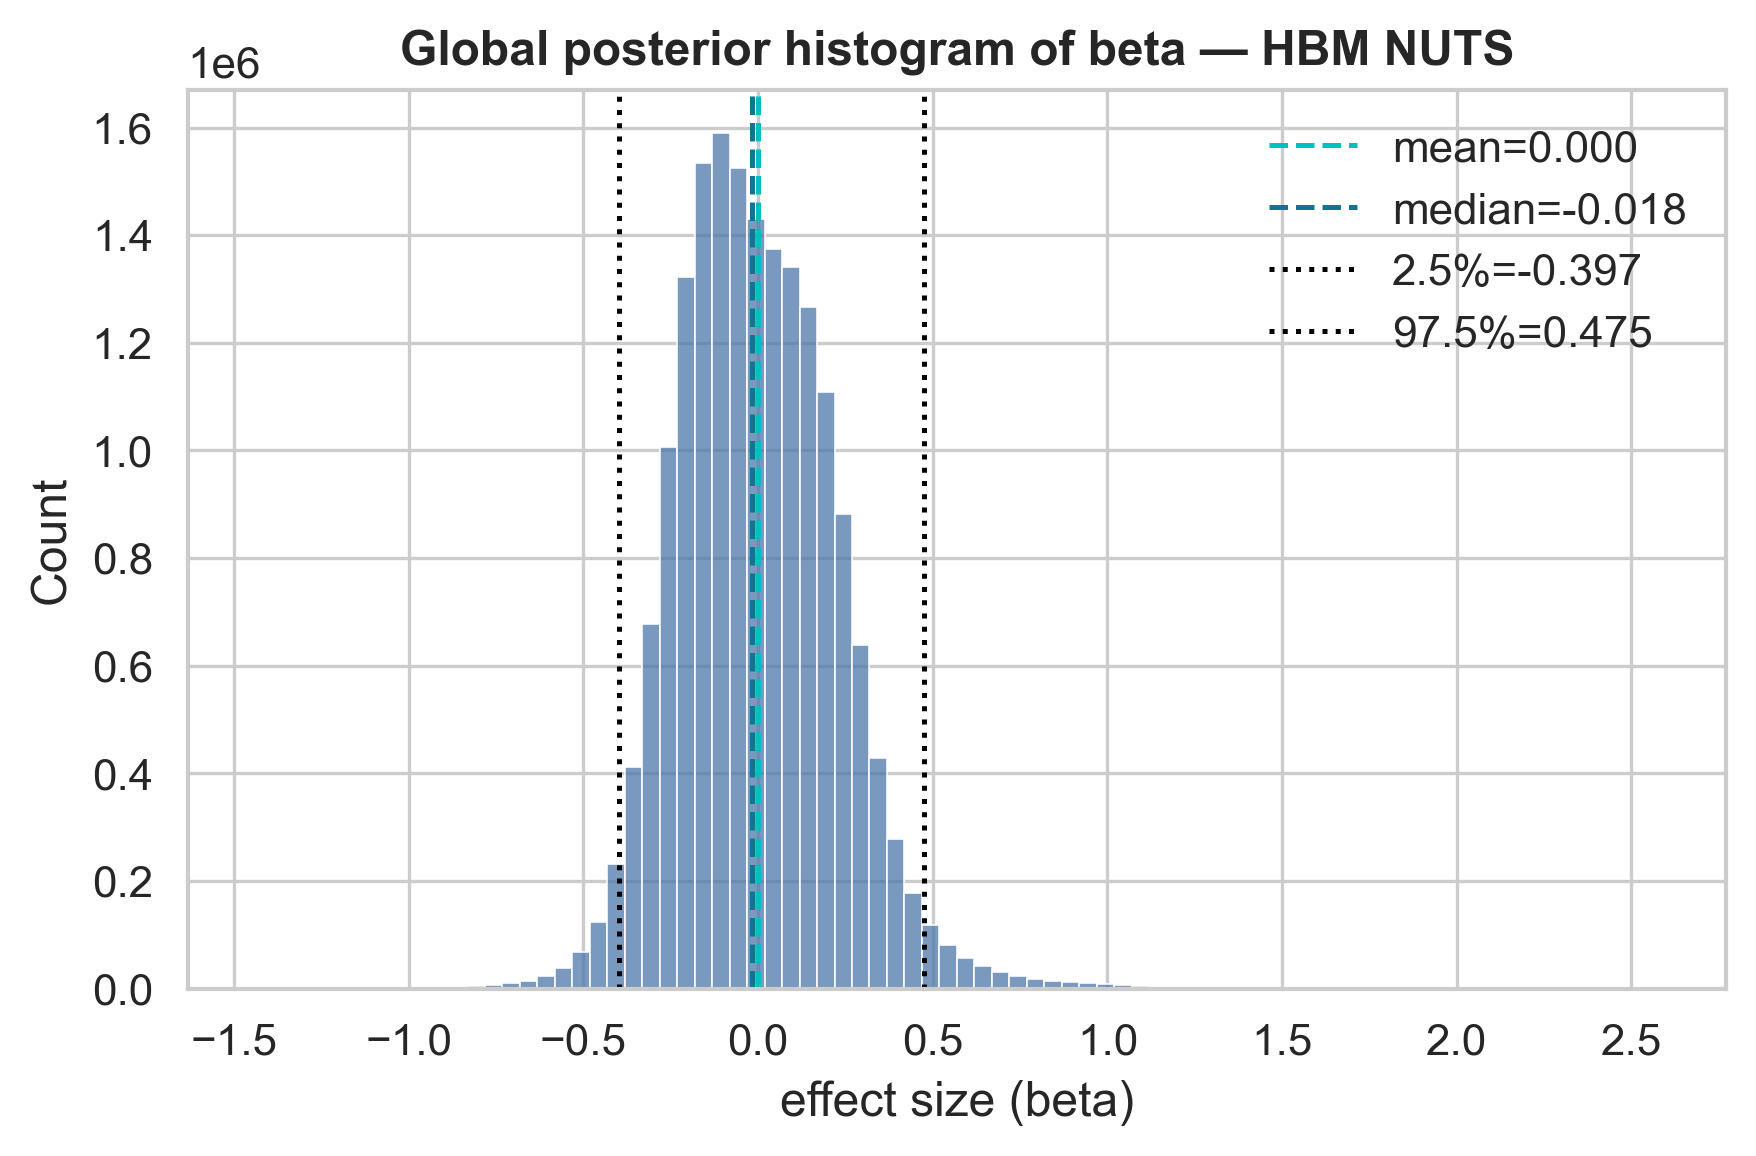

Saved global posterior histogram: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/figures/posterior_hist_global_hbm_nuts.png


In [13]:
# Global histogram of beta for HBM NUTS (aggregate per-gene and batch caches)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.2)

project_root = globals().get('project_root', Path('..').resolve().parent)
table_dir = globals().get('table_dir', project_root / 'outputs' / 'tables')
fig_dir = globals().get('fig_dir', project_root / 'outputs' / 'figures')
fig_dir.mkdir(parents=True, exist_ok=True)
posterior_cache_dir = table_dir / 'posterior_cache_hbm_nuts'

if not posterior_cache_dir.exists():
    raise FileNotFoundError(f"Missing posterior cache dir: {posterior_cache_dir}. Run NUTS sampling first.")

all_draws = []
cache_files = sorted(posterior_cache_dir.glob('beta_draws_*.npz'))
if not cache_files:
    # legacy single-file
    cache_files = [posterior_cache_dir / 'beta_draws_nuts_subset.npz']

for npz_path in cache_files:
    try:
        z = np.load(npz_path, allow_pickle=True)
        if 'beta' in z and 'genes' in z:
            beta = np.asarray(z['beta'])
            if beta.ndim == 1:
                beta = beta.reshape(-1, 1)
            all_draws.append(beta.reshape(-1))
        elif 'beta' in z:
            beta = np.asarray(z['beta']).reshape(-1)
            all_draws.append(beta)
        else:
            print(f"[warn] skipping cache without beta: {npz_path}")
    except Exception as e:
        print(f"[warn] failed to read {npz_path}: {e}")

if not all_draws:
    raise RuntimeError("No beta draws found in caches. Run NUTS sampler to generate per-gene NPZ files.")

beta_flat = np.concatenate(all_draws).astype(float)
m_mean = float(np.mean(beta_flat))
m_med = float(np.median(beta_flat))
lo, hi = np.quantile(beta_flat, [0.025, 0.975])

plt.figure(figsize=(6,4))
sns.histplot(beta_flat, bins=80, kde=False, color='#4C78A8')
plt.axvline(m_mean, color='C1', linestyle='--', label=f'mean={m_mean:.3f}')
plt.axvline(m_med, color='C0', linestyle='--', label=f'median={m_med:.3f}')
plt.axvline(lo, color='k', linestyle=':', label=f'2.5%={lo:.3f}')
plt.axvline(hi, color='k', linestyle=':', label=f'97.5%={hi:.3f}')
plt.title('Global posterior histogram of beta — HBM NUTS')
plt.xlabel('effect size (beta)')
plt.legend()
out_path = fig_dir / 'posterior_hist_global_hbm_nuts.png'
plt.tight_layout()
plt.savefig(out_path, dpi=150)
plt.show()
print(f"Saved global posterior histogram: {out_path}")

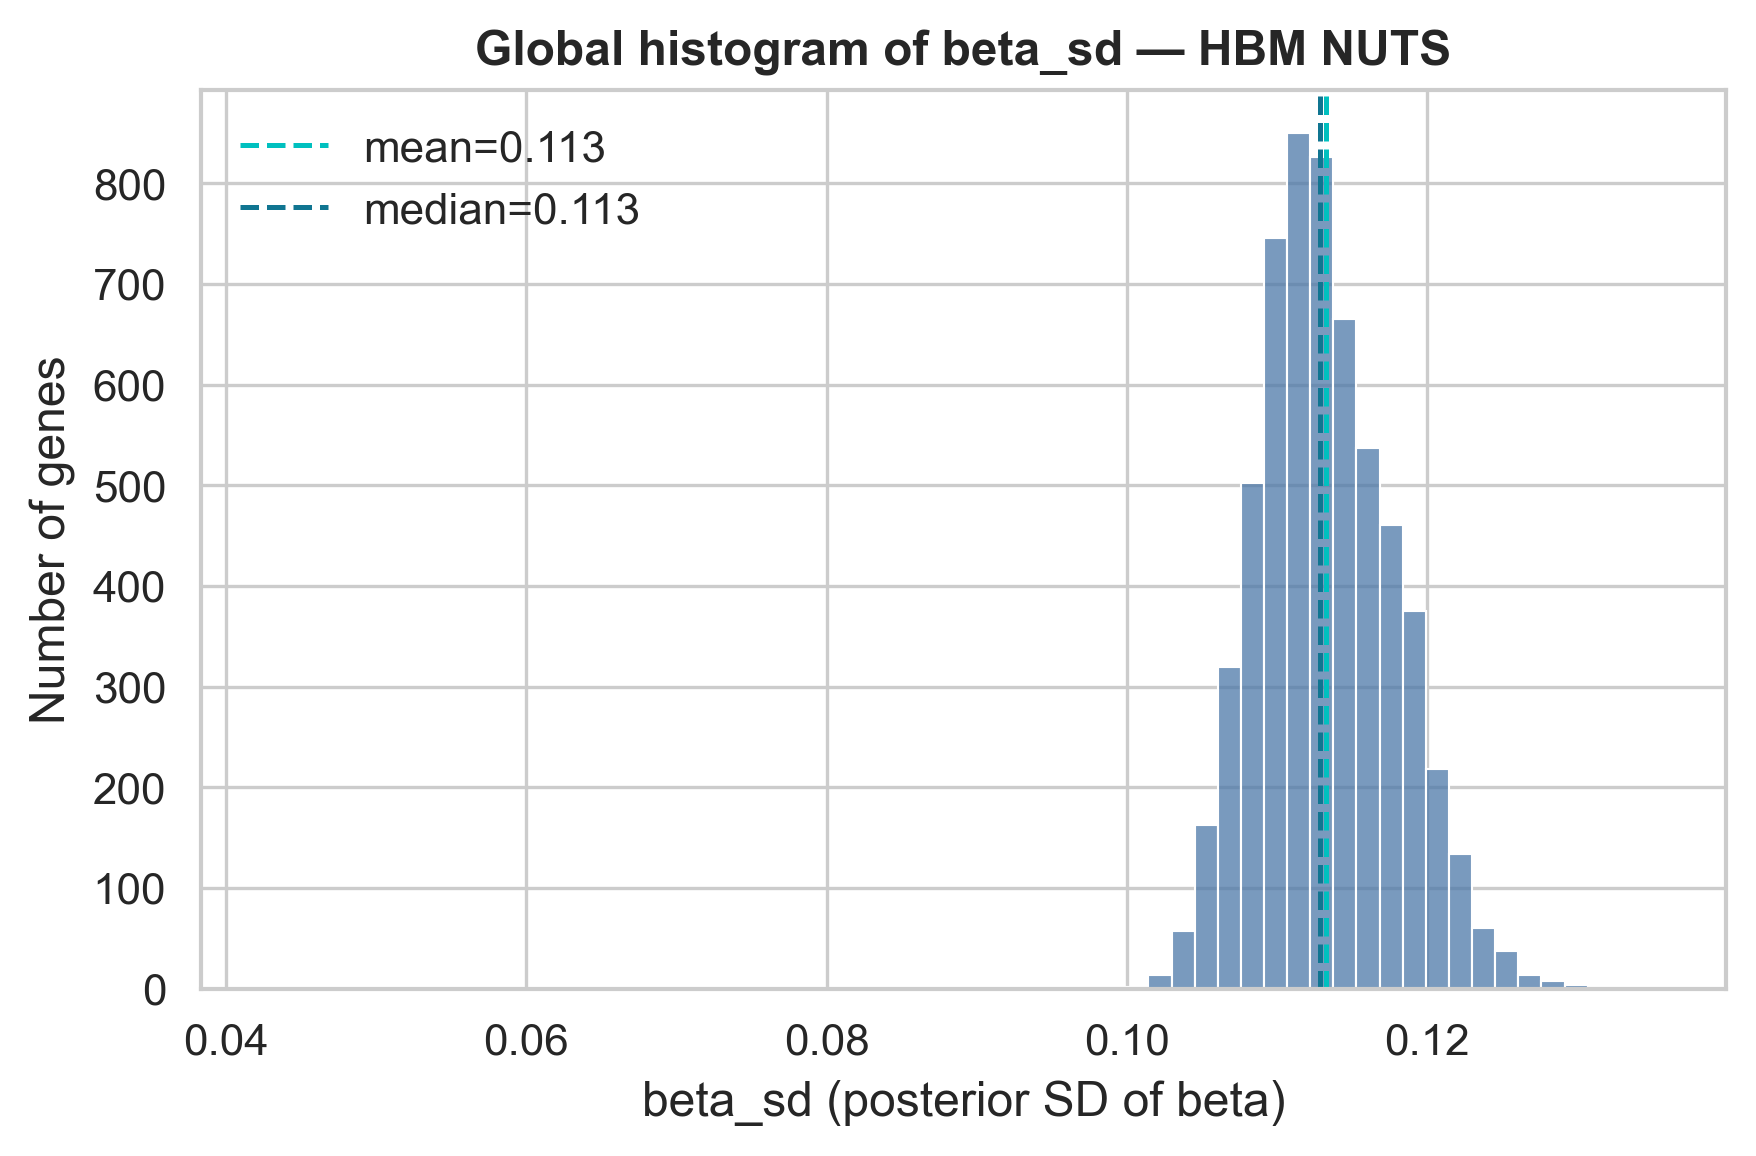

Saved beta_sd global histogram: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/figures/beta_sd_hist_global_hbm_nuts.png


In [15]:
# Global histogram of beta_sd for HBM NUTS across genes
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_style('whitegrid')

project_root = globals().get('project_root', Path('..').resolve().parent)
table_dir = globals().get('table_dir', project_root / 'outputs' / 'tables')
fig_dir = globals().get('fig_dir', project_root / 'outputs' / 'figures')
fig_dir.mkdir(parents=True, exist_ok=True)

nuts_summary_path = table_dir / 'bayes_gene_summary_hbm_nuts.csv'
if not nuts_summary_path.exists():
    raise FileNotFoundError(f"Missing NUTS summary: {nuts_summary_path}")

sum_df = pd.read_csv(nuts_summary_path)
col = None
for cand in ['beta_sd_nuts', 'beta_sd']:
    if cand in sum_df.columns:
        col = cand
        break
if col is None:
    raise ValueError("NUTS summary missing beta_sd column ('beta_sd_nuts' or 'beta_sd').")

sd = sum_df[col].astype(float).replace([np.inf, -np.inf], np.nan).dropna().values
if sd.size == 0:
    raise RuntimeError("No finite beta_sd values found in NUTS summary.")

m_mean = float(np.mean(sd))
m_med = float(np.median(sd))

plt.figure(figsize=(6,4))
sns.histplot(sd, bins=60, kde=False, color='#4C78A8')
plt.axvline(m_mean, color='C1', linestyle='--', label=f'mean={m_mean:.3f}')
plt.axvline(m_med, color='C0', linestyle='--', label=f'median={m_med:.3f}')
plt.title('Global histogram of beta_sd — HBM NUTS')
plt.xlabel('beta_sd (posterior SD of beta)')
plt.ylabel('Number of genes')
plt.legend()
out_path = fig_dir / 'beta_sd_hist_global_hbm_nuts.png'
plt.tight_layout()
plt.savefig(out_path, dpi=150)
plt.show()
print(f"Saved beta_sd global histogram: {out_path}")

## Global parameter diagnostics: tau_beta, tau_u, phi

This cell loads the cumulative ArviZ summary (`outputs/tables/diagnostic/summary_all.csv`) and checks MCMC diagnostics for the global parameters tau_beta, tau_u, and phi across batches.

In [48]:
# Diagnose global parameters using cumulative summary from ArviZ (robust project root & column detection)
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

# Robust project root finder: look for common repository markers
def find_project_root(start: Path = None, markers=('outputs', 'README.md', 'requirements.txt', '.git')) -> Path:
    p = Path.cwd() if start is None else Path(start)
    p = p.resolve()
    while True:
        for m in markers:
            if (p / m).exists():
                return p
        if p.parent == p:
            # reached filesystem root
            return None
        p = p.parent

project_root = find_project_root()
if project_root is None:
    # Fallback: try two levels up from notebook working dir
    candidate = Path.cwd().parents[1] if len(Path.cwd().parents) > 1 else Path.cwd()
    print(f"Warning: repository root markers not found while searching upwards from {Path.cwd()}. Falling back to {candidate}")
    project_root = candidate

# Paths for diagnostics
table_dir = project_root / 'outputs' / 'tables' / 'diagnostic'
fig_dir = project_root / 'outputs' / 'figures' / 'diagnostic'
summary_path = table_dir / 'summary_all.csv'
fig_dir.mkdir(parents=True, exist_ok=True)

# Thresholds (reuse notebook globals if present)
RHAT_WARN = globals().get('RHAT_WARN', 1.05)
ESS_MIN = globals().get('ESS_MIN', 400)

# Load cumulative summary
if not summary_path.exists():
    print(f"ERROR: Cumulative ArviZ summary not found at expected path: {summary_path}")
    print("Check that you have run at least one batch and that diagnostic summaries were written to outputs/tables/diagnostic/summary_all.csv")
    raise FileNotFoundError(f"Cumulative ArviZ summary not found: {summary_path}")

df = pd.read_csv(summary_path)

# Robust, case-insensitive column detection
cols_lower = {c.lower(): c for c in df.columns}

def find_col(possible_names):
    for name in possible_names:
        if name.lower() in cols_lower:
            return cols_lower[name.lower()]
    # try loose matches (remove punctuation/underscores/spaces)
    simple = {k.replace('_','').replace('-','').replace(' ','').lower(): v for k,v in cols_lower.items()}
    for name in possible_names:
        key = name.lower().replace('_','').replace('-','').replace(' ','')
        if key in simple:
            return simple[key]
    return None

# possible variants
var_col = find_col(['var_name', 'index', 'param'])
rhat_col = find_col(['r_hat', 'rhat', 'r-hat'])
essb_col = find_col(['ess_bulk', 'essbulk', 'ess_bulk'])
esst_col = find_col(['ess_tail', 'esstail', 'ess_tail'])
batch_col = find_col(['batch', 'batch_no', 'batchno', 'batch_no'])
mean_col = find_col(['mean', 'value'])

if var_col is None or rhat_col is None or (essb_col is None and esst_col is None):
    print("Found columns:", df.columns.tolist())
    missing = []
    if var_col is None: missing.append('var_name/index/param')
    if rhat_col is None: missing.append('r_hat/rhat')
    if essb_col is None and esst_col is None: missing.append('ess_bulk or ess_tail')
    raise ValueError(f"summary_all.csv is missing required columns: {', '.join(missing)}")

# Keep only globals of interest
keep = ['tau_beta', 'tau_u', 'phi']
df = df[df[var_col].isin(keep)].copy()
if df.empty:
    raise ValueError("Global parameters tau_beta, tau_u, phi not found in summary_all.csv")

# If batch is missing, infer sequential batch index per var based on appearance order
if batch_col is None:
    df['_row'] = np.arange(len(df))
    df['batch'] = df.groupby(var_col)['_row'].rank(method='first').astype(int)
    batch_col = 'batch'

# Ensure numeric columns are numeric (coerce errors)
for c in [rhat_col, essb_col, esst_col, mean_col, batch_col]:
    if c and c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Aggregate if multiple rows per (var, batch) exist (take conservative summaries)
agg = {rhat_col: 'max'}
if essb_col:
    agg[essb_col] = 'min'
if esst_col:
    agg[esst_col] = 'min'
if mean_col:
    agg[mean_col] = 'mean'

dg = df.groupby([var_col, batch_col], as_index=False).agg(agg).sort_values([var_col, batch_col])

# Latest batch PASS/FAIL per var
latest = dg.groupby(var_col, as_index=False).tail(1).copy()
latest['flag_rhat'] = latest[rhat_col] > RHAT_WARN
if essb_col:
    latest['flag_ess_bulk'] = latest[essb_col] < ESS_MIN
else:
    latest['flag_ess_bulk'] = False
if esst_col:
    latest['flag_ess_tail'] = latest[esst_col] < ESS_MIN
else:
    latest['flag_ess_tail'] = False

latest['PASS'] = ~(latest['flag_rhat'] | latest['flag_ess_bulk'] | latest['flag_ess_tail'])

# VARIABILITY ACROSS BATCHES: compute stats for 'mean' (parameter estimate) and for r_hat/ess
var_stats = []
for v, sub in dg.groupby(var_col):
    row = {'param': v}
    # mean stats
    if mean_col and mean_col in sub.columns:
        mvals = sub[mean_col].dropna()
        if len(mvals)>0:
            row.update({
                'mean_of_mean': float(mvals.mean()),
                'std_of_mean': float(mvals.std(ddof=0)),
                'range_of_mean': float(mvals.max()-mvals.min()),
                'pct_change_mean': float((mvals.max()-mvals.min())/abs(mvals.mean()) if mvals.mean()!=0 else np.nan)
            })
        else:
            row.update({'mean_of_mean': np.nan,'std_of_mean': np.nan,'range_of_mean': np.nan,'pct_change_mean': np.nan})
    else:
        row.update({'mean_of_mean': np.nan,'std_of_mean': np.nan,'range_of_mean': np.nan,'pct_change_mean': np.nan})
    # rhat stats
    rhvals = sub[rhat_col].dropna()
    if len(rhvals)>0:
        row.update({
            'rhat_mean': float(rhvals.mean()),
            'rhat_std': float(rhvals.std(ddof=0)),
            'rhat_range': float(rhvals.max()-rhvals.min())
        })
    else:
        row.update({'rhat_mean': np.nan,'rhat_std': np.nan,'rhat_range': np.nan})
    # ess bulk stats
    if essb_col and essb_col in sub.columns:
        e = sub[essb_col].dropna()
        row.update({
            'ess_bulk_mean': float(e.mean()) if len(e)>0 else np.nan,
            'ess_bulk_std': float(e.std(ddof=0)) if len(e)>0 else np.nan,
            'ess_bulk_range': float(e.max()-e.min()) if len(e)>0 else np.nan
        })
    else:
        row.update({'ess_bulk_mean': np.nan,'ess_bulk_std': np.nan,'ess_bulk_range': np.nan})
    var_stats.append(row)

var_df = pd.DataFrame(var_stats).set_index('param')
# Save variation summary
var_out = table_dir / 'global_params_variation.csv'
var_df.to_csv(var_out)
print(f"Saved global parameter variation summary to {var_out}")
print(var_df)


Saved global parameter variation summary to /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/diagnostic/global_params_variation.csv
          mean_of_mean  std_of_mean  range_of_mean  pct_change_mean  rhat_mean  rhat_std  rhat_range  ess_bulk_mean  ess_bulk_std  ess_bulk_range
param                                                                                                                                            
phi            16.3135     0.676602          2.565         0.157232        1.0       0.0         0.0         2024.5    337.515407          1241.0
tau_beta        0.2384     0.020441          0.071         0.297819        1.0       0.0         0.0         3624.9    363.339910          1475.0
tau_u           0.6309     0.015783          0.057         0.090347        1.0       0.0         0.0         1575.0    223.416651           748.0


In [16]:
# Hit calling for HBM NUTS results (using exact posterior draws)
import pandas as pd
import numpy as np
from pathlib import Path

# IO paths
project_root = globals().get('project_root', Path('..').resolve().parent)
table_dir = globals().get('table_dir', project_root / 'outputs' / 'tables')
summary_path = table_dir / 'bayes_gene_summary_hbm_nuts.csv'
posterior_cache_dir = table_dir / 'posterior_cache_hbm_nuts'

if not summary_path.exists():
    raise FileNotFoundError(f"Missing NUTS summary: {summary_path}. Run the NUTS refinement cell first.")
if not posterior_cache_dir.exists():
    raise FileNotFoundError(f"Missing posterior cache dir: {posterior_cache_dir}. Run the NUTS refinement cell to save caches.")

# Load summary
gsum = pd.read_csv(summary_path)
if 'gene' not in gsum.columns:
    raise ValueError('NUTS summary must include gene column')

genes = gsum['gene'].astype(str).tolist()

# Decision thresholds (same as VI)
LFSR_MAX = .05
BETA_ABS_THRESH = 0.3
ALT_ABS_THRESH = 0.5
PROB_MIN = 0.85

# Gather exact posterior draws from NUTS cache file(s)
beta_draws_map = {}
cache_files = sorted(posterior_cache_dir.glob('beta_draws_*.npz'))
if not cache_files:
    # Backward-compat single-file cache
    cache_files = [posterior_cache_dir / 'beta_draws_nuts_subset.npz']

for npz_path in cache_files:
    if not npz_path.exists():
        continue
    try:
        z = np.load(npz_path, allow_pickle=True)
        # Batch caches: expect 'beta' (draws x G) and 'genes' (G)
        if 'beta' in z and 'genes' in z:
            beta = z['beta']
            genes_batch = [str(g) for g in np.array(z['genes']).tolist()]
            # If 1-D beta (per-gene cache), expand dims to (draws, 1)
            if beta.ndim == 1:
                beta = beta.reshape(-1, 1)
            if beta.shape[-1] != len(genes_batch):
                print(f"Warning: beta shape {beta.shape} mismatches genes ({len(genes_batch)}) in {npz_path}")
            for j, g in enumerate(genes_batch):
                if j < beta.shape[-1]:
                    beta_draws_map[g] = beta[:, j]
        # Per-gene caches with explicit 'gene' key
        elif 'beta' in z and 'gene' in z:
            beta = z['beta']
            gene_name = str(np.array(z['gene']).tolist()[0])
            beta_draws_map[gene_name] = beta.reshape(-1)
        # Per-gene caches without 'gene' key (infer from filename: beta_draws_{GENE}.npz)
        elif 'beta' in z:
            beta = z['beta']
            stem = npz_path.stem
            gene_name = stem.replace('beta_draws_', '', 1)
            if not gene_name or gene_name == stem:
                print(f"Warning: could not infer gene from filename: {npz_path}")
                continue
            beta_draws_map[str(gene_name)] = beta.reshape(-1)
        else:
            print(f"Warning: cache missing expected arrays: {npz_path}")
    except Exception as e:
        print(f"Warning: failed to read cache {npz_path}: {e}")

if not beta_draws_map:
    raise RuntimeError("No posterior draws found for NUTS. Re-run the NUTS refinement cell to generate caches.")

# Overlap diagnostics
genes_set = set(genes)
cache_set = set(beta_draws_map.keys())
common_genes = sorted(genes_set & cache_set)
print(f"Genes in NUTS summary: {len(genes_set):,}; with draws: {len(cache_set):,}; overlap: {len(common_genes):,}")

# Compute probabilities from draws
p_abs_main = []   # P(|beta| >= 0.3)
p_abs_alt = []    # P(|beta| >= 0.5)
p_pos = []
p_neg = []
psp_draws = []
lfsr_draws = []

for g in genes:
    draws = beta_draws_map.get(g)
    if draws is None or len(draws) == 0:
        p_abs_main.append(np.nan)
        p_abs_alt.append(np.nan)
        p_pos.append(np.nan)
        p_neg.append(np.nan)
        psp_draws.append(np.nan)
        lfsr_draws.append(np.nan)
    else:
        d = np.asarray(draws, dtype=float)
        p_abs_main.append(float((np.abs(d) >= BETA_ABS_THRESH).mean()))
        p_abs_alt.append(float((np.abs(d) >= ALT_ABS_THRESH).mean()))
        p_pos_val = float((d > 0).mean())
        p_pos.append(p_pos_val)
        p_neg.append(float((d < 0).mean()))
        psp_draws.append(p_pos_val)
        lfsr_draws.append(float(min(p_pos_val, 1.0 - p_pos_val)))

# Attach to summary
gsum = gsum.copy()
gsum['p_abs_beta_ge_0_3'] = p_abs_main
gsum['p_abs_beta_ge_0_5'] = p_abs_alt
gsum['p_beta_gt_0'] = p_pos
gsum['p_beta_lt_0'] = p_neg
gsum['psp_draws'] = psp_draws
gsum['lfsr_draws'] = lfsr_draws

# Hit rule: same as VI, but using draw-based lfsr and P(|beta| >= 0.3)
gsum['hit'] = (gsum['lfsr_draws'] <= LFSR_MAX) & (gsum['p_abs_beta_ge_0_3'] >= PROB_MIN)

# Save outputs
out_hits = table_dir / 'hits_hbm_nuts.csv'
gsum.to_csv(out_hits, index=False)
print(
    f"Saved NUTS-based hits: {out_hits}\n"
    f"  criteria: lfsr_draws <= {LFSR_MAX}, P(|beta|>={BETA_ABS_THRESH}) >= {PROB_MIN}"
)

aug_summary = table_dir / 'bayes_gene_summary_hbm_nuts_with_probs.csv'
cols_pref = [
    'gene','beta_mean_nuts','beta_sd_nuts','psp_nuts','lfsr_nuts',
    'psp_draws','lfsr_draws','p_beta_gt_0','p_beta_lt_0','p_abs_beta_ge_0_3','p_abs_beta_ge_0_5',
    'n_obs','n_sgrna','n_sample','chains','draws','tune','hit'
]
cols_exist = [c for c in cols_pref if c in gsum.columns]
gsum[cols_exist].to_csv(aug_summary, index=False)
print(f"Wrote augmented NUTS summary with probabilities: {aug_summary}")

# Diagnostics
n_total = len(gsum)
n_with_draws = int(np.isfinite(gsum['lfsr_draws']).sum())
n_pass_lfsr = int((gsum['lfsr_draws'] <= LFSR_MAX).sum())
n_pass_prob = int((gsum['p_abs_beta_ge_0_3'] >= PROB_MIN).sum())
n_hits = int(gsum['hit'].sum())
print(
    f"Diagnostics — total genes: {n_total}, with draws: {n_with_draws},\n"
    f"  pass lfsr_draws: {n_pass_lfsr}, pass P(|beta|>={BETA_ABS_THRESH}): {n_pass_prob}, hits: {n_hits}"
)
if n_hits:
    display(gsum.loc[gsum['hit']].sort_values(['lfsr_draws','p_abs_beta_ge_0_3'], ascending=[True, False]).head(20))
else:
    dbg = gsum.sort_values(['lfsr_draws', 'p_abs_beta_ge_0_3'], ascending=[True, False]).head(20)
    display(dbg[['gene'] + [c for c in ['beta_mean_nuts','lfsr_draws','p_abs_beta_ge_0_3','p_beta_gt_0','p_beta_lt_0'] if c in dbg.columns]])

Genes in NUTS summary: 6,000; with draws: 6,000; overlap: 6,000
Saved NUTS-based hits: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/hits_hbm_nuts.csv
  criteria: lfsr_draws <= 0.05, P(|beta|>=0.3) >= 0.85
Wrote augmented NUTS summary with probabilities: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/bayes_gene_summary_hbm_nuts_with_probs.csv
Diagnostics — total genes: 6000, with draws: 6000,
  pass lfsr_draws: 1620, pass P(|beta|>=0.3): 211, hits: 211
Saved NUTS-based hits: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/hits_hbm_nuts.csv
  criteria: lfsr_draws <= 0.05, P(|beta|>=0.3) >= 0.85
Wrote augmented NUTS summary with probabilities: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/bayes_gene_summary_hbm_nuts_with_probs.csv
Diagnostics — total genes: 6000, with draws: 6000,
  pass lfsr_draws: 1620, pass P(|beta|>=0.3): 211, hits: 211


,gene,beta_sd_nuts,eb_mu_logphi_batch,eb_tau_beta_scale,chains,psp_nuts,eb_sigma_logphi,draws,n_obs,lfsr_nuts,n_sample,tune,eb_tau_u_scale,batch_no,n_sgrna,beta_mean_nuts,p_abs_beta_ge_0_3,p_abs_beta_ge_0_5,p_beta_gt_0,p_beta_lt_0,psp_draws,lfsr_draws,hit
155,ALG1,0.117583,1.555696,0.114945,3,1.0,0.708447,1000,16,0.0,4,1500,0.468426,8,4,0.720076,1.0,0.971000,1.0,0.0,1.0,0.0,True
160,ALG13,0.117546,1.562711,0.114945,3,1.0,0.708447,1000,16,0.0,4,1500,0.468426,2,4,0.854735,1.0,0.998333,1.0,0.0,1.0,0.0,True
163,ALG2,0.118343,1.555696,0.114945,3,1.0,0.708447,1000,16,0.0,4,1500,0.468426,8,4,1.173906,1.0,1.000000,1.0,0.0,1.0,0.0,True
207,ANKRD17,0.125760,1.555696,0.114945,3,0.0,0.708447,1000,16,0.0,4,1500,0.468426,8,4,-0.727699,1.0,0.969667,0.0,1.0,0.0,0.0,True
305,ARID1A,0.122486,1.555696,0.114945,3,1.0,0.708447,1000,16,0.0,4,1500,0.468426,8,4,1.123311,1.0,1.000000,1.0,0.0,1.0,0.0,True
731,CBFB,0.117825,1.556194,0.114945,3,1.0,0.708447,1000,16,0.0,4,1500,0.468426,9,4,0.848555,1.0,0.998000,1.0,0.0,1.0,0.0,True
831,CD3D,0.119061,1.570686,0.114945,3,1.0,0.708447,1000,16,0.0,4,1500,0.468426,1,4,1.248412,1.0,1.000000,1.0,0.0,1.0,0.0,True
832,CD3E,0.123911,1.550234,0.114945,3,1.0,0.708447,1000,16,0.0,4,1500,0.468426,4,4,0.877563,1.0,0.999000,1.0,0.0,1.0,0.0,True
850,CDC37,0.122877,1.550234,0.114945,3,1.0,0.708447,1000,16,0.0,4,1500,0.468426,4,4,0.727323,1.0,0.969000,1.0,0.0,1.0,0.0,True
1214,DAD1,0.125376,1.556194,0.114945,3,1.0,0.708447,1000,16,0.0,4,1500,0.468426,9,4,2.104356,1.0,1.000000,1.0,0.0,1.0,0.0,True


In [17]:
# Filter NUTS summary to hits only before overlap comparison
import pandas as pd
import numpy as np
from pathlib import Path

project_root = globals().get('project_root', Path('..').resolve().parent)
table_dir = globals().get('table_dir', project_root / 'outputs' / 'tables')

hits_path = table_dir / 'hits_hbm_nuts.csv'
bench_hits_path = table_dir / 'bench_mageck_hits.csv'

nuts = pd.read_csv(hits_path)
mg = pd.read_csv(bench_hits_path)

# Keep only NUTS hits where 'hit' is True if present; fallback to lfsr/prob rule if needed
if 'hit' in nuts.columns:
    nuts_hits = nuts.loc[nuts['hit'] == True].copy()
else:
    # fallback rule mirroring our hit-calling defaults
    LFSR_MAX = 0.05
    PROB_MIN = 0.95
    col_lfsr = 'lfsr_draws' if 'lfsr_draws' in nuts.columns else ('lfsr_nuts' if 'lfsr_nuts' in nuts.columns else None)
    col_prob = 'p_abs_beta_ge_0_3' if 'p_abs_beta_ge_0_3' in nuts.columns else None
    if col_lfsr is None or col_prob is None:
        raise ValueError("Cannot infer hits from NUTS table: missing 'hit' or required lfsr/prob columns.")
    nuts_hits = nuts.loc[(nuts[col_lfsr] <= LFSR_MAX) & (nuts[col_prob] >= PROB_MIN)].copy()

# Normalize gene column
for df in (nuts_hits, mg):
    if 'gene' not in df.columns:
        raise ValueError('Expected a gene column in hits files')
    df['gene'] = df['gene'].astype(str).str.strip()

A = set(nuts_hits['gene'])
B = set(mg['gene'])

common_genes = sorted(A & B)
nuts_only = sorted(A - B)
mageck_only = sorted(B - A)

print(f"Counts (after filtering to NUTS hits) — common: {len(common_genes)}, NUTS-only: {len(nuts_only)}, MAGeCK-only: {len(mageck_only)}")

# Save outputs
out_common = table_dir / 'overlap_hits_common_hbm_nuts_mageck.csv'
out_nuts_only = table_dir / 'overlap_hits_hbm_nuts_only.csv'
out_mageck_only = table_dir / 'overlap_hits_mageck_only.csv'

pd.DataFrame({'gene': common_genes}).to_csv(out_common, index=False)
pd.DataFrame({'gene': nuts_only}).to_csv(out_nuts_only, index=False)
pd.DataFrame({'gene': mageck_only}).to_csv(out_mageck_only, index=False)

print(f"Saved overlap files (NUTS hits only):\n  common -> {out_common}\n  nuts-only -> {out_nuts_only}\n  mageck-only -> {out_mageck_only}")

# Preview
display(pd.DataFrame({'gene': common_genes}))
display(pd.DataFrame({'gene': nuts_only}))
display(pd.DataFrame({'gene': mageck_only}))

Counts (after filtering to NUTS hits) — common: 180, NUTS-only: 31, MAGeCK-only: 59
Saved overlap files (NUTS hits only):
  common -> /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/overlap_hits_common_hbm_nuts_mageck.csv
  nuts-only -> /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/overlap_hits_hbm_nuts_only.csv
  mageck-only -> /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/overlap_hits_mageck_only.csv


,gene
0,AIP
1,ALDOA
2,ALG1
3,ALG11
4,ALG13
...,...
175,ZAP70
176,ZBTB7B
177,ZC3H12A
178,ZC3H18


,gene
0,C17orf70
1,CD28
2,CD3G
3,CSNK2A1
4,DCAF7
5,EIF3A
6,EIF4A1
7,ERCC3
8,FANCI
9,HNRNPU


,gene
0,AQP3
1,ARID4B
2,ARIH2
3,BCL7B
4,BHLHE40
5,CHD1
6,DDX20
7,DOCK2
8,DOHH
9,EDC4


In [18]:
# Summary via normal approximation from joint-batch NUTS results
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.stats import norm

# Locate input CSV with NUTS summaries
candidates = [
    Path('outputs/tables/bayes_gene_summary_hbm_nuts_with_probs.csv'),
    Path('../../outputs/tables/bayes_gene_summary_hbm_nuts_with_probs.csv'),
]
input_csv = next((p for p in candidates if p.exists()), None)
assert input_csv is not None, (
    "Could not find 'bayes_gene_summary_hbm_nuts_with_probs.csv' in expected locations: "
    + ", ".join(str(p) for p in candidates)
)

nuts = pd.read_csv(input_csv)
req = {'gene','beta_mean_nuts','beta_sd_nuts'}
missing = req - set(nuts.columns)
assert not missing, f"Missing required columns: {missing}"

m = pd.to_numeric(nuts['beta_mean_nuts'], errors='coerce').values
sd = np.clip(pd.to_numeric(nuts['beta_sd_nuts'], errors='coerce').values, 1e-12, np.inf)

# Sign probabilities under Normal(mu=m, sd=sd)
z0 = (0.0 - m) / sd
p_beta_gt_0_norm = 1.0 - norm.cdf(z0)
p_beta_lt_0_norm = norm.cdf(z0)
psp_norm = np.maximum(p_beta_gt_0_norm, p_beta_lt_0_norm)  # posterior sign prob
lfsr_norm = np.minimum(p_beta_gt_0_norm, p_beta_lt_0_norm) # local false sign rate

# Absolute-threshold probabilities
thr_vals = [0.3, 0.5]
prob_abs = {}
for thr in thr_vals:
    z_pos = (thr - m) / sd
    z_neg = (-thr - m) / sd
    p_pos = 1.0 - norm.cdf(z_pos)
    p_neg = norm.cdf(z_neg)
    prob_abs[thr] = np.clip(p_pos + p_neg, 0.0, 1.0)

# Assemble summary
keep_passthrough = [c for c in ['n_obs','n_sgrna','n_sample','chains','draws','tune','hit'] if c in nuts.columns]
summary = pd.DataFrame({
    'gene': nuts['gene'].astype(str),
    'beta_mean_nuts': nuts['beta_mean_nuts'],
    'beta_sd_nuts': nuts['beta_sd_nuts'],
    'p_beta_gt_0_norm': p_beta_gt_0_norm,
    'p_beta_lt_0_norm': p_beta_lt_0_norm,
    'psp_norm': psp_norm,
    'lfsr_norm': lfsr_norm,
    'p_abs_beta_ge_0_3_norm': prob_abs[0.3],
    'p_abs_beta_ge_0_5_norm': prob_abs[0.5],
})
if keep_passthrough:
    summary = pd.concat([summary, nuts[keep_passthrough].reset_index(drop=True)], axis=1)

# Optional diagnostics: compare with draw-based columns if present
if 'psp_nuts' in nuts.columns:
    summary['psp_delta'] = summary['psp_norm'] - pd.to_numeric(nuts['psp_nuts'], errors='coerce')
if 'lfsr_nuts' in nuts.columns:
    summary['lfsr_delta'] = summary['lfsr_norm'] - pd.to_numeric(nuts['lfsr_nuts'], errors='coerce')
if 'p_abs_beta_ge_0_3' in nuts.columns:
    summary['p_abs_0_3_delta'] = summary['p_abs_beta_ge_0_3_norm'] - pd.to_numeric(nuts['p_abs_beta_ge_0_3'], errors='coerce')
if 'p_abs_beta_ge_0_5' in nuts.columns:
    summary['p_abs_0_5_delta'] = summary['p_abs_beta_ge_0_5_norm'] - pd.to_numeric(nuts['p_abs_beta_ge_0_5'], errors='coerce')

# Save
out_candidates = [Path('../../outputs/tables'), Path('../../outputs/tables')]
out_path = None
for d in out_candidates:
    try:
        d.mkdir(parents=True, exist_ok=True)
        out_path = d / 'bayes_gene_summary_hbm_nuts_normal_approx.csv'
        summary.to_csv(out_path, index=False)
        break
    except Exception:
        continue

print(f"Loaded: {input_csv}")
if out_path:
    print(f"Saved: {out_path}")
else:
    print("Summary not saved (no writable outputs/tables path found).")

# Display quick head and simple stats
display(summary.head())
if {'psp_delta','lfsr_delta'}.issubset(summary.columns):
    deltas = summary[['psp_delta','lfsr_delta']].dropna()
    if len(deltas):
        print('Median abs deltas (normal approx vs draws):')
        print(deltas.abs().median().to_dict())


Loaded: ../../outputs/tables/bayes_gene_summary_hbm_nuts_with_probs.csv
Saved: ../../outputs/tables/bayes_gene_summary_hbm_nuts_normal_approx.csv


,gene,beta_mean_nuts,beta_sd_nuts,p_beta_gt_0_norm,p_beta_lt_0_norm,psp_norm,lfsr_norm,p_abs_beta_ge_0_3_norm,p_abs_beta_ge_0_5_norm,n_obs,n_sgrna,n_sample,chains,draws,tune,hit,psp_delta,lfsr_delta,p_abs_0_3_delta,p_abs_0_5_delta
0,2023-03-01 00:00:00,0.080707,0.080945,0.840631,0.159369,0.840631,0.159369,0.003374,1.109641e-07,32,8,4,3,1000,1500,False,-0.002369,0.002369,-0.000626,1.109641e-07
1,2023-03-02 00:00:00,-0.057745,0.086366,0.251873,0.748127,0.748127,0.251873,0.002533,1.522544e-07,32,8,4,3,1000,1500,False,0.500793,0.004540,0.000200,1.522544e-07
2,2023-03-04 00:00:00,0.101082,0.108400,0.824458,0.175542,0.824458,0.175542,0.033358,1.166044e-04,16,4,4,3,1000,1500,False,0.003791,-0.003791,0.003024,1.166044e-04
3,2023-03-05 00:00:00,-0.115547,0.117296,0.162290,0.837710,0.837710,0.162290,0.058111,5.235164e-04,16,4,4,3,1000,1500,False,0.675043,-0.000376,0.002111,5.235164e-04
4,2023-09-02 00:00:00,-0.154121,0.108192,0.077148,0.922852,0.922852,0.077148,0.088789,6.945520e-04,16,4,4,3,1000,1500,False,0.850185,0.004482,-0.001878,-3.054480e-04


Median abs deltas (normal approx vs draws):
{'psp_delta': 0.4824627305501773, 'lfsr_delta': 0.0021009413632499807}


### Volcano plot (hits highlighted): beta_mean vs -log10(lfsr)

Non-hit genes are shown in gray; hit genes are colored by effect sign:
- red for beta ≥ 0
- blue for beta < 0

Hit detection:
- If a hit flag exists (one of: `is_hit`, `hit`, `hit_flag`, `hit_gene`, `significant`, `is_significant`), it is used.
- Otherwise, a default threshold is applied: `lfsr <= 0.1`.

The figure is saved to:
- `outputs/figures/volcano_beta_mean_vs_neglog10_lfsr_hits_colored_nonhits_gray_normal_approx.png` (normal-approx CSV)
- `outputs/figures/volcano_beta_mean_vs_neglog10_lfsr_hits_colored_nonhits_gray.png` (fallback CSV).

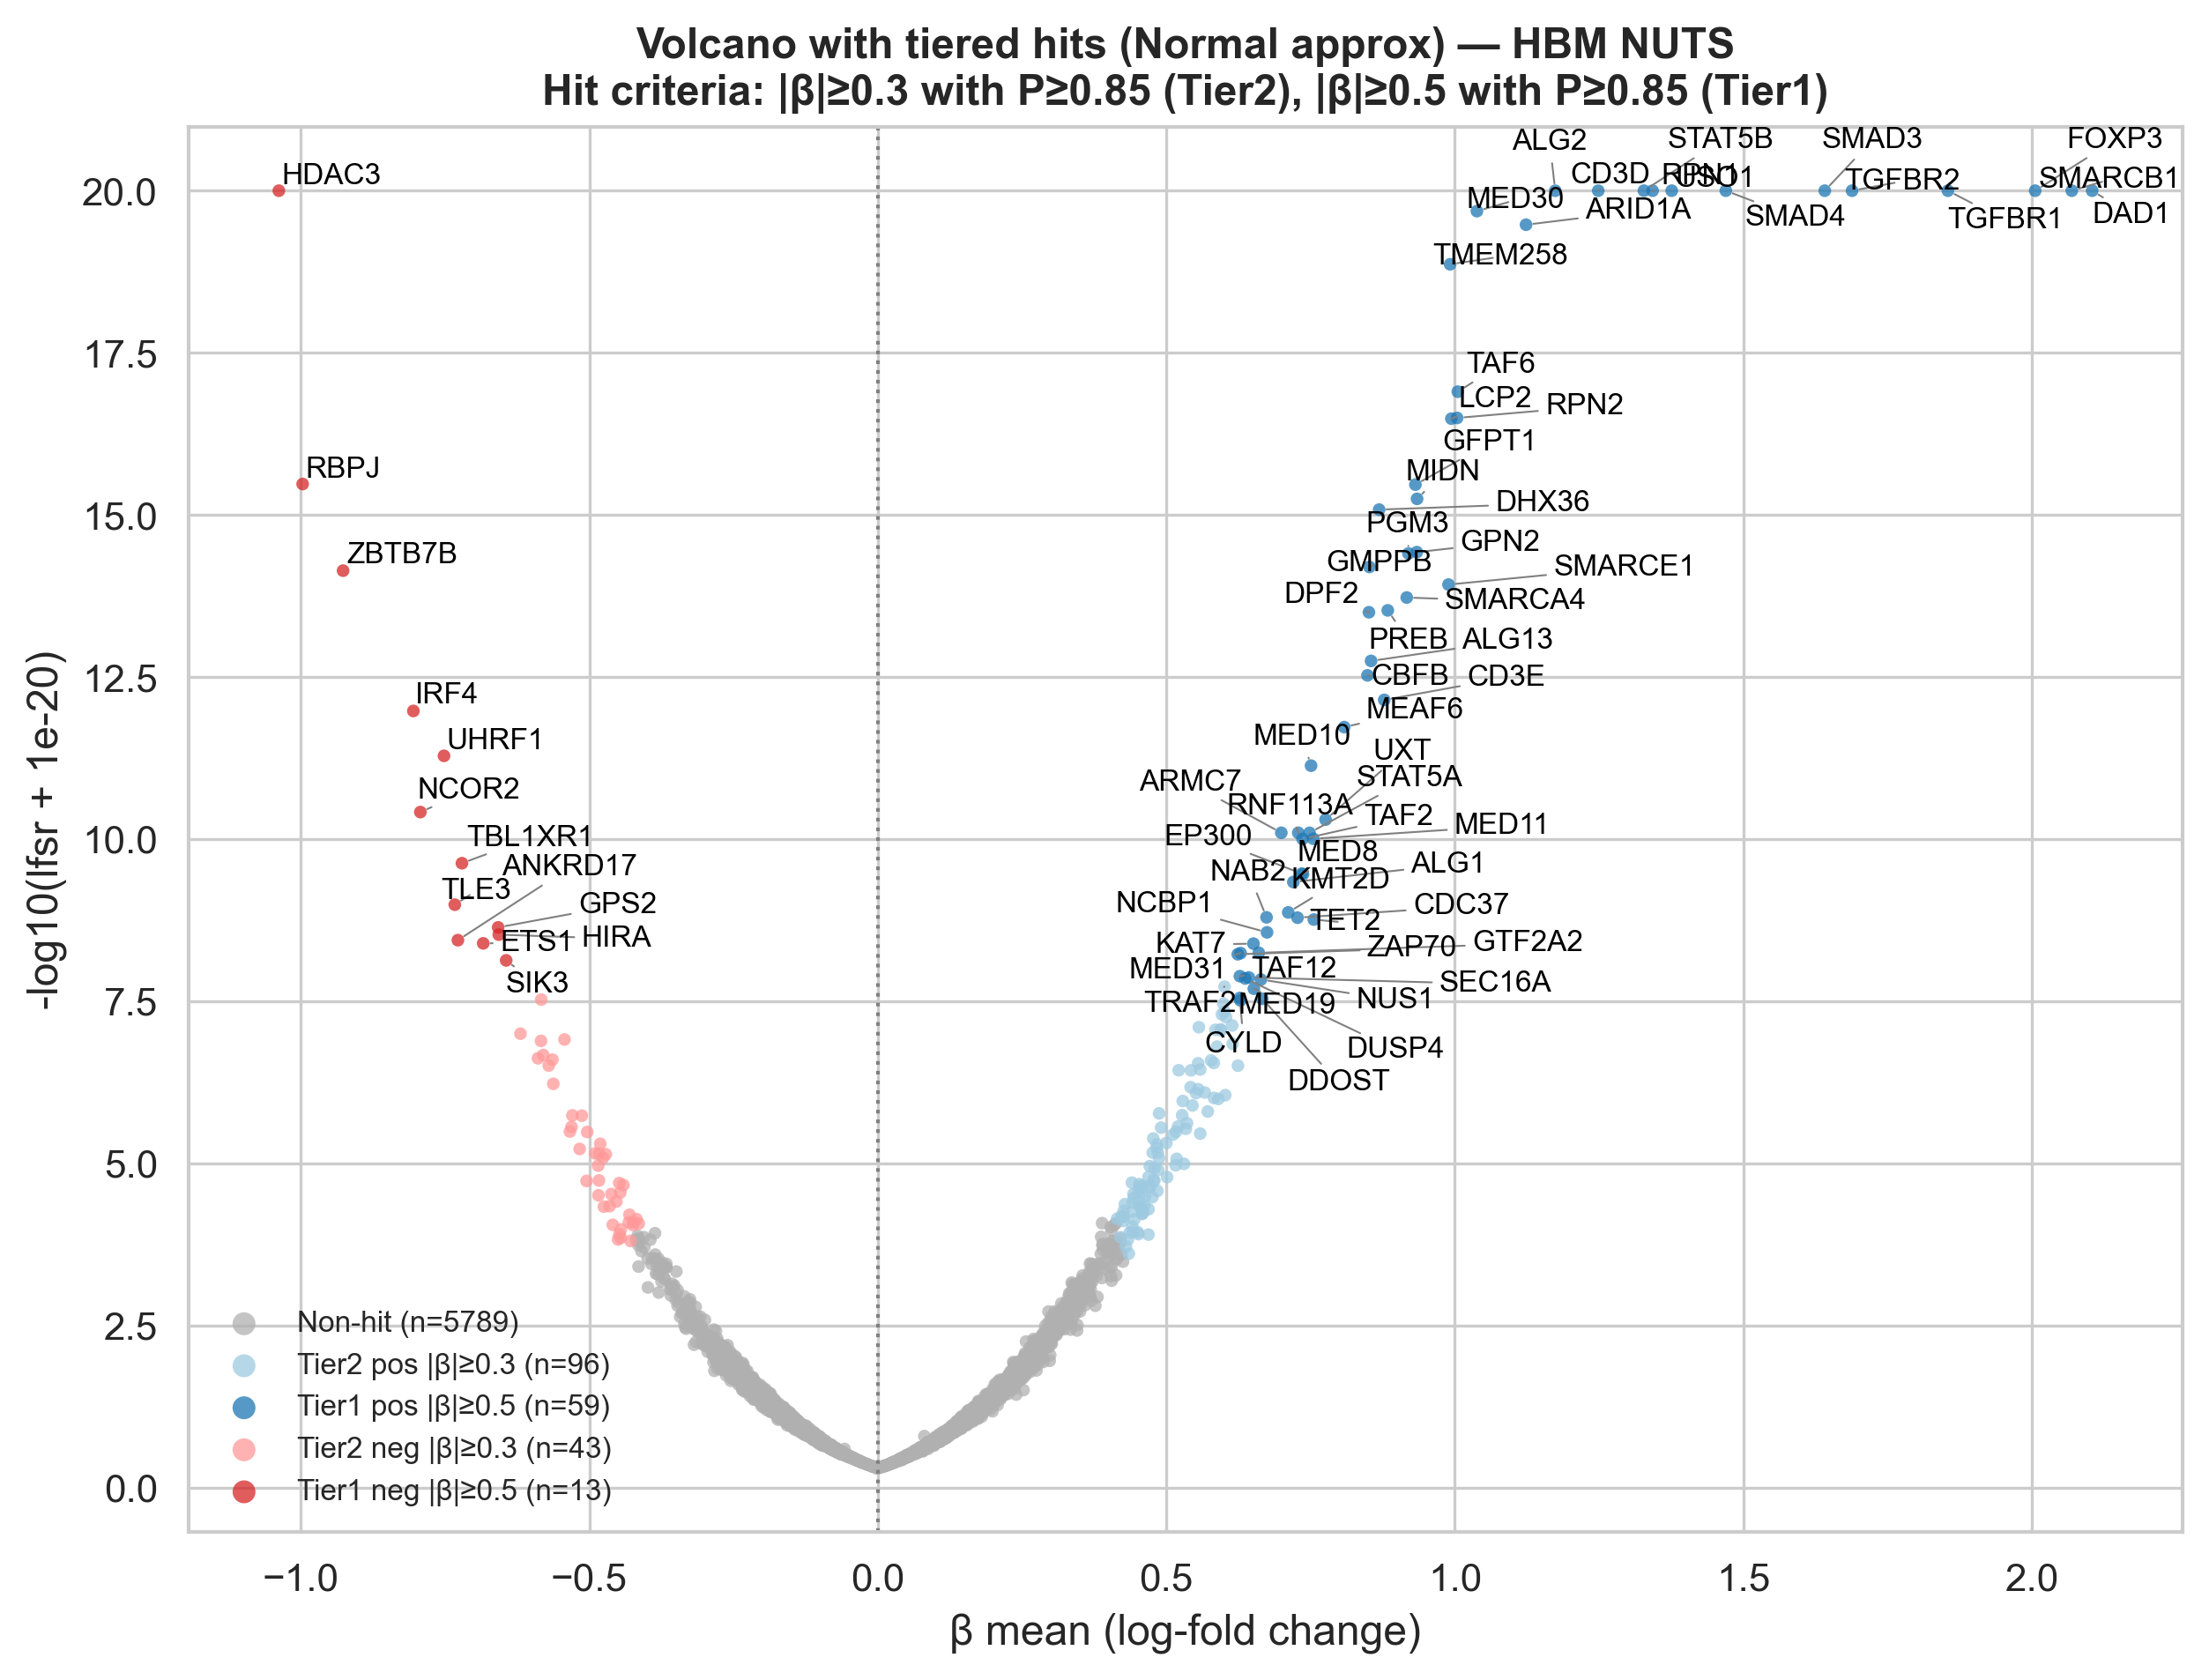

Volcano created from: ../../outputs/tables/bayes_gene_summary_hbm_nuts_normal_approx.csv
Tier1: |beta|>=0.5 with P>= 0.85 → hits: 72
Tier2: |beta|>=0.3 with P>= 0.85 → hits: 139
Non-hits: 5789
Saved figure to: ../../outputs/figures/volcano_beta_mean_vs_neglog10_lfsr_hits_normal_approx_prob_tiers.png
Points plotted: 6000


In [27]:
# Volcano plot (tiered hits by normal approximation): beta_mean vs -log10(lfsr)
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# Preferred and fallback tables
normal_csv = "../../outputs/tables/bayes_gene_summary_hbm_nuts_normal_approx.csv"
fallback_csv = "../../outputs/tables/bayes_gene_summary_hbm_nuts_with_probs.csv"

# Load data with fallback
if os.path.exists(normal_csv):
    df = pd.read_csv(normal_csv)
    used = normal_csv
else:
    df = pd.read_csv(fallback_csv)
    used = fallback_csv

# Resolve beta mean column
beta_cols = [c for c in ["beta_mean_nuts", "beta_mean", "beta_hat", "beta"] if c in df.columns]
if not beta_cols:
    beta_cols = [c for c in df.columns if ("beta" in c.lower() and "mean" in c.lower())]
if not beta_cols:
    raise ValueError("Could not find a beta mean column. Looked for beta_mean_nuts, beta_mean, beta_hat, beta.")

beta_col = beta_cols[0]

# Resolve lfsr column (for y-axis only)
lfsr_cols = [c for c in ["lfsr_norm", "lfsr_nuts", "lfsr"] if c in df.columns]
if not lfsr_cols:
    # Try derive from any p(sign error)
    psp_cols = [c for c in df.columns if c.lower().startswith("psp") or c.lower().startswith("p_sign")]
    if psp_cols:
        p = df[psp_cols[0]].clip(0, 1)
        df["lfsr_norm"] = np.minimum(p, 1 - p)
        lfsr_cols = ["lfsr_norm"]
if not lfsr_cols:
    raise ValueError("Could not find or derive an lfsr column. Expected lfsr_norm, lfsr_nuts, or lfsr.")

lfsr_col = lfsr_cols[0]

# Tier thresholds and probability cutoff
PROB_MIN = 0.85
TIER1_THRESH = 0.5
TIER2_THRESH = 0.3

# Compute normal-approx P(|beta| >= t) for t in {TIER1, TIER2}
# Prefer NUTS mean/sd, fallback to generic mean/sd, otherwise look for precomputed columns
mean_sd_pairs = [("beta_mean_nuts", "beta_sd_nuts"), ("beta_mean", "beta_sd")]
pair = next(((m, s) for (m, s) in mean_sd_pairs if m in df.columns and s in df.columns), None)

def p_abs_from_norm(thresh):
    if pair is not None:
        m = pd.to_numeric(df[pair[0]], errors='coerce').values
        sd = np.clip(pd.to_numeric(df[pair[1]], errors='coerce').values, 1e-12, np.inf)
        z_pos = (thresh - m) / sd
        z_neg = (-thresh - m) / sd
        p_pos = 1.0 - norm.cdf(z_pos)
        p_neg = norm.cdf(z_neg)
        return pd.Series(np.clip(p_pos + p_neg, 0.0, 1.0), index=df.index)
    # No mean/sd → try precomputed columns
    cand = f"p_abs_beta_ge_{str(thresh).replace('.', '_')}_norm"
    if cand in df.columns:
        return pd.to_numeric(df[cand], errors='coerce')
    return None

p_abs_t2 = p_abs_from_norm(TIER2_THRESH)
p_abs_t1 = p_abs_from_norm(TIER1_THRESH)

if p_abs_t2 is None:
    raise ValueError("Could not compute P(|beta|>=0.3). Provide mean/sd columns or a precomputed p_abs_beta_ge_0_3_norm.")
if p_abs_t1 is None:
    # If 0.5 cannot be computed, define Tier1 as empty but proceed
    p_abs_t1 = pd.Series(0.0, index=df.index)

# Flags
hit_t1 = (p_abs_t1 >= PROB_MIN)
hit_t2 = (p_abs_t2 >= PROB_MIN) & (~hit_t1)

# Prepare plotting frame
plot_df = df[[beta_col, lfsr_col]].copy()
plot_df = plot_df.replace([np.inf, -np.inf], np.nan).dropna()
plot_df["neglog10_lfsr"] = -np.log10(np.clip(plot_df[lfsr_col], 1e-300, 1.0) + 1e-20)

# Attach tiers and sign
plot_df = plot_df.join(hit_t1.rename("hit_t1"), how="left").join(hit_t2.rename("hit_t2"), how="left")
plot_df[["hit_t1", "hit_t2"]] = plot_df[["hit_t1", "hit_t2"]].fillna(False)

# Category assignment for coloring
cat = np.full(len(plot_df), "none", dtype=object)
pos = plot_df[beta_col] >= 0
neg = ~pos
cat[(plot_df["hit_t2"]) & pos] = "tier2_pos"
cat[(plot_df["hit_t2"]) & neg] = "tier2_neg"
cat[(plot_df["hit_t1"]) & pos] = "tier1_pos"
cat[(plot_df["hit_t1"]) & neg] = "tier1_neg"
plot_df["category"] = cat

# Color map (gradient by tier and sign)
color_map = {
    "none": "#B0B0B0",      # gray
    "tier2_pos": "#9ecae1", # light blue
    "tier1_pos": "#1f77b4", # dark blue
    "tier2_neg": "#ff9999", # light red
    "tier1_neg": "#d62728", # dark red
}

# Plot by category to build a legend
plt.figure(figsize=(8.5, 6.5))
for key in ["none", "tier2_pos", "tier1_pos", "tier2_neg", "tier1_neg"]:
    sub = plot_df[plot_df["category"] == key]
    if len(sub) == 0:
        continue
    label = {
        "none": f"Non-hit (n={len(sub)})",
        "tier2_pos": f"Tier2 pos |β|≥{TIER2_THRESH} (n={len(sub)})",
        "tier1_pos": f"Tier1 pos |β|≥{TIER1_THRESH} (n={len(sub)})",
        "tier2_neg": f"Tier2 neg |β|≥{TIER2_THRESH} (n={len(sub)})",
        "tier1_neg": f"Tier1 neg |β|≥{TIER1_THRESH} (n={len(sub)})",
    }[key]
    plt.scatter(sub[beta_col], sub["neglog10_lfsr"], c=color_map[key], s=12, edgecolors="none", alpha=0.75, label=label)

plt.axvline(0, color="gray", linestyle=":", linewidth=1)
plt.xlabel("β mean (log-fold change)")
plt.ylabel("-log10(lfsr + 1e-20)")
plt.title(f"Volcano with tiered hits (Normal approx) — HBM NUTS\nHit criteria: |β|≥{TIER2_THRESH} with P≥{PROB_MIN} (Tier2), |β|≥{TIER1_THRESH} with P≥{PROB_MIN} (Tier1)")
plt.legend(frameon=False, markerscale=1.8, fontsize=8, loc="best")
plt.tight_layout()

# Optional labels for top points (by y-value)
try:
    from adjustText import adjust_text
    label_col = None
    for cand in ['gene', 'Gene', 'gene_symbol', 'label', 'name']:
        if cand in df.columns:
            label_col = cand
            break
    if label_col is not None and len(plot_df) > 0:
        top_k = min(int(plot_df['hit_t1'].sum()), len(plot_df))
        temp = plot_df.join(df[label_col], how="left")
        top = temp.nlargest(top_k, "neglog10_lfsr")
        texts = []
        for _, row in top.iterrows():
            texts.append(plt.text(row[beta_col], row["neglog10_lfsr"], row[label_col], fontsize=8, color="black"))
        adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))
except Exception:
    pass

# Save figure
out_fig = "../../outputs/figures/volcano_beta_mean_vs_neglog10_lfsr_hits_normal_approx_prob_tiers.png"
os.makedirs(os.path.dirname(out_fig), exist_ok=True)
plt.savefig(out_fig, dpi=200)
plt.show()

# Reporting
n_t1 = int(plot_df['hit_t1'].sum())
n_t2 = int(plot_df['hit_t2'].sum())
n_none = int((plot_df['category'] == 'none').sum())
print(f"Volcano created from: {used}")
print(f"Tier1: |beta|>={TIER1_THRESH} with P>= {PROB_MIN} → hits: {n_t1}")
print(f"Tier2: |beta|>={TIER2_THRESH} with P>= {PROB_MIN} → hits: {n_t2}")
print(f"Non-hits: {n_none}")
print(f"Saved figure to: {out_fig}")
print(f"Points plotted: {len(plot_df)}")

In [45]:
# Extract selected genes from NUTS hits using the three filters:
# - p_abs_beta_ge_0_5 > 0.85
# - lfsr_nuts < 0.05
# - present in outputs/tables/overlap_hits_hbm_nuts_only.csv
import pandas as pd
from pathlib import Path
import numpy as np
# Resolve project paths similar to other cells
project_root = globals().get('project_root', Path('..').resolve().parent)
table_dir = globals().get('table_dir', project_root / 'outputs' / 'tables')
table_dir = Path(table_dir)
# Input files
hits_path = table_dir / 'hits_hbm_nuts.csv'
overlap_path = table_dir / 'overlap_hits_hbm_nuts_only.csv'
if not hits_path.exists():
    raise FileNotFoundError(f'Missing NUTS hits file: {hits_path}. Run the NUTS hit-calling cell first.')
if not overlap_path.exists():
    raise FileNotFoundError(f'Missing overlap file: {overlap_path}. Run the overlap cell first.')
# Load tables
hits = pd.read_csv(hits_path)
overlap = pd.read_csv(overlap_path)
# Normalise gene column names and strip whitespace
if 'gene' not in hits.columns:
    # try common alternatives
    cand = [c for c in hits.columns if c.lower() in ('id','gene_symbol','gene_name','name')]
    if cand:
        hits = hits.rename(columns={cand[0]: 'gene'})
    else:
        raise ValueError('Could not find a gene column in hits_hbm_nuts.csv')
hits['gene'] = hits['gene'].astype(str).str.strip()
overlap['gene'] = overlap['gene'].astype(str).str.strip()
# Helper: find a column by exact name or by substring match (case-insensitive)
def find_col(df, exacts=None, contains=None):
    cols = list(df.columns)
    lo = {c.lower(): c for c in cols}
    if exacts:
        for e in exacts:
            if e.lower() in lo:
                return lo[e.lower()]
    if contains:
        for cstrs in contains:
            for c in cols:
                name = c.lower()
                if all(s.lower() in name for s in cstrs):
                    return c
    return None
# Find p_abs_beta_ge_0_5-like column
pcol = find_col(hits, exacts=['p_abs_beta_ge_0_5','p_abs_0_5','p_abs_beta_ge_0.5','p_abs_beta_ge_0_5_norm'], contains=[[ 'p_abs', '0_5' ], ['p_abs', '0.5'], ['p_abs_beta', '0_5']])
if pcol is None:
    # fallback: any column containing 'p_abs' and '0' AND '5' (loose)
    for c in hits.columns:
        if 'p_abs' in c.lower() and ('0_5' in c.lower() or '0.5' in c.lower() or '05' in c.lower()):
            pcol = c
            break
if pcol is None:
    raise ValueError('Could not find a column corresponding to P(|beta|>=0.5) in hits_hbm_nuts.csv')
# Find lfsr column (prefer lfsr_nuts)
lcol = find_col(hits, exacts=['lfsr_nuts','lfsr_draws','lfsr_norm','lfsr'], contains=[['lfsr']])
if lcol is None:
    raise ValueError('Could not find an LFSR-like column (lfsr_nuts, lfsr_draws, lfsr) in hits_hbm_nuts.csv')
# Coerce numeric where appropriate
hits[pcol] = pd.to_numeric(hits[pcol], errors='coerce')
hits[lcol] = pd.to_numeric(hits[lcol], errors='coerce')
# Apply filters (drop rows with missing values in these cols)
mask = hits[pcol].gt(0.85) & hits[lcol].lt(0.05) & hits['gene'].notna()
sel = hits.loc[mask, 'gene'].astype(str).str.strip().unique().tolist()
# Intersect with overlap-only genes
overlap_genes = overlap['gene'].dropna().astype(str).str.strip().unique().tolist()
final_genes = sorted(set(sel) & set(overlap_genes))
# Save result
out_path = table_dir / 'selected_genes_from_hits_hbm_nuts.csv'
pd.DataFrame({'gene': final_genes}).to_csv(out_path, index=False)
print(f'Saved selected genes to: {out_path} (n={len(final_genes)})')
# Show preview if running interactively
try:
    import IPython
    display(pd.DataFrame({'gene': final_genes}).head(50))
except Exception:
    print(final_genes[:50])

Saved selected genes to: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/selected_genes_from_hits_hbm_nuts.csv (n=0)


,gene
